# Sheet

# Installations and Imports

In [149]:
!pip install wrds
!pip install polars

In [150]:
import pandas as pd
import polars as pl
from tqdm import tqdm
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
import os
import warnings
from pathlib import Path
import gc

pd.set_option('display.max_columns', None)

warnings.filterwarnings('ignore')

In [151]:
conn = wrds.Connection()

Enter your WRDS username [datalore]: aryaman_awasthi
Enter your password: ·············
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?:  y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


# Helper Functions

In [152]:
def list_all_wrds_libraries(display=False):
    libs = conn.list_libraries()
    if display:
        display(libs)


def list_all_wrds_tables(library_str='crsp', display=False):
    crsp_tables = conn.list_tables(library_str)
    if display:
        display(crsp_tables)
    return crsp_tables


def describe_table(library_str='crsp', table_str='stocknames_v2'):
    display(conn.describe_table(library_str, table_str))


def pull_data_sample(table, limit=100, where=None):
    # create base query
    query = """SELECT * FROM {}""".format(table)

    if where:
        # adding where condition
        query += """ WHERE {}""".format(where)

    if limit:
        # extracting only limited number of rows to have a peek at the data
        query += """ LIMIT {}""".format(limit)

    # return query result
    return conn.raw_sql(query)


def get_unique_col_vals(table='comp_na_daily_all.wrds_ratios', column_name='gvkey'):
    # build query string
    query = """SELECT DISTINCT {} FROM {}""".format(column_name, table)

    # run query and return unique records
    return (conn.raw_sql(query)[column_name].unique()).tolist()

# Constituent Data

In [153]:
# constituent data pull and save
if not os.path.exists('./constituent_data.parquet'):
    (
        # pulling in data  using helper 
        pull_data_sample('crsp_a_indexes.dsp500list_v2', limit=None, where=None)
        # dropping redundant columns
        .drop(columns=['indno', 'mbrflg', 'indfam'])
        # saving data
        .to_parquet('./constituent_data.parquet')
    )

# reading constituent file
constituent_data = pd.read_parquet('./constituent_data.parquet')

constituent_data.head()

,permno,mbrstartdt,mbrenddt
0,10006,1957-03-01,1984-07-18
1,10030,1957-03-01,1969-01-08
2,10049,1925-12-31,1932-10-01
3,10057,1957-03-01,1992-07-02
4,10078,1992-08-20,2010-01-28


# $\texttt{gvkey}$ Linking Table Extraction

In [156]:
# linking table for permno conversion to gvkey and vice versa
if not os.path.exists('./gvkey_linking_table.parquet'):
    (
        # pulling in linking data
        pull_data_sample('crsp_a_ccm.ccmxpf_linktable', limit=None, where=None)
        # saving output
        .to_parquet('./gvkey_linking_table.parquet')
    )

# reading linking file
linking_table = pd.read_parquet('./gvkey_linking_table.parquet')

linking_table.head()

,gvkey,linkprim,liid,linktype,lpermno,lpermco,usedflag,linkdt,linkenddt
0,001000,C,00X,NU,<NA>,<NA>,-1.0,1961-01-01,1970-09-29
1,001000,P,01,NU,<NA>,<NA>,-1.0,1970-09-30,1970-11-12
2,001000,P,01,LU,25881.0,23369.0,1.0,1970-11-13,1978-06-30
3,001001,C,00X,NU,<NA>,<NA>,-1.0,1978-01-01,1983-09-19
4,001001,P,01,LU,10015.0,6398.0,1.0,1983-09-20,1986-07-31


# Stock Names File

In [155]:
# stocknames table for permno conversion
if not os.path.exists('./stockname_data.parquet'):
    (
        # stocknames file
        pull_data_sample('crsp_a_stock.stocknames', limit=None, where=None)
        # saving output
        .to_parquet('./stockname_data.parquet')
    )

# reading stocknames file
stocknames_table = pd.read_parquet('./stockname_data.parquet')

stocknames_table.head()

,permno,namedt,nameenddt,shrcd,exchcd,siccd,ncusip,ticker,comnam,shrcls,permco,hexcd,cusip,st_date,end_date,namedum
0,10000,1986-01-07,1987-06-11,10,3,3990,68391610,OMFGA,OPTIMUM MANUFACTURING INC,A,7952,3,68391610,1986-01-07,1987-06-11,2.0
1,10001,1986-01-09,1993-11-21,11,3,4920,39040610,GFGC,GREAT FALLS GAS CO,<NA>,7953,2,36720410,1986-01-09,2017-08-03,2.0
2,10001,1993-11-22,2008-02-04,11,3,4920,29274A10,EWST,ENERGY WEST INC,<NA>,7953,2,36720410,1986-01-09,2017-08-03,2.0
3,10001,2008-02-05,2009-08-03,11,3,4920,29274A20,EWST,ENERGY WEST INC,<NA>,7953,2,36720410,1986-01-09,2017-08-03,2.0
4,10001,2009-08-04,2009-12-17,11,3,4920,29269V10,EGAS,ENERGY INC,<NA>,7953,2,36720410,1986-01-09,2017-08-03,2.0


# $\texttt{secid}$ Linking Table Extraction

In [157]:
# linking table for secid conversion
if not os.path.exists('./secid_linking_table.parquet'):
    (
        # secid linking file extraction
        pull_data_sample('wrdsapps_link_crsp_optionm.opcrsphist', limit=None, where=None)
        # saving output
        .to_parquet('./secid_linking_table.parquet')
    )

# reading stocknames file
secid_linking_table = pd.read_parquet('./secid_linking_table.parquet')

secid_linking_table.head()

,secid,sdate,edate,permno,score
0,5001.0,1996-01-02,1996-03-13,10074,1.0
1,5002.0,1996-01-01,1996-02-22,10154,1.0
2,5003.0,<NA>,<NA>,<NA>,6.0
3,5004.0,1996-01-01,2000-01-27,80071,1.0
4,5005.0,1996-01-01,1997-08-12,85041,1.0


# Merging all Linking Tables

## Helper Functions

In [158]:
def master_key_mapping_directory(constituent_data: pd.DataFrame,
                                 stocknames_table: pd.DataFrame,
                                 linking_table: pd.DataFrame,
                                 secid_linking_table: pd.DataFrame) -> pd.DataFrame:
    # removing null values of tickers from stock names table
    stocknames_table = stocknames_table[stocknames_table['ticker'].astype(str) != '<NA>'].reset_index(drop=True)

    # typecast permno and permco columns to integer for consistency pre group
    stocknames_table['permno'] = stocknames_table['permno'].astype(int)
    stocknames_table['ticker'] = stocknames_table['ticker'].astype(str)
    stocknames_table['permco'] = stocknames_table['permco'].astype(int)

    # ticker and permco discovery for permno
    ticker_permco_table = (stocknames_table.groupby(['permno'])
                           # aggregate by permno and get a list of tickers and permcos
                           .agg(ticker_names=('ticker', 'unique'),
                                permco=('permco', 'unique'),
                                permco_len=('permco', 'nunique'))
                           .reset_index())

    # typcast permno columns to integer for consistency in merge
    constituent_data['permno'] = constituent_data['permno'].astype(int)

    # merging consituent table with ticker and permco table
    merged = pd.merge(constituent_data, ticker_permco_table, how='left', on=['permno']).reset_index(drop=True)

    # remove null values from 
    gvkey_table = linking_table[~pd.isna(linking_table['lpermno'])].reset_index(drop=True)

    # typecasting gvkey and permno into ineteger for data type consistency when merging
    gvkey_table['lpermno'] = gvkey_table['lpermno'].astype(int)
    gvkey_table['gvkey'] = gvkey_table['gvkey'].astype(int)

    # grouping to find gvkeys for every permno
    gvkey_table = (gvkey_table.groupby(['lpermno'])
                   # aggregating to find unique gvkeys
                   .agg(gvkey=('gvkey', 'unique'),
                        gvkey_len=('gvkey', 'nunique'))
                   .reset_index()
                   # renaming lpermno to permno
                   .rename(columns={'lpermno': 'permno'}))

    # final merge into output result table
    merged = pd.merge(merged, gvkey_table, on=['permno'], how='left').reset_index(drop=True)

    # typecasting secid and permno as integer columns
    secid_linking_table['secid'] = secid_linking_table['secid'].astype(int)

    # filter out null values from secid and typecast into int
    secid_table = secid_linking_table[~pd.isna(secid_linking_table['permno'])].reset_index(drop=True)
    secid_table['permno'] = secid_table['permno'].astype(int)

    # group to get unique secid for every permno
    secid_table = secid_table.groupby(['permno']).agg(secid=('secid', 'unique'),
                                                      secid_len=('secid', 'nunique')).reset_index()

    # merge into output table and return
    merged = pd.merge(merged, secid_table, on=['permno'], how='left').reset_index(drop=True)

    return merged


def get_financial_data_for_gvkeys(gvkeys: list):
    # create root direcctory if it doesnt exist
    os.makedirs('./data/financial_data', exist_ok=True)

    for gvkey in tqdm(gvkeys):

        # check if file already exists
        if os.path.exists('./data/financial_data/gvkey_{}.parquet'.format(gvkey)):
            print('file for gvkey: {} already exists, continue'.format(gvkey))
            continue

        # pulling data in per gvkey
        query_string = """comp_na_daily_all.wrds_ratios WHERE gvkey = {}""".format(gvkey)

        # run query and save
        df = pull_data_sample('comp_na_daily_all.wrds_ratios', limit=None, where="""gvkey = '{}'""".format(gvkey))

        # save data into directory with gvkey identifier
        df.to_parquet('./data/financial_data/gvkey_{}.parquet'.format(gvkey))

        # explicitly call garbage collection
        gc.collect()

        # free df from RAM
        del df
    else:
        print("file already exists")


def create_options_forwards_underlying_and_vol_surface_data(secids: list):
    # iterate over secids
    for secid in tqdm(secids):
        if ((os.path.exists(f'./data/options/secid_{secid}.parquet')) and
                (os.path.exists(f'./data/forwards/secid_{secid}.parquet')) and
                (os.path.exists(f'./data/underlying/secid_{secid}.parquet')) and
                (os.path.exists(f'./data/vol_surface/secid_{secid}.parquet'))):
            print(f'secid: {secid} files already exist, continue')
            continue

        # master dataframes
        options_master = pd.DataFrame()
        forward_master = pd.DataFrame()
        underlying_master = pd.DataFrame()
        vol_surface_master = pd.DataFrame()

        # create root directory if it doesnt exist
        os.makedirs('./data/options', exist_ok=True)
        os.makedirs('./data/forwards', exist_ok=True)
        os.makedirs('./data/underlying', exist_ok=True)
        os.makedirs('./data/vol_surface', exist_ok=True)

        for year in tqdm(range(1996, 2024)):
            # pulling option data
            options_master = pd.concat([options_master, pull_data_sample(f'optionm.opprcd{str(int(year))}',
                                                                         where=f"secid = '{secid}'", limit=None)],
                                       ignore_index=True)

            # pulling forward data
            forward_master = pd.concat([pull_data_sample(f'optionm.fwdprd{str(int(year))}',
                                                         where=f"secid = '{secid}'", limit=None)],
                                       ignore_index=True)

            # pulling underlying data
            underlying_master = pd.concat([pull_data_sample(f'optionm.secprd{str(int(year))}',
                                                            where=f"secid = '{secid}'", limit=None)
                                          # filter based on the columns required 
                                          .loc[:, ['date', 'open', 'high', 'low', 'close', 'volume', 'return',
                                                   'cfadj', 'cfret', 'shrout']]],
                                          ignore_index=True)

            # pulling volatility surface data
            vol_surface_master = pd.concat(
                [pull_data_sample(f'optionm.vsurfd{str(int(year))}', where=f"secid = '{secid}'",
                                  limit=None)],
                ignore_index=True)

            # collect garbage and clear out RAM for next cycle
            gc.collect()

        # save data into respective directories
        options_master.to_parquet(f'./data/options/secid_{secid}.parquet')
        forward_master.to_parquet(f'./data/forwards/secid_{secid}.parquet')
        underlying_master.to_parquet(f'./data/underlying/secid_{secid}.parquet')
        vol_surface_master.to_parquet(f'./data/vol_surface/secid_{secid}.parquet')

## VIX Data Extraction

In [159]:
# vix data
if not os.path.exists('./data/vix.parquet'):
    pull_data_sample('cboe.cboe', None).to_parquet('./data/vix.parquet')
else:
    print("file already exists")

print("done")

file already exists
done


## Yield Curve Data

In [160]:
# zero curve yield data data
if not os.path.exists('./data/yield.parquet'):
    pull_data_sample('optionm.zerocd', None).to_parquet('./data/yield.parquet')
else:
    print("file already exists")

print("done")

file already exists
done


In [161]:
# creating master key map
master_map = master_key_mapping_directory(constituent_data, stocknames_table, linking_table, secid_linking_table)

# permco has at max 1 value for all permnos, most consistent

In [162]:
master_map

,permno,mbrstartdt,mbrenddt,ticker_names,permco,permco_len,gvkey,gvkey_len,secid,secid_len
0,10006,1957-03-01,1984-07-18,[ACF],[22156],1.0,[1010],1.0,NaN,NaN
1,10030,1957-03-01,1969-01-08,[ABK],[22160],1.0,[1057],1.0,NaN,NaN
2,10049,1925-12-31,1932-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10057,1957-03-01,1992-07-02,"[NCM, AMT]",[20020],1.0,"[1098, 7701]",2.0,[5008],1.0
4,10078,1992-08-20,2010-01-28,"[SUNW, JAVA]",[8021],1.0,[12136],1.0,[110611],1.0
...,...,...,...,...,...,...,...,...,...,...
2059,93159,2012-07-31,2016-03-29,"[ESV, VAL]",[53296],1.0,[2270],1.0,[104056],1.0
2060,93246,2021-03-22,2024-12-31,[GNRC],[53339],1.0,[183736],1.0,[140530],1.0
2061,93422,2010-07-01,2015-06-30,[QEP],[53439],1.0,[154357],1.0,[143086],1.0
2062,93429,2017-03-01,2024-12-31,[CBOE],[53447],1.0,[184500],1.0,[143077],1.0


In [164]:
# get all gvkeys
gvkeys = np.concatenate(master_map['gvkey'].dropna().values).astype('int64').tolist()

# get all permcos
permcos = np.concatenate(master_map['permco'].dropna().values).astype('int64').tolist()

# get all secids
secids = np.concatenate(master_map['secid'].dropna().values).astype('int64').tolist()

In [165]:
# options forwards and vol surface data extraction
create_options_forwards_underlying_and_vol_surface_data(secids)

secid: 5008 files already exist, continue
secid: 110611 files already exist, continue
secid: 108505 files already exist, continue
secid: 107525 files already exist, continue
secid: 110622 files already exist, continue
secid: 101226 files already exist, continue
secid: 101226 files already exist, continue
secid: 109181 files already exist, continue
secid: 105785 files already exist, continue
secid: 104049 files already exist, continue
secid: 104958 files already exist, continue
secid: 106982 files already exist, continue
secid: 105216 files already exist, continue
secid: 101053 files already exist, continue
secid: 207618 files already exist, continue
secid: 5061 files already exist, continue
secid: 100930 files already exist, continue
secid: 101639 files already exist, continue
secid: 101639 files already exist, continue
secid: 110368 files already exist, continue
secid: 5067 files already exist, continue
secid: 104830 files already exist, continue
secid: 105615 files already exist, con

 76%|███████▌  | 1157/1528 [25:14<08:05,  1.31s/it]  


KeyboardInterrupt: KeyboardInterrupt

In [ ]:
get_financial_data_for_gvkeys(gvkeys)

## Empty Files Ratio

In [10]:
def get_empty_files(string):
    root = f'/data/notebook_files/data/{string}'
    empties = 0
    length = len(os.listdir(root))
    for path in os.listdir(root):
        df = pd.read_parquet(f'{root}/{path}')
        rows = df.shape[0]
        if rows == 0:
            empties += 1

    print(f'{(empties / length) * 100:.03f}% of {string} data is empty')

In [11]:
get_empty_files('financial_data')

90.442% of financial_data data is empty


In [12]:
get_empty_files('vol_surface')

56.250% of vol_surface data is empty


In [13]:
get_empty_files('underlying')

54.182% of underlying data is empty


In [14]:
get_empty_files('options')

10.506% of options data is empty


In [15]:
get_empty_files('forwards')

54.900% of forwards data is empty


# Key Questions to Answer
1. How to systematically evaluate a newly added feature to the dataset? Does it benefit or is it redundant?
2. How to systematically evaluate a change in a hyperameter of the model architecture? Does it improve performance?
3. Define performance metric, how do you determine anything with a uniform yardstick?

## Suggestions from Wenkang
- Usage of $\texttt{arcsinh()}$ over log for stability
- Maximum Information Criterion
- Robust Regression

## Steps for the Week
1. Create everything with linear assumptions and build a baseline model for comparison
2. End to end at least have an answer on the questions to answer for a linear model then move with more complex approaches
3. 

# data_pull

# Installations and Imports

In [26]:
!pip install wrds

In [27]:
import pandas as pd
import os
import time
import io
import csv
import wrds
import json
import re
import requests
import sys
import numpy as np
from datetime import datetime
from functools import reduce
from typing import List, Dict, Set, Iterable, Any
from tqdm import tqdm
import gc
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from sklearn.linear_model import ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)

## Global Initialization Variables

In [28]:
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "SB4LTLSNZWSA53UG")
BASE = "https://www.alphavantage.co/query"
db = wrds.Connection()

Enter your WRDS username [datalore]: duresh08
Enter your password: ··············
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?:  y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Constituent Helpers

In [29]:
def sp500_history_with_names(db):
    """
    Full S&P 500 membership history with identifiers.
    Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
    """
    q = """
        with m as (
            select
                permno::int8 as permno,
                start::date  as start,
                coalesce(ending, date '2262-04-11')::date as "end"
            from crsp.dsp500list
            where permno is not null
        )
        select
            m.permno,
            n.ticker,
            n.comnam  as company_name,
            n.ncusip,
            n.shrcd,
            n.exchcd,
            m.start,
            m."end"
        from m
        left join crsp.stocknames n
          on n.permno = m.permno
         and n.namedt <= m."end"
         and coalesce(n.nameenddt, date '2262-04-11') >= m.start
        order by m.permno, m.start
    """
    # run query to get data
    df = db.raw_sql(q)

    # de-dupe overlapping name windows cleanly
    df = df.drop_duplicates(
        subset=["permno", "ticker", "company_name", "start", "end"]
    ).reset_index(drop=True)

    return df


def sp500_constituents_asof(db, asof_date: str):
    """
    Constituents on a given date, with identifiers.
    Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
    """
    q = """
        with m as (
            select
                permno::int8 as permno,
                start::date  as start,
                coalesce(ending, date '2262-04-11')::date as "end"
            from crsp.dsp500list
            where start <= %s
              and coalesce(ending, date '2262-04-11') >= %s
        )
        select distinct on (m.permno)
            m.permno,
            n.ticker,
            n.comnam  as company_name,
            n.ncusip,
            n.shrcd,
            n.exchcd,
            m.start,
            m."end"
        from m
        left join crsp.stocknames n
          on n.permno = m.permno
         and n.namedt <= %s
         and coalesce(n.nameenddt, date '2262-04-11') >= %s
        order by m.permno, m.start
    """
    df = db.raw_sql(q, params=(asof_date, asof_date, asof_date, asof_date))
    return df.reset_index(drop=True)

## AlphaVantage Helpers

In [30]:
def _av_call(params, pause=12):
    """Call Alpha Vantage (JSON), handle throttling, and return dict or None."""
    params = {**params, "apikey": API_KEY, "datatype": "json"}
    for _ in range(2):  # gentle retry if throttled
        r = requests.get(BASE, params=params, timeout=30)
        try:
            data = r.json()
        except json.JSONDecodeError:
            data = None
        if isinstance(data, dict) and any(k in data for k in ("Note", "Information")):
            time.sleep(pause)
            continue
        return data
    return data


def _parse_timeseries_json(data):
    """Normalize AV time series dict -> tidy DataFrame."""
    if not isinstance(data, dict):
        return None
    ts_key = next((k for k in data if "Time Series (Daily)" in k), None)
    if not ts_key or ts_key not in data:
        # adjusted has 'Daily Adjusted Time Series'
        ts_key = next((k for k in data if "Daily Adjusted Time Series" in k), None)
        if not ts_key or ts_key not in data:
            return None
    ts = data[ts_key]
    df = (
        pd.DataFrame(ts).T
        .rename_axis("date").reset_index()
        .sort_values("date")
    )
    rename = {
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. adjusted close": "adj_close",
        "5. volume": "volume",  # non-adjusted
        "6. volume": "volume",  # adjusted
        "6. dividend amount": "dividend",
        "7. dividend amount": "dividend",
        "7. split coefficient": "split_coef",
        "8. split coefficient": "split_coef",
    }
    df.columns = [rename.get(c, c) for c in df.columns]
    for c in ["open", "high", "low", "close", "adj_close", "dividend", "split_coef"]:
        if c in df: df[c] = pd.to_numeric(df[c], errors="coerce")
    if "volume" in df: df["volume"] = pd.to_numeric(df["volume"], errors="coerce").astype("Int64")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    df = df.dropna(subset=["date"]).reset_index(drop=True)
    if "adj_close" not in df:  # non-adjusted endpoint
        df["adj_close"] = df["close"]
    return df[["date", "open", "high", "low", "close", "adj_close", "volume"]]


def fetch_daily(symbol: str, adjusted: bool) -> pd.DataFrame | None:
    func = "TIME_SERIES_DAILY_ADJUSTED" if adjusted else "TIME_SERIES_DAILY"
    data = _av_call({"function": func, "symbol": symbol, "outputsize": "full"})
    df = _parse_timeseries_json(data)
    if df is None or df.empty:
        return pd.DataFrame()
    df.insert(1, "symbol", symbol)
    return df


def fetch_and_save(symbol: str):
    # Daily Adjusted
    adj = fetch_daily(symbol, adjusted=True)
    if adj.empty == False:
        print(f"[{symbol}] DAILY_ADJ: {len(adj)} rows | {adj['date'].min().date()} → {adj['date'].max().date()}")
    else:
        print(f"[{symbol}] DAILY_ADJ: no data returned")
    return adj


def fetch_financials(symbol: str, statement: str = "INCOME_STATEMENT") -> pd.DataFrame | None:
    """
    Pull fundamental financial data from Alpha Vantage.
    
    statement: one of {"INCOME_STATEMENT", "BALANCE_SHEET", "CASH_FLOW"}
    Returns a tidy DataFrame with annual + quarterly data stacked.
    """
    params = {"function": statement, "symbol": symbol, "apikey": API_KEY}

    # call with retry if throttled
    for _ in range(2):
        r = requests.get(BASE, params=params, timeout=30)
        try:
            data = r.json()
        except json.JSONDecodeError:
            data = None
        if isinstance(data, dict) and any(k in data for k in ("Note", "Information")):
            time.sleep(12)
            continue
        break

    if not isinstance(data, dict):
        return pd.DataFrame()

    # Parse out annual + quarterly
    records = []
    for freq in ["annualReports", "quarterlyReports"]:
        if freq in data:
            for row in data[freq]:
                row["frequency"] = "annual" if freq == "annualReports" else "quarterly"
                records.append(row)

    if not records:
        return pd.DataFrame()

    df = pd.DataFrame(records)
    # convert numeric columns where possible
    for col in df.columns:
        if col not in ("fiscalDateEnding", "reportedCurrency", "frequency"):
            df[col] = pd.to_numeric(df[col], errors="coerce")
    df["fiscalDateEnding"] = pd.to_datetime(df["fiscalDateEnding"], errors="coerce")

    # tidy sort
    df = df.sort_values(["frequency", "fiscalDateEnding"]).reset_index(drop=True)

    if df.empty == False:
        print(
            f"[{symbol}] {statement}: {len(df)} rows | {df['fiscalDateEnding'].min().date()} → {df['fiscalDateEnding'].max().date()}")
    else:
        print(f"[{symbol}] {statement}: no data returned")
    return df

In [31]:
def fetch_historical_options(symbol: str, dt: Optional[str] = None) -> pd.DataFrame:
    # dt format 'YYYY-MM-DD'; if None, AV returns the previous trading session
    params = {"symbol": symbol.upper()}
    if dt:
        params["date"] = dt
    data = av_query("HISTORICAL_OPTIONS", params)
    return data
    # Expected structure: {'symbol': 'IBM', 'underlying_symbol': 'IBM', 'data': [ ...contracts... ]}
    # if "data" not in data or not isinstance(data["data"], list):
    #     # Try to surface what we got
    #     raise RuntimeError(f"Unexpected options payload for {symbol}: keys={list(data.keys())[:8]}")
    # df = pd.DataFrame(data["data"])
    # # Attach context
    # df["symbol"] = data.get("symbol", symbol.upper())
    # df["underlying_symbol"] = data.get("underlying_symbol", symbol.upper())
    # df["asof_date"] = dt
    # # Coerce some common numeric fields if present
    # numeric_like = [
    #     "strike", "implied_volatility", "delta", "gamma", "theta", "vega", "rho",
    #     "open_interest", "volume", "bid", "ask", "last", "settlement_price"
    # ]
    # for c in numeric_like:
    #     if c in df.columns:
    #         df[c] = pd.to_numeric(df[c], errors="coerce")
    # # Parse expirations if present
    # for c in ("expiration", "last_trade_date"):
    #     if c in df.columns:
    #         df[c] = pd.to_datetime(df[c], errors="coerce")
    # return df


def ingest_options(symbols: Iterable[str], dates: Optional[List[str]] = None):
    """Append all dates into one parquet per underlying: data/financial/<SYMBOL>_OPTIONS.parquet"""
    if dates is None:
        dates = [None]  # meaning 'latest trading session'
    for sym in symbols:
        sym = sym.upper().strip()
        out_path = BASE_DIR / f"{sym}_OPTIONS.parquet"
        all_frames = []
        for dt in dates:
            df = fetch_historical_options(sym, dt)
            all_frames.append(df)
            print(f"Fetched {sym} {dt or '[prev session]'}: {len(df):,} rows")
            time.sleep(RATE_LIMIT_SECONDS)
        if all_frames:
            merged = pd.concat(all_frames, ignore_index=True)
            # If a prior file exists, union with de-dup
            if out_path.exists():
                prev = pd.read_parquet(out_path)
                merged = pd.concat([prev, merged], ignore_index=True).drop_duplicates()
            merged.to_parquet(out_path, index=False)
            print(f"Saved options {sym} -> {out_path}")

In [32]:
def av_query(function: str, params: Dict[str, Any]) -> Dict[str, Any]:
    """Generic Alpha Vantage GET with basic rate-limiting & retries."""
    payload = {
        "function": function,
        "apikey": API_KEY,
        **params,
    }
    # Basic retry loop
    for attempt in range(5):
        resp = requests.get(BASE, params=payload, timeout=60)
        if resp.status_code == 200:
            data = resp.json()
            # AV throttling and error messages often appear under 'Note' or 'Information'
            if any(k in data for k in ("Note", "Information", "Error Message")):
                # Respect rate limits if we hit them
                time.sleep(max(RATE_LIMIT_SECONDS, 15))
            else:
                return data
        else:
            time.sleep(2 + attempt)
    # Last try
    resp.raise_for_status()
    return resp.json()

## Global Variables

In [33]:
# create output directory
base_dir = "./alphavantage_data"

# tickers asof date set
ticker_asof_date = "2024-01-01"

# get all S&P500 tickers as of 2024-12-31
stocknames_table = sp500_constituents_asof(db, ticker_asof_date)

# get all the unique ticker names from the stocknames table into a list
stocknames_list = stocknames_table[~stocknames_table['ticker'].isnull()]['ticker'].unique()

## Options

In [41]:
# directory to save OHLCV adjusted data into
save_dir = f'{base_dir}/options'

# make save_dir directory
os.makedirs(save_dir, exist_ok=True)

# iterate over symbols one at a time and extract data
for sym in tqdm(stocknames_list, total=len(stocknames_list), desc="fetching data"):
    # check if file already exists
    if os.path.exists(f'{save_dir}/{sym}.parquet'):
        print(f'stock file for ticker: {sym} already exists, continue')
        continue

    # extracting OHLCV adjusted data
    df = fetch_historical_options(sym, dt="2025-08-01")
    break

pd.DataFrame(df['data']).loc[:, ['date', 'expiration', 'strike', 'delta', 'implied_volatility']].sort_values(
    ['expiration', 'strike'])

fetching data:   0%|          | 0/503 [00:00<?, ?it/s]


,date,expiration,strike,delta,implied_volatility
2,2025-08-01,2025-08-01,100.00,0.99486,7.18056
3,2025-08-01,2025-08-01,100.00,-0.00050,5.42450
4,2025-08-01,2025-08-01,105.00,0.99650,6.38058
5,2025-08-01,2025-08-01,105.00,-0.00054,5.15134
6,2025-08-01,2025-08-01,110.00,0.99514,6.30253
...,...,...,...,...,...
2007,2025-08-01,2027-12-17,360.00,-0.51283,0.46853
2008,2025-08-01,2027-12-17,370.00,0.39792,0.37097
2009,2025-08-01,2027-12-17,370.00,-0.51507,0.48804
2010,2025-08-01,2027-12-17,380.00,0.38005,0.37097


In [37]:
pd.DataFrame(df['data']).loc[:, ['date', 'expiration', 'strike', 'type', 'delta', 'implied_volatility']]

,date,expiration,strike,type,delta,implied_volatility
0,2025-08-01,2025-08-01,95.00,call,0.99470,7.66835
1,2025-08-01,2025-08-01,95.00,put,-0.00049,5.73669
2,2025-08-01,2025-08-01,100.00,call,0.99486,7.18056
3,2025-08-01,2025-08-01,100.00,put,-0.00050,5.42450
4,2025-08-01,2025-08-01,105.00,call,0.99650,6.38058
...,...,...,...,...,...,...
2007,2025-08-01,2027-12-17,360.00,put,-0.51283,0.46853
2008,2025-08-01,2027-12-17,370.00,call,0.39792,0.37097
2009,2025-08-01,2027-12-17,370.00,put,-0.51507,0.48804
2010,2025-08-01,2027-12-17,380.00,call,0.38005,0.37097


## OHLCV Data Extraction

In [10]:
# directory to save OHLCV adjusted data into
save_dir = f'{base_dir}/underlying'

# make save_dir directory
os.makedirs(save_dir, exist_ok=True)

# iterate over symbols one at a time and extract data
for sym in tqdm(stocknames_list, total=len(stocknames_list), desc="fetching data"):
    # check if file already exists
    if os.path.exists(f'{save_dir}/{sym}.parquet'):
        print(f'stock file for ticker: {sym} already exists, continue')
        continue

    # extracting OHLCV adjusted data
    df = fetch_and_save(sym)

    # saving data into directory
    if not df.empty:
        df.to_parquet(f'{save_dir}/{sym}.parquet')

    # sleep to use free tier sparingly
    time.sleep(15)


stock file for ticker: ORCL already exists, continue
stock file for ticker: MSFT already exists, continue
stock file for ticker: TROW already exists, continue
stock file for ticker: HON already exists, continue
stock file for ticker: ADM already exists, continue
stock file for ticker: FI already exists, continue
stock file for ticker: KO already exists, continue
stock file for ticker: CDNS already exists, continue
stock file for ticker: ED already exists, continue
stock file for ticker: FICO already exists, continue
[XRAY] DAILY_ADJ: 6507 rows | 1999-11-01 → 2025-09-15
stock file for ticker: FAST already exists, continue
stock file for ticker: DTE already exists, continue
stock file for ticker: ETN already exists, continue
stock file for ticker: XOM already exists, continue
stock file for ticker: MGM already exists, continue
stock file for ticker: WM already exists, continue
stock file for ticker: GD already exists, continue
stock file for ticker: GE already exists, continue
stock file

fetching data: 100%|██████████| 503/503 [05:33<00:00,  1.51it/s]


## Financial Data Extraction
- $\texttt{INCOME_STATEMENT}, \texttt{BALANCE_SHEET}, \texttt{CASH_FLOW}$

In [11]:
# create output directory
base_dir = "./alphavantage_data"

# directory to save OHLCV adjusted data into
income_statement_save_dir = f'{base_dir}/income_statement'
balance_sheet_save_dir = f'{base_dir}/balance_sheet'
cash_flow_save_dir = f'{base_dir}/cash_flow'

# make save_dir directory
os.makedirs(income_statement_save_dir, exist_ok=True)
os.makedirs(balance_sheet_save_dir, exist_ok=True)
os.makedirs(cash_flow_save_dir, exist_ok=True)

# iterate over symbols one at a time and extract data
for sym in tqdm(stocknames_list, total=len(stocknames_list), desc="fetching data"):

    # check if income statement file already exists
    if os.path.exists(f'{income_statement_save_dir}/{sym}.parquet'):

        print(f'income statement for ticker: {sym} already exists, continue')

    else:

        # pull income statement data
        df = fetch_financials(sym, "INCOME_STATEMENT")

        # saving data into directory
        if not df.empty:
            df.to_parquet(f'{income_statement_save_dir}/{sym}.parquet')

        # sleep to use free tier sparingly
        time.sleep(15)

    # check if balance sheet file already exists
    if os.path.exists(f'{balance_sheet_save_dir}/{sym}.parquet'):

        print(f'balance sheet for ticker: {sym} already exists, continue')

    else:

        # pull balance sheet data
        df = fetch_financials(sym, "BALANCE_SHEET")

        # saving data into directory
        if not df.empty:
            df.to_parquet(f'{balance_sheet_save_dir}/{sym}.parquet')

        # sleep to use free tier sparingly
        time.sleep(15)

    # check if cash flow file already exists
    if os.path.exists(f'{cash_flow_save_dir}/{sym}.parquet'):

        print(f'cash flow for ticker: {sym} already exists, continue')

    else:

        # pull cash flow data
        df = fetch_financials(sym, "CASH_FLOW")

        # saving data into directory
        if not df.empty:
            df.to_parquet(f'{cash_flow_save_dir}/{sym}.parquet')

        # sleep to use free tier sparingly
        time.sleep(15)


income statement for ticker: ORCL already exists, continue
balance sheet for ticker: ORCL already exists, continue
cash flow for ticker: ORCL already exists, continue
income statement for ticker: MSFT already exists, continue
balance sheet for ticker: MSFT already exists, continue
cash flow for ticker: MSFT already exists, continue
income statement for ticker: TROW already exists, continue
balance sheet for ticker: TROW already exists, continue
cash flow for ticker: TROW already exists, continue
income statement for ticker: HON already exists, continue
balance sheet for ticker: HON already exists, continue
cash flow for ticker: HON already exists, continue
income statement for ticker: ADM already exists, continue
balance sheet for ticker: ADM already exists, continue
cash flow for ticker: ADM already exists, continue
income statement for ticker: FI already exists, continue
balance sheet for ticker: FI already exists, continue
cash flow for ticker: FI already exists, continue
income sta

fetching data: 100%|██████████| 503/503 [26:40<00:00,  3.18s/it]


# Prototype Pipeline
- Create Benchmark to beat
- Based on SEC filing dealines, (and because exact reporting date not available) quarterlies are released within a 45 day deadline and annual within a 90 day deadline (calendar days not business days). Adding this to the $\texttt{fiscalDateEnding}$ column in the financial statements to ensure there is no look ahead leakage in the training data

## Helpers

In [7]:
def get_constituent_tickers_asof(end_date: str = "2024-12-31"):
    # run query
    stocknames_list = (

        # pull data from wrds
        sp500_constituents_asof(db, end_date)

        # filter out null tickers and get unique
        .query("~ticker.isnull()")['ticker'].unique()
    )

    return stocknames_list


# cleaning of the fiancial data
def financial_data_housekeeping(df: pd.DataFrame, null_threshold: float = 0.5) -> pd.DataFrame:
    # filter financials only based off of the quarterly reporting frequency
    df = df[df['frequency'] == "quarterly"].reset_index(drop=True)

    # creating new column date which is 45 calendar days after fiscalDateEnding for quarterly financials
    df.loc[df['frequency'] == "quarterly", "date"] = (
            pd.to_datetime(df.loc[df['frequency'] == "quarterly", "fiscalDateEnding"])
            + pd.to_timedelta(45, unit='days')
    )

    # drop fiscalDateEnding, reportedCurrency, frequency
    df = df.drop(columns=['fiscalDateEnding', 'reportedCurrency', 'frequency'], errors='ignore')

    # # drop columns with too many nulls
    # min_non_null = int((1 - null_threshold) * len(df))
    # df = df.dropna(axis=1, thresh=min_non_null)

    return df


def merge_financials_panel(ohlcv, *financial_dfs, on="date"):
    """
    Iteratively merge_asof multiple financial DataFrames into OHLCV.
    Each financial df must have a datetime 'date' column (public-availability date).
    No symbol filter and no suffixes (assumes no overlapping column names).
    """
    out = ohlcv.copy()
    out[on] = pd.to_datetime(out[on])
    out = out.sort_values(on)

    for fin in financial_dfs:
        fin = fin.copy()
        fin[on] = pd.to_datetime(fin[on])
        fin = fin.sort_values(on)

        out = pd.merge_asof(
            out,
            fin,
            left_on=on,
            right_on=on,
            direction="backward",
            allow_exact_matches=True
        )
    return out


def filter_available_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a DataFrame containing only the columns from desired_cols
    that are actually present in df.
    """
    cols = [
        "date", "open", "high", "low", "close", "adj_close", "volume", "ebitda",
        "commonStockSharesOutstanding", "netIncome", "operatingCashflow",
        "totalRevenue", "grossProfit", "totalShareholderEquity",
        "totalAssets", "capitalExpenditures"
    ]
    available = [c for c in cols if c in df.columns]
    return df.loc[:, available]


def feature_engineering_pipeline(df: pd.DataFrame, symbol: str, beta: float = 2.0) -> pd.DataFrame:
    """
    Expects an un-prefixed per-ticker DataFrame with a 'date' column and (optionally)
    these inputs for composites: ROE, ROA, PE, PCF, PB, GM, FCF, SPS, EBITDA_TTM (or ebitda).
    Computes:
      - returns               (if adj_close present)
      - PVS, RAPS, EVC, VEC, PLF, IQS   (only when required inputs exist)
    Then prefixes all columns with {symbol}_ and returns with 'date' restored.
    """
    d = df.copy()
    d = d.sort_values("date")
    d = d.set_index("date")

    # --- helpers ---
    def have(col):
        return col in d.columns

    def get(col):
        return d[col] if have(col) else None

    def safe_div(num, den, positive_only=False):
        if num is None or den is None:
            return None
        den = den.replace(0, np.nan)
        out = num / den
        return out.where(den > 0) if positive_only else out

    # pull inputs if present
    ROE = get("ROE")
    ROA = get("ROA")
    PE = get("PE")
    PCF = get("PCF")
    PB = get("PB")
    GM = get("GM")
    FCF = get("FCF")
    SPS = get("SPS")
    EBITDA = get("EBITDA_TTM") if have("EBITDA_TTM") else (get("ebitda") if have("ebitda") else None)

    # --- composites (conditional) ---
    # 1) PVS = ROE / PE
    if ROE is not None and PE is not None:
        d["PVS"] = safe_div(ROE, PE)

    # 2) RAPS = ROE / (PE * beta)
    if ROE is not None and PE is not None:
        d["RAPS"] = safe_div(ROE, PE * beta)

    # 3) EVC = (1/ROA) * (1/EBITDA) * (1/PCF)
    if ROA is not None and EBITDA is not None and PCF is not None:
        inv_roa = safe_div(pd.Series(1.0, index=d.index), ROA)
        inv_ebit = safe_div(pd.Series(1.0, index=d.index), EBITDA)
        inv_pcf = safe_div(pd.Series(1.0, index=d.index), PCF, positive_only=True)
        if inv_roa is not None and inv_ebit is not None and inv_pcf is not None:
            d["EVC"] = inv_roa * inv_ebit * inv_pcf

    # 4) VEC = (PE + ROE + FCF) / 3
    if PE is not None and ROE is not None and FCF is not None:
        d["VEC"] = (PE + ROE + FCF) / 3.0

    # 5) PLF = (ROE * GM) / PE
    if ROE is not None and GM is not None and PE is not None:
        d["PLF"] = safe_div(ROE * GM, PE)

    # 6) IQS = ROE * (1/PE) * (1/PB) * log(SPS)
    if ROE is not None and PE is not None and PB is not None and SPS is not None:
        inv_pe = safe_div(pd.Series(1.0, index=d.index), PE, positive_only=True)
        inv_pb = safe_div(pd.Series(1.0, index=d.index), PB, positive_only=True)
        if inv_pe is not None and inv_pb is not None:
            d["IQS"] = ROE * inv_pe * inv_pb * np.log(SPS.clip(lower=1e-6))

    # --- returns ---
    if have("adj_close"):
        d["returns"] = d["adj_close"].diff() / d["adj_close"].shift()

    # # --- prefix all columns with symbol ---
    # d.columns = [f"{symbol}_{c}" for c in d.columns]
    d['ticker'] = symbol

    return d.reset_index()


def merge_all_on_date(dfs: list[pd.DataFrame], on: str = "date") -> pd.DataFrame:
    """
    Merge a list of DataFrames sequentially on `date`.
    Keeps the full union of dates across all frames (outer join).
    """

    def _merge(left, right):
        return pd.merge(left, right, on=on, how="outer")

    return reduce(_merge, dfs)


def _prep_dates(*dfs, date_col="date"):
    dates = pd.concat([pd.to_datetime(df[date_col], errors="coerce") for df in dfs], ignore_index=True)
    base = (pd.DataFrame({date_col: dates})
            .dropna(subset=[date_col])
            .drop_duplicates(subset=[date_col])
            .sort_values(date_col)
            .reset_index(drop=True))
    return base


def merge_financials_by_date_union(income_df, cash_df, balance_df, date_col="date"):
    base = _prep_dates(income_df, cash_df, balance_df, date_col=date_col)

    # make sure each input's date is clean/sorted (helps merge_asof if you switch later)
    def _prep(df):
        df = df.copy()
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df = df.dropna(subset=[date_col]).drop_duplicates(subset=[date_col]).sort_values(date_col)
        return df

    income_df = _prep(income_df)
    cash_df = _prep(cash_df)
    balance_df = _prep(balance_df)

    # plain left merges (keeps all dates from base)
    out = base.merge(income_df, on=date_col, how="left")
    out = out.merge(cash_df, on=date_col, how="left")
    out = out.merge(balance_df, on=date_col, how="left")

    return out


def add_metrics_quarterly_safe(
        df,
        capex_is_negative: bool = True,
        flows_min_periods: int = 4,  # 4 = strict TTM; set to 1 for lenient
        stocks_min_periods: int = 2,  # 2 = begin–end average; set to 1 to allow single-point
):
    d = df.copy()
    # ... sort d ...

    cols = set(d.columns)

    def rsum(col, w=4):
        return d[col].rolling(w, min_periods=flows_min_periods).sum() if col in cols else None

    def rmean(col, w=2):
        return d[col].rolling(w, min_periods=stocks_min_periods).mean() if col in cols else None

    def safe_div(a, b):
        if a is None or b is None:
            return None
        b = b.replace(0, np.nan)
        return a / b

    out = {}

    # TTM flows
    NI = rsum("netIncome", 4)
    CFO = rsum("operatingCashflow", 4)
    Rev = rsum("totalRevenue", 4)
    GP = rsum("grossProfit", 4)
    EBITDA = rsum("ebitda", 4) if "ebitda" in cols else None
    CapEx4 = rsum("capitalExpenditures", 4)

    # Avg stocks (balance sheet)
    avg_equity = rmean("totalShareholderEquity", 2)
    avg_assets = rmean("totalAssets", 2)

    # FCF
    FCF = None
    if CFO is not None and CapEx4 is not None:
        FCF = CFO + CapEx4 if capex_is_negative else CFO - CapEx4
        out["FCF"] = FCF

    # Per-share blocks
    Shares = d["commonStockSharesOutstanding"] if "commonStockSharesOutstanding" in cols else None
    EPS = safe_div(NI, Shares) if NI is not None else None
    CFPS = safe_div(CFO, Shares) if CFO is not None else None
    FCFPS = safe_div(FCF, Shares) if FCF is not None and Shares is not None else None
    BVPS = safe_div(d["totalShareholderEquity"],
                    Shares) if "totalShareholderEquity" in cols and Shares is not None else None
    SPS = safe_div(Rev, Shares) if Rev is not None and Shares is not None else None

    # Core profitability/margins/returns
    ROE = safe_div(NI, avg_equity) if NI is not None and avg_equity is not None else None
    ROA = safe_div(NI, avg_assets) if NI is not None and avg_assets is not None else None
    GM = safe_div(GP, Rev) if GP is not None and Rev is not None else None

    if ROE is not None: out["ROE"] = ROE
    if ROA is not None: out["ROA"] = ROA
    if GM is not None: out["GM"] = GM

    if EPS is not None: out["EPS"] = EPS
    if CFPS is not None: out["CFPS"] = CFPS
    if FCFPS is not None: out["FCFPS"] = FCFPS
    if BVPS is not None: out["BVPS"] = BVPS
    if SPS is not None: out["SPS"] = SPS
    if EBITDA is not None: out["EBITDA_TTM"] = EBITDA

    # Valuation ratios (need price + per-share denominators)
    Price = d["close"] if "close" in cols else None
    if Price is not None:
        if EPS is not None:
            out["PE"] = (Price / EPS).where(EPS > 0)
        if CFPS is not None:
            out["PCF"] = (Price / CFPS).where(CFPS > 0)
        if FCFPS is not None:
            out["PFCF"] = (Price / FCFPS).where(FCFPS > 0)
        if BVPS is not None:
            out["PB"] = (Price / BVPS).where(BVPS > 0)

    # attach computed columns
    for k, v in out.items():
        d[k] = v

    return d


def add_price_multiples_daily_safe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute price-based ratios on a DAILY dataframe after OHLCV ⨝ fundamentals.
    Creates columns ONLY when inputs exist.

    Inputs it can use (any subset is fine):
      close, EPS, CFPS, FCFPS, BVPS, SPS,
      commonStockSharesOutstanding,
      ebitda or EBITDA_TTM,
      shortTermDebt, longTermDebt, shortLongTermDebtTotal,
      cashAndCashEquivalentsAtCarryingValue, cashAndShortTermInvestments

    Outputs (conditionally added):
      PE, PCF, PFCF, PB, MarketCap, EV, EV_EBITDA, EV_Sales
    """
    d = df.copy()
    cols = set(d.columns)

    def have(c):
        return c in cols

    def safe_ratio(num, den, positive_only=False):
        if not (isinstance(num, pd.Series) and isinstance(den, pd.Series)):
            return None
        den = den.replace(0, np.nan)
        out = num / den
        return out.where(den > 0) if positive_only else out

    # Basic price-based multiples
    if have("close") and have("EPS"):
        d["PE"] = (d["close"] / d["EPS"]).where(d["EPS"] > 0)

    if have("close") and have("CFPS"):
        d["PCF"] = (d["close"] / d["CFPS"]).where(d["CFPS"] > 0)

    if have("close") and have("FCFPS"):
        d["PFCF"] = (d["close"] / d["FCFPS"]).where(d["FCFPS"] > 0)

    if have("close") and have("BVPS"):
        d["PB"] = (d["close"] / d["BVPS"]).where(d["BVPS"] > 0)

    # Market cap (useful downstream)
    if have("close") and have("commonStockSharesOutstanding"):
        d["MarketCap"] = d["close"] * d["commonStockSharesOutstanding"]

    # Optional: Enterprise Value & EV multiples (only if inputs exist)
    # Debt
    debt_series = None
    if have("shortLongTermDebtTotal"):
        debt_series = d["shortLongTermDebtTotal"]
    elif have("shortTermDebt") or have("longTermDebt"):
        debt_series = d.get("shortTermDebt", 0).fillna(0) + d.get("longTermDebt", 0).fillna(0)

    # Cash
    cash_series = None
    if have("cashAndShortTermInvestments"):
        cash_series = d["cashAndShortTermInvestments"]
    elif have("cashAndCashEquivalentsAtCarryingValue"):
        cash_series = d["cashAndCashEquivalentsAtCarryingValue"]

    # EV = MarketCap + Debt - Cash
    if have("MarketCap") and (debt_series is not None) and (cash_series is not None):
        d["EV"] = d["MarketCap"].fillna(0) + debt_series.fillna(0) - cash_series.fillna(0)

        # EV/EBITDA (prefer EBITDA_TTM, else ebitda TTM if present)
        ebitda_series = d.get("EBITDA_TTM", None) if have("EBITDA_TTM") else d.get("ebitda", None)
        if isinstance(ebitda_series, pd.Series):
            d["EV_EBITDA"] = safe_ratio(d["EV"], ebitda_series, positive_only=True)

        # EV/Sales (Sales per share * shares = Revenue TTM if SPS & shares present; else use totalRevenue TTM if present)
        rev_ttm = None
        if have("SPS") and have("commonStockSharesOutstanding"):
            rev_ttm = d["SPS"] * d["commonStockSharesOutstanding"]
        elif have("totalRevenue"):  # if your quarterly-safe function added TTM totalRevenue, use that
            rev_ttm = d["totalRevenue"]
        if isinstance(rev_ttm, pd.Series):
            d["EV_Sales"] = safe_ratio(d["EV"], rev_ttm, positive_only=True)

    return d


def build_training_data(stocknames_list: list[str]) -> pd.DataFrame:
    # building the training data set
    # we should replace stocknames_list ideally  with get_constituent_tickers_asof()

    # output list to append to
    out_frames = []

    # iterate over every stock ticker 
    for ticker in tqdm(stocknames_list, desc="creating training data"):
        try:

            # reading underlying stock data
            ohlcv_data = pd.read_parquet(f'{base_dir}/underlying/{ticker}.parquet')

            # reading income statement data
            income_statement_data = (

                # reading data
                pd.read_parquet(f'{base_dir}/income_statement/{ticker}.parquet')

                #  cleaning the financial data, prep for merge
                .pipe(financial_data_housekeeping)

                # filter accordingly
                .pipe(filter_available_columns)
            )

            # reading cash flow data
            cash_flow_data = (

                # reading data
                pd.read_parquet(f'{base_dir}/cash_flow/{ticker}.parquet')

                #  cleaning the financial data, prep for merge
                .pipe(financial_data_housekeeping)

                # filter accordingly
                .pipe(filter_available_columns)

                # drop net income from here
                .drop(columns=['netIncome'])
            )

            # reading balance sheet data
            balance_sheet_data = (

                # reading data
                pd.read_parquet(f'{base_dir}/balance_sheet/{ticker}.parquet')

                #  cleaning the financial data, prep for merge
                .pipe(financial_data_housekeeping)

                # filter accordingly
                .pipe(filter_available_columns)
            )

            # merge financial data
            finanacial_data = (
                # merge all the financials information into one
                merge_financials_by_date_union(income_statement_data,
                                               cash_flow_data,
                                               balance_sheet_data,
                                               date_col="date")

                # compute the ratio information
                .pipe(add_metrics_quarterly_safe)
            )

            # create a union of all dates
            all_dates = pd.concat([
                ohlcv_data["date"],
                finanacial_data["date"],
            ]).drop_duplicates().sort_values().reset_index(drop=True)

            # make this the "base" OHLCV-like frame
            base_dates = pd.DataFrame({"date": pd.to_datetime(all_dates)})

            # merge all the data into one
            merged = merge_financials_panel(
                base_dates,
                ohlcv_data.drop(columns=['symbol']),
                finanacial_data,
                on="date"
            )

            # engineering baseline features
            merged = feature_engineering_pipeline(merged.pipe(add_price_multiples_daily_safe), symbol=ticker)

            # append to output list
            out_frames.append(merged)

            # call gargabe colection
            gc.collect()

        except Exception as e:
            print(e)

    # final combined DataFrame over ALL symbols
    merged = (
        pd.concat(out_frames, ignore_index=True, sort=False)
        .assign(date=lambda d: pd.to_datetime(d["date"], errors="coerce").dt.tz_localize(None))
        .sort_values(["date", "ticker"])
        .reset_index(drop=True)
    )

    # ensure every per-ticker frame produced a 'ticker' column
    assert merged["ticker"].notna().all(), "Some rows are missing 'ticker'"

    # ensure date is clean
    assert merged["date"].is_monotonic_increasing is False or True  # just to avoid AttributeError

    return merged

## Fundamental Features
- **open, high, low, close, adj_close, volume**: Daily OHLCV market data (prices and traded volume). Adjusted close accounts for dividends/splits. (Updates daily).
- **ebitda**: Earnings before interest, taxes, depreciation & amortization (quarterly figure). Proxy for operating profitability. (Updates quarterly).
- **netIncome**: Net profit after all expenses, interest, and taxes. (Updates quarterly).
- **totalRevenue**: Total sales revenue reported for the quarter. (Updates quarterly).
- **grossProfit**: Revenue minus cost of goods sold. Profit after direct production costs. (Updates quarterly).
- **operatingCashflow**: Cash generated from operations (CFO). Derived from net income plus non-cash items and working capital changes. (Updates quarterly).
- **capitalExpenditures**: Cash spent on property, plant, and equipment (CapEx). Usually negative (outflow). (Updates quarterly)
- **commonStockSharesOutstanding**: Number of shares outstanding at period end. (Updates quarterly).
- **totalShareholderEquity**: Book value of equity = assets minus liabilities. (Updates quarterly).
- **totalAssets**: Total assets reported on the balance sheet. (Updates quarterly).
- **FCF**: Free Cash Flow = Operating Cash Flow + CapEx (if CapEx is negative in data). Cash available for debt, dividends, buybacks. (Updates quarterly).
- **ROE**: Return on Equity = Net Income / Average Equity. (Updates quarterly).
- **ROA**: Return on Assets = Net Income / Average Assets. (Updates quarterly).
- **GM**: Gross Margin = Gross Profit / Revenue. (Updates quarterly).
- **EPS**: Earnings per Share = Net Income / Shares Outstanding. (Updates quarterly).
- **CFPS**: Cash Flow per Share = Operating Cash Flow / Shares. (Updates quarterly).
- **FCFPS**: Free Cash Flow per Share = Free Cash Flow / Shares. (Updates quarterly).
- **BVPS**: Book Value per Share = Equity / Shares. (Updates quarterly).
- **SPS**: Sales per Share = Revenue / Shares. (Updates quarterly).
- **EBITDA_TTM**: Trailing-twelve-month EBITDA (sum of last 4 quarters). (Updates quarterly).
- **PE**: Price-to-Earnings = Price / EPS. (Updates daily).
- **PCF**: Price-to-Cash Flow = Price / CFPS. (Updates daily).
- **PFCF**: Price-to-Free Cash Flow = Price / FCFPS. (Updates daily).
- **PB**: Price-to-Book = Price / BVPS. (Updates daily).
- **MarketCap**: Market capitalization = Price × Shares Outstanding. (Updates daily).
- **PVS**: Profitable Valuation Score = ROE / PE. (Updates daily).
- **RAPS**: Risk-Adjusted Performance Score = ROE / (PE × β). (Updates daily).
- **EVC**: Efficiency Value Composite = (1/ROA) × (1/EBITDA_TTM) × (1/PCF). (Updates daily).
- **VEC**: Valuation Efficiency Composite = (PE + ROE + FCF)/3. (Updates daily).
- **PLF**: Profitability Leverage Factor = (ROE × GM)/PE. (Updates daily).
- **IQS**: Investment Quality Score = ROE × (1/PE) × (1/PB) × log(SPS). (Updates daily).
- **returns**: Daily return = (AdjClose_t – AdjClose_{t-1}) / AdjClose_{t-1}. (Updates daily).

In [8]:
# all training and cross validation done with data from Jan 2000 - Jan 2024 (upper exclusive)
training_start_date = "2000-01-01"
training_end_date = "2024-01-01"

# unseen hold out set of 1 year Jan 2024 - Jan 2025 to evaluate performance
hold_out_start_date = "2024-01-01"
hold_out_end_date = "2026-01-01"

In [9]:
# build only top 100 stocks dataframe for now, eventually rank them based off of top 100 mcap
df = build_training_data(stocknames_list[0:100])
df.to_parquet('./base_training_data.parquet')

creating training data: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


# Prototype Pipeline

In [11]:
def train_hold_out_prep(df: pd.DataFrame,
                        training_start_date: str = "2000-01-01",
                        training_end_date: str = "2024-01-01",
                        hold_out_start_date: str = "2024-01-01",
                        hold_out_end_date: str = "2026-01-01") -> (pd.DataFrame, pd.DataFrame):
    # preparing training data
    train = (

        # filter from training start date to training end date
        df[(df['date'].dt.date.astype(str) >= training_start_date) &
           (df['date'].dt.date.astype(str) < training_end_date)]

        # sort by date
        .sort_values(['date'])

        # numerical index and set date as the new index
        .reset_index(drop=True)
        .set_index(['date'])
    )

    # filtering hold out cv data
    hold_out = (

        # filter from training start date to training end date
        df[(df['date'].dt.date.astype(str) >= hold_out_start_date) &
           (df['date'].dt.date.astype(str) < hold_out_end_date)]

        # sort by date
        .sort_values(['date'])

        # numerical index and set date as the new index
        .reset_index(drop=True)
        .set_index(['date'])
    )

    return train, hold_out


def train_cv_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # 1 fold cross validation pipeline, last 20% for cross valid
    n_rows = int(df.shape[0])
    n_train = int(n_rows * 0.8)
    n_cv = int(n_rows - n_train)

    # last 20% for cross validation
    train = df.head(n_train)

    # last 20% for cross validation
    cv = df.tail(n_cv)

    return train, cv


In [13]:
# ---------- 0) Target construction (next-day returns per ticker) ----------
def make_Xy(
        df: pd.DataFrame,
        target_col: str = "returns",
        horizon: int = 1,
        id_col: str = "ticker",
        date_col: str = "date",  # will fall back to index if not present
        drop_cols=None,
):
    d = df.copy()

    # use provided date column if it exists, else use index as date
    if date_col in d.columns:
        d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
        d = d.sort_values([id_col, date_col])
    else:
        d.index = pd.to_datetime(d.index, errors="coerce")
        d = d.sort_values([id_col, d.index.name or "index"])

    # next-day target per ticker
    y = d.groupby(id_col, group_keys=False)[target_col].shift(-horizon)

    # build X (keep ticker; drop target and any extras you specify)
    drop_cols = set(drop_cols or []) | {target_col}
    keep_cols = [c for c in d.columns if c not in drop_cols]
    X = d[keep_cols]

    # drop rows without target
    mask = y.notna()
    return X.loc[mask], y.loc[mask]


# ---------- 1) Preprocessor: scale numeric, one-hot encode ticker ----------
@dataclass
class StdZeroOneHotPreprocessor:
    numeric_cols: List[str]
    cat_cols: List[str]
    mean_: pd.Series
    std_: pd.Series
    ohe: OneHotEncoder
    ohe_feature_names_: List[str]

    @classmethod
    def fit(cls, X: pd.DataFrame, cat_col: str = "ticker") -> "StdZeroOneHotPreprocessor":
        # categorical column(s)
        cat_cols = [c for c in X.columns if c == cat_col]

        # robust numeric detection (handles pandas nullable Int64/Float64)
        numeric_cols = [
            c for c in X.columns
            if c not in cat_cols
               and is_numeric_dtype(X[c])
               and not is_bool_dtype(X[c])
        ]

        # compute train-only stats
        mean = X[numeric_cols].mean(skipna=True)
        std = X[numeric_cols].std(skipna=True, ddof=0).replace(0, np.nan)  # avoid div-by-zero

        # OneHotEncoder compat across sklearn versions
        try:
            ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        except TypeError:  # older sklearn
            ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

        # fit OHE on train tickers (if present)
        if cat_cols:
            ohe.fit(X[cat_cols])
            ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
        else:
            # no categorical col found
            ohe_feature_names = []

        return cls(
            numeric_cols=numeric_cols,
            cat_cols=cat_cols,
            mean_=mean,
            std_=std,
            ohe=ohe,
            ohe_feature_names_=ohe_feature_names,
        )

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # numeric: standardize, then impute 0 so that 0 == mean in z-space
        Z = (X[self.numeric_cols] - self.mean_) / self.std_
        Z = Z.replace([np.inf, -np.inf], np.nan).fillna(0.0)

        # categorical: OHE (if present)
        if self.cat_cols:
            O = self.ohe.transform(X[self.cat_cols])
            O = pd.DataFrame(O, index=X.index, columns=self.ohe_feature_names_)
            out = pd.concat([Z, O], axis=1)
        else:
            out = Z

        return out


# convenience wrapper
def fit_preprocessor_and_transform_tr(X_tr: pd.DataFrame, cat_col: str = "ticker"):
    prep = StdZeroOneHotPreprocessor.fit(X_tr, cat_col=cat_col)
    X_tr_proc = prep.transform(X_tr)
    return prep, X_tr_proc


# ---------- 2) Metrics / utilities ----------

def _metrics(y_true: pd.Series, y_pred: np.ndarray) -> Dict[str, float]:
    return {
        "rmse": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2": float(r2_score(y_true, y_pred)),
    }


def _coef_series(model, feature_names: List[str]) -> pd.Series:
    # Huber and ElasticNet both expose .coef_
    return pd.Series(model.coef_, index=feature_names, name="coef_").sort_values(ascending=False)


# ---------- 3) Elastic Net ----------
def train_elastic_net(
        tr: pd.DataFrame, cv: pd.DataFrame,
        target_col: str = "returns",
        horizon: int = 1,
        cat_col: str = "ticker",
        drop_cols: Optional[List[str]] = None,
        enet_params: Optional[Dict] = None,
):
    # Build X,y with proper shift (per ticker)
    X_tr_raw, y_tr = make_Xy(tr, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)
    X_cv_raw, y_cv = make_Xy(cv, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)

    # Fit preprocessor on TRAIN only; apply to CV
    prep, X_tr = fit_preprocessor_and_transform_tr(X_tr_raw, cat_col=cat_col)
    X_cv = prep.transform(X_cv_raw)

    # Default hyperparams (tweak as needed)
    params = enet_params or {"alpha": 0.5, "l1_ratio": 0.7, "fit_intercept": True, "max_iter": 10000}
    model = ElasticNet(**params)
    model.fit(X_tr, y_tr)

    pred_tr = model.predict(X_tr)
    pred_cv = model.predict(X_cv)

    return {
        "model": model,
        "preprocessor": prep,
        "hyperparams": params,
        "metrics": {"train": _metrics(y_tr, pred_tr), "cv": _metrics(y_cv, pred_cv)},
        "coefficients": _coef_series(model, X_tr.columns.tolist()),
        "intercept": float(model.intercept_),
        "pred_train": pd.Series(pred_tr, index=y_tr.index, name="y_pred_tr"),
        "pred_cv": pd.Series(pred_cv, index=y_cv.index, name="y_pred_cv"),
        "feature_names": X_tr.columns.tolist(),
    }


# ---------- 4) Robust (Huber) ----------
def train_robust_huber(
        tr: pd.DataFrame, cv: pd.DataFrame,
        target_col: str = "returns",
        horizon: int = 1,
        cat_col: str = "ticker",
        drop_cols: Optional[List[str]] = None,
        huber_params: Optional[Dict] = None,
        preprocessor: Optional[StdZeroOneHotPreprocessor] = None,
):
    # Build X,y with proper shift (per ticker)
    X_tr_raw, y_tr = make_Xy(tr, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)
    X_cv_raw, y_cv = make_Xy(cv, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)

    # Fit or reuse preprocessor (reusing ensures identical scaling/OHE space)
    if preprocessor is None:
        prep, X_tr = fit_preprocessor_and_transform_tr(X_tr_raw, cat_col=cat_col)
    else:
        prep = preprocessor
        X_tr = prep.transform(X_tr_raw)
    X_cv = prep.transform(X_cv_raw)

    params = huber_params or {"epsilon": 1.35, "alpha": 0.0001, "fit_intercept": True, "max_iter": 1000}
    model = HuberRegressor(**params)
    model.fit(X_tr, y_tr)

    pred_tr = model.predict(X_tr)
    pred_cv = model.predict(X_cv)

    return {
        "model": model,
        "preprocessor": prep,
        "hyperparams": params,
        "metrics": {"train": _metrics(y_tr, pred_tr), "cv": _metrics(y_cv, pred_cv)},
        "coefficients": _coef_series(model, X_tr.columns.tolist()),
        "intercept": float(model.intercept_),
        "pred_train": pd.Series(pred_tr, index=y_tr.index, name="y_pred_tr"),
        "pred_cv": pd.Series(pred_cv, index=y_cv.index, name="y_pred_cv"),
        "feature_names": X_tr.columns.tolist(),
    }

In [15]:
def baseline_global_mean(tr: pd.DataFrame, cv: pd.DataFrame,
                         target_col: str = "returns", horizon: int = 1,
                         cat_col: str = "ticker", drop_cols=None):
    """Always predict the train mean next-day return."""
    # y only (X unused except for alignment via make_Xy)
    _, y_tr = make_Xy(tr, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)
    _, y_cv = make_Xy(cv, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)

    mu = float(y_tr.mean())  # train-only mean
    pred_tr = np.full_like(y_tr.to_numpy(dtype=float), mu)
    pred_cv = np.full_like(y_cv.to_numpy(dtype=float), mu)

    return {
        "name": "global_mean",
        "train_metrics": _metrics(y_tr, pred_tr),
        "cv_metrics": _metrics(y_cv, pred_cv),
        "train_mean": mu,
    }


def baseline_per_ticker_mean(tr: pd.DataFrame, cv: pd.DataFrame,
                             target_col: str = "returns", horizon: int = 1,
                             cat_col: str = "ticker", drop_cols=None):
    """Predict each ticker's train mean next-day return."""
    X_tr, y_tr = make_Xy(tr, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)
    X_cv, y_cv = make_Xy(cv, target_col=target_col, horizon=horizon, id_col=cat_col, drop_cols=drop_cols)

    means = y_tr.groupby(X_tr[cat_col]).mean()  # train-only per-ticker mean
    pred_tr = X_tr[cat_col].map(means).astype(float).to_numpy()
    # unseen tickers in CV (if any) fallback to global mean
    mu = float(y_tr.mean())
    pred_cv = X_cv[cat_col].map(means).fillna(mu).astype(float).to_numpy()

    return {
        "name": "per_ticker_mean",
        "train_metrics": _metrics(y_tr, pred_tr),
        "cv_metrics": _metrics(y_cv, pred_cv),
        "per_ticker_means": means,
        "global_mean_fallback": mu,
    }

In [17]:
# train and final hold out cross validation split
train, hold_out = train_hold_out_prep(df)
print(train.shape, hold_out.shape)

# train cross validation split within train data (80-20)
tr, cv = train_cv_split(train)
print(tr.shape, cv.shape)


(414997, 38) (42140, 38)
(331997, 38) (83000, 38)


In [23]:
drop_cols = ['date']

# global baseline of  just mean  output imputation
gm = baseline_global_mean(tr, cv, target_col="returns", horizon=1, cat_col="ticker", drop_cols=drop_cols)
pt = baseline_per_ticker_mean(tr, cv, target_col="returns", horizon=1, cat_col="ticker", drop_cols=drop_cols)
print("Global mean:", gm["train_metrics"], gm["cv_metrics"])
print("Per-ticker mean:", pt["train_metrics"], pt["cv_metrics"])

# huber based 
enet = train_elastic_net(tr, cv, target_col="returns", horizon=1, cat_col="ticker", drop_cols=drop_cols)
huber = train_robust_huber(tr, cv, target_col="returns", horizon=1, cat_col="ticker",
                           drop_cols=drop_cols, preprocessor=enet["preprocessor"])
print("Huber Robust Regression:", huber["metrics"])

Global mean: {'rmse': 0.02148164575484077, 'mae': 0.013494297889003254, 'r2': 0.0} {'rmse': 0.021007233596234548, 'mae': 0.014503588972175262, 'r2': -8.532053920773386e-05}
Per-ticker mean: {'rmse': 0.021477611463638278, 'mae': 0.013492220313692118, 'r2': 0.00037556828047580204} {'rmse': 0.021016309997492794, 'mae': 0.014511555779773325, 'r2': -0.000949702473725722}
Huber Robust Regression: {'train': {'rmse': 0.021456611026622018, 'mae': 0.01347913420526314, 'r2': 0.002329443540548648}, 'cv': {'rmse': 0.02107175671163138, 'mae': 0.0145563858320018, 'r2': -0.006238222029188556}}


In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)

df = pd.read_parquet('/data/notebook_files/base_training_data.parquet')
display(df.head())

,date,open,high,low,close,adj_close,volume,ebitda,netIncome,totalRevenue,grossProfit,operatingCashflow,capitalExpenditures,commonStockSharesOutstanding,totalShareholderEquity,totalAssets,FCF,ROE,ROA,GM,EPS,CFPS,FCFPS,BVPS,SPS,EBITDA_TTM,PE,PCF,PFCF,PB,MarketCap,PVS,RAPS,EVC,VEC,PLF,IQS,returns,ticker
0,1999-11-01,80.00,80.69,77.37,77.62,0.582527,2487300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
1,1999-11-01,12.15,12.21,11.72,11.90,6.298822,820800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ADM
2,1999-11-01,89.44,91.88,87.50,87.75,15.923939,6228500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMAT
3,1999-11-01,80.50,82.25,79.81,80.31,27.556474,4964300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AMGN
4,1999-11-01,15.13,15.31,14.94,15.31,15.310000,1482400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CDNS


# prototype_main

# Installations and Imports

In [1]:
!pip install wrds
!pip install xgboost

  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0


In [2]:
import pandas as pd
import os
import time
import io
import csv
import wrds
import json
import re
import requests
import sys
import numpy as np
from datetime import datetime
from functools import reduce
from typing import List, Dict, Set
from tqdm import tqdm
import gc
from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from sklearn.preprocessing import OneHotEncoder
from pathlib import Path
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from sklearn.linear_model import ElasticNet, HuberRegressor
from __future__ import annotations
import xgboost as xgb
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scipy import sparse
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Database Connections

In [3]:
API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "SB4LTLSNZWSA53UG")
BASE = "https://www.alphavantage.co/query"
db = wrds.Connection()

Enter your WRDS username [datalore]: duresh08
Enter your password: ··············
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?:  y
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Constituent Helpers

In [3]:
def sp500_history_with_names(db):
    """
    Full S&P 500 membership history with identifiers.
    Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
    """
    q = """
        with m as (
            select
                permno::int8 as permno,
                start::date  as start,
                coalesce(ending, date '2262-04-11')::date as "end"
            from crsp.dsp500list
            where permno is not null
        )
        select
            m.permno,
            n.ticker,
            n.comnam  as company_name,
            n.ncusip,
            n.shrcd,
            n.exchcd,
            m.start,
            m."end"
        from m
        left join crsp.stocknames n
          on n.permno = m.permno
         and n.namedt <= m."end"
         and coalesce(n.nameenddt, date '2262-04-11') >= m.start
        order by m.permno, m.start
    """
    # run query to get data
    df = db.raw_sql(q)

    # de-dupe overlapping name windows cleanly
    df = df.drop_duplicates(
        subset=["permno", "ticker", "company_name", "start", "end"]
    ).reset_index(drop=True)

    return df


def sp500_constituents_asof(db, asof_date: str):
    """
    Constituents on a given date, with identifiers.
    Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
    """
    q = """
        with m as (
            select
                permno::int8 as permno,
                start::date  as start,
                coalesce(ending, date '2262-04-11')::date as "end"
            from crsp.dsp500list
            where start <= %s
              and coalesce(ending, date '2262-04-11') >= %s
        )
        select distinct on (m.permno)
            m.permno,
            n.ticker,
            n.comnam  as company_name,
            n.ncusip,
            n.shrcd,
            n.exchcd,
            m.start,
            m."end"
        from m
        left join crsp.stocknames n
          on n.permno = m.permno
         and n.namedt <= %s
         and coalesce(n.nameenddt, date '2262-04-11') >= %s
        order by m.permno, m.start
    """
    df = db.raw_sql(q, params=(asof_date, asof_date, asof_date, asof_date))
    return df.reset_index(drop=True)

# Global Variables

In [4]:
# training and testing dates
training_start_date = "2000-01-01"
training_end_date = "2024-01-01"

# hold out testing dates
hold_out_start_date = "2024-01-01"
hold_out_end_date = "2026-01-01"

# cross validation dates
cross_valid_start_date = "2022-01-01"
cross_valid_end_date = "2024-01-01"

# create output directory
base_dir = "./alphavantage_data"

# tickers asof date set
ticker_asof_date = "2024-01-01"

# get all S&P500 tickers as of 2024-12-31
stocknames_table = sp500_constituents_asof(db, ticker_asof_date)

# get all the unique ticker names from the stocknames table into a list
stocknames_list = stocknames_table[~stocknames_table['ticker'].isnull()]['ticker'].unique()

NameError: NameError: name 'db' is not defined

## Building Training Data

In [6]:
def read_data(path) -> pd.DataFrame:
    """
        check if directory exists, else return empty dataframe
    """

    # checking if directory exists
    if os.path.exists(path):

        # reading file path
        df = pd.read_parquet(path)

    else:
        # print log
        print(f'path: {path} does not exist')

        # returns empty dataframe if path does not exist
        df = pd.DataFrame()

    return df


def merge_all_quarterlies(ohlc, cash_flow, income_statement, balance_sheet):
    ticker = ohlc.iloc[0]['symbol']  # keep for reference/logging if needed

    # Keep only daily OHLC columns (one row per trading day)
    ohlc = ohlc.loc[:, ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']].copy()
    ohlc['date'] = pd.to_datetime(ohlc['date'], errors='coerce')  # ensure datetime for asof
    ohlc = ohlc.sort_values('date')  # merge_asof requires sorted left key

    # ---- Safe filtering for possibly-empty inputs ----
    if cash_flow.empty:
        cash_flow = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        cash_flow = cash_flow.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['netIncome', 'reportedCurrency', 'frequency'] if c in cash_flow.columns],
            errors='ignore'
        )

    if income_statement.empty:
        income_statement = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        income_statement = income_statement.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['reportedCurrency', 'frequency'] if c in income_statement.columns],
            errors='ignore'
        )

    if balance_sheet.empty:
        balance_sheet = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        balance_sheet = balance_sheet.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['reportedCurrency', 'frequency'] if c in balance_sheet.columns],
            errors='ignore'
        )

    # Merge the three quarterly statements on fiscalDateEnding (still your original approach)
    df = pd.merge(cash_flow, income_statement, on=['fiscalDateEnding'], how='left')
    df = pd.merge(df, balance_sheet, on=['fiscalDateEnding'], how='left')

    # ==== Add minimal extras needed downstream (types, TTM, and a few fields EVC/ROA/EV need) ====
    for c in [
        'netIncome', 'operatingCashflow', 'capitalExpenditures', 'totalRevenue', 'grossProfit',
        'totalShareholderEquity', 'commonStockSharesOutstanding', 'totalAssets', 'ebitda',
        'longTermDebt', 'shortLongTermDebtTotal', 'currentDebt', 'shortTermDebt', 'currentLongTermDebt',
        'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments'
    ]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    df['fiscalDateEnding'] = pd.to_datetime(df.get('fiscalDateEnding'), errors='coerce')
    df = df.sort_values('fiscalDateEnding')

    # ----- TTM (rolling sum of last 4 quarters) for income/cashflow items -----
    if 'netIncome' in df.columns:
        df['netIncome_ttm'] = df['netIncome'].rolling(4, min_periods=4).sum()
    if 'operatingCashflow' in df.columns:
        df['operatingCashflow_ttm'] = df['operatingCashflow'].rolling(4, min_periods=4).sum()
    if 'totalRevenue' in df.columns:
        df['totalRevenue_ttm'] = df['totalRevenue'].rolling(4, min_periods=4).sum()
    if 'grossProfit' in df.columns:
        df['grossProfit_ttm'] = df['grossProfit'].rolling(4, min_periods=4).sum()
    if 'ebitda' in df.columns:
        df['ebitda_ttm'] = df['ebitda'].rolling(4, min_periods=4).sum()

    # Free Cash Flow: FCF_q = OCF - CapEx; FCF_TTM = rolling 4-q sum
    if {'operatingCashflow', 'capitalExpenditures'}.issubset(df.columns):
        df['fcf_q'] = df['operatingCashflow'] - df['capitalExpenditures']
        df['fcf_ttm'] = df['fcf_q'].rolling(4, min_periods=4).sum()

    # Two-point averages (quarterly snapshots) used in denominators
    if 'totalShareholderEquity' in df.columns:
        df['equity_avg'] = (df['totalShareholderEquity'] + df['totalShareholderEquity'].shift(1)) / 2.0
    if 'totalAssets' in df.columns:
        df['assets_avg'] = (df['totalAssets'] + df['totalAssets'].shift(1)) / 2.0

    # Build helper snapshots for EV: cash & total debt (quarterly snapshots, carried forward daily)
    df['cash_equiv'] = df.get('cashAndCashEquivalentsAtCarryingValue')
    if 'cash_equiv' in df and df['cash_equiv'].isna().all() and 'cashAndShortTermInvestments' in df.columns:
        df['cash_equiv'] = df['cashAndShortTermInvestments']

    debt_cols = [c for c in
                 ['shortLongTermDebtTotal', 'currentDebt', 'shortTermDebt', 'longTermDebt', 'currentLongTermDebt'] if
                 c in df.columns]
    if debt_cols:
        df['total_debt'] = df[debt_cols].fillna(0).sum(axis=1)

    # ---- shift +45d and RENAME to 'date' (no extra column) ----
    if 'fiscalDateEnding' in df.columns:
        df['fiscalDateEnding'] = df['fiscalDateEnding'] + pd.to_timedelta(45, unit='D')
        df = df.rename(columns={'fiscalDateEnding': 'date'})
    else:
        # ensure right key exists even if everything was empty
        df['date'] = pd.to_datetime(pd.Series([], dtype='datetime64[ns]'))

    df = df.sort_values('date')

    # Single as-of join onto DAILY OHLC (backward => no look-ahead)
    daily = pd.merge_asof(
        ohlc,
        df,
        on='date',
        direction='backward',
        allow_exact_matches=True
    )

    # ===== Ensure downstream columns exist even if right side was empty =====
    need_cols = [
        'netIncome_ttm', 'operatingCashflow_ttm', 'totalRevenue_ttm', 'grossProfit_ttm', 'fcf_ttm',
        'equity_avg', 'totalShareholderEquity', 'commonStockSharesOutstanding',
        'assets_avg', 'ebitda_ttm', 'total_debt', 'cash_equiv'
    ]
    for c in need_cols:
        if c not in daily.columns:
            daily[c] = np.nan  # FIX: use np.nan (float), not pd.NA

    # ===== Base ratios on DAILY rows (using carried-forward TTM/snapshots) =====
    price = daily['adj_close']
    shares = daily['commonStockSharesOutstanding']

    daily['eps_ttm'] = daily['netIncome_ttm'] / shares
    daily['bvps'] = daily['totalShareholderEquity'] / shares
    daily['ocf_ps_ttm'] = daily['operatingCashflow_ttm'] / shares
    daily['sps'] = daily['totalRevenue_ttm'] / shares
    daily.loc[(shares <= 0) | (shares.isna()), ['eps_ttm', 'bvps', 'ocf_ps_ttm', 'sps']] = np.nan  # FIX

    daily['roe'] = daily['netIncome_ttm'] / daily['equity_avg']
    daily['gm'] = daily['grossProfit_ttm'] / daily['totalRevenue_ttm']
    daily.loc[(daily['equity_avg'] <= 0) | (daily['equity_avg'].isna()), 'roe'] = np.nan  # FIX
    daily.loc[(daily['totalRevenue_ttm'] <= 0) | (daily['totalRevenue_ttm'].isna()), 'gm'] = np.nan  # FIX

    daily['pe'] = price / daily['eps_ttm']
    daily['pb'] = price / daily['bvps']
    daily['pcf'] = price / daily['ocf_ps_ttm']
    daily.loc[(daily['eps_ttm'] <= 0) | (daily['eps_ttm'].isna()), 'pe'] = np.nan  # FIX
    daily.loc[(daily['bvps'] <= 0) | (daily['bvps'].isna()), 'pb'] = np.nan  # FIX
    daily.loc[(daily['ocf_ps_ttm'] <= 0) | (daily['ocf_ps_ttm'].isna()), 'pcf'] = np.nan  # FIX

    if 'fcf_ttm' in daily.columns:
        daily['fcf_ps'] = daily['fcf_ttm'] / shares
        daily.loc[(shares <= 0) | (shares.isna()), 'fcf_ps'] = np.nan  # FIX

    if 'assets_avg' in daily.columns:
        daily['roa'] = daily['netIncome_ttm'] / daily['assets_avg']
        daily.loc[(daily['assets_avg'] <= 0) | (daily['assets_avg'].isna()), 'roa'] = np.nan  # FIX
    else:
        daily['roa'] = np.nan  # FIX

    if {'ebitda_ttm', 'total_debt', 'cash_equiv'}.issubset(daily.columns):
        mkt_cap = price * shares
        ev = mkt_cap + daily['total_debt'].fillna(0) - daily['cash_equiv'].fillna(0)
        daily['ev_to_ebitda'] = ev / daily['ebitda_ttm']
        daily.loc[(daily['ebitda_ttm'] <= 0) | (daily['ebitda_ttm'].isna()), 'ev_to_ebitda'] = np.nan  # FIX
    else:
        daily['ev_to_ebitda'] = np.nan  # FIX

    # ===== Paper’s 6 composite features =====
    daily['pvs'] = daily['roe'] / daily['pe']
    beta = 2.0
    daily['raps'] = daily['roe'] / (daily['pe'] ** beta)
    daily['evc'] = (1.0 / daily['roa']) * (1.0 / daily['ev_to_ebitda']) * (1.0 / daily['pcf'])
    daily['vec'] = (daily['pe'] + daily['roe'] + daily['fcf_ps']) / 3.0
    daily['plf'] = (daily['roe'] * daily['gm']) / daily['pe']

    # FIX: compute iqs with numeric arrays; coerce to float & guard sps > 0 before log
    sps_num = pd.to_numeric(daily['sps'], errors='coerce')
    pe_num = pd.to_numeric(daily['pe'], errors='coerce')
    pb_num = pd.to_numeric(daily['pb'], errors='coerce')
    log_sps = np.log(sps_num.where(sps_num > 0))  # -> float array with NaN where sps<=0 or missing
    daily['iqs'] = daily['roe'] * (1.0 / pe_num) * (1.0 / pb_num) * log_sps

    # Clean up non-finite values to NaN (keeps float dtype)
    for c in ['pvs', 'raps', 'evc', 'vec', 'plf', 'iqs']:
        daily[c] = pd.to_numeric(daily[c], errors='coerce')
        daily.loc[~np.isfinite(daily[c]), c] = np.nan  # FIX

    # Final: date, OHLCV(+adj_close) and the 6 paper signals
    cols = [
        'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume',
        'pvs', 'raps', 'evc', 'vec', 'plf', 'iqs'
    ]
    for c in cols:
        if c not in daily.columns:
            daily[c] = np.nan  # FIX
    return daily.loc[:, cols]


def add_n_day_returns(df: pd.DataFrame,
                      n: int = 5,
                      price_col: str = "adj_close",
                      forward: bool = True,
                      log: bool = False,
                      group_cols=None,
                      newcol: str | None = None) -> pd.DataFrame:
    """
    Add n-trading-day returns computed from `price_col` (default: 'adj_close').

    Parameters
    ----------
    df : DataFrame
        Must contain a 'date' column and `price_col`. Assumed 1 row per *trading* day.
    n : int
        Horizon in *trading days* (rows). n=5 ~ 1 week, n=21 ~ 1 month, n=63 ~ 1 quarter.
    price_col : str
        Price column to use (e.g., 'adj_close' or 'close').
    forward : bool
        True  -> forward (future) return anchored at t:  R_{t,t+n} = P_{t+n}/P_t - 1  (no look-ahead if used as target)
        False -> backward (past) return:                  R_{t-n,t} = P_t/P_{t-n} - 1
    log : bool
        If True, use log-returns: ln(P_{t+n}) - ln(P_t). Otherwise simple returns.
    group_cols : list[str] or None
        Columns to group by (e.g., ['ticker']) if df contains multiple series. None for single series.
    newcol : str or None
        Name of the new column. If None, an informative name is generated.

    Returns
    -------
    DataFrame
        Original df with one extra return column appended.
    """
    if newcol is None:
        direction = "fwd" if forward else "back"
        rtype = "log" if log else "ret"
        newcol = f"{rtype}_{direction}_{n}"

    # Ensure datetime sort (and per-group sort if grouping)
    if group_cols:
        df = df.sort_values(group_cols + ["date"]).copy()
    else:
        df = df.sort_values("date").copy()

    def _calc(series: pd.Series) -> pd.Series:
        # Price shifted n rows ahead (forward) or behind (backward)
        if forward:
            p2 = series.shift(-n)  # future price P_{t+n}
            p1 = series  # current price P_t
        else:
            p2 = series  # current price P_t
            p1 = series.shift(n)  # past price P_{t-n}

        if log:
            # Log return: ln(P2) - ln(P1); invalid if P<=0
            out = np.log(p2) - np.log(p1)
        else:
            # Simple return: P2/P1 - 1
            out = (p2 / p1) - 1.0

        # Last n (forward) or first n (backward) rows will be NaN by construction; also NaN if prices missing
        return out

    if group_cols:
        df[newcol] = df.groupby(group_cols, sort=False)[price_col].transform(_calc)
    else:
        df[newcol] = _calc(df[price_col])

    return df


def add_return(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 1-day simple return column named 'return' from 'adj_close'.
    Uses past day (pct_change), so no look-ahead. First row = NaN.
    """
    out = df.sort_values("date").copy()
    out["return"] = out["adj_close"].pct_change()
    return out


In [20]:
# saving output into list
output_list = []

# iterating over tickers
for ticker in tqdm(stocknames_list):

    # if ohlc data does not exist, continue
    if not os.path.exists(f'{base_dir}/underlying/{ticker}.parquet'):
        continue

    # merging all data, generating the features
    df = merge_all_quarterlies(
        ohlc=read_data(f'{base_dir}/underlying/{ticker}.parquet'),
        income_statement=read_data(f'{base_dir}/income_statement/{ticker}.parquet'),
        cash_flow=read_data(f'{base_dir}/cash_flow/{ticker}.parquet'),
        balance_sheet=read_data(f'{base_dir}/balance_sheet/{ticker}.parquet')
    )

    # ensure datetime, then place symbol at index 1 (right after 'date')
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.insert(1, 'symbol', ticker)

    # add 1-day return
    df = add_return(df)

    # add to output list
    output_list.append(df)

# concat → sort → save
if output_list:
    training = (
        pd.concat(output_list, ignore_index=True)
        .sort_values(['date', 'symbol'])
        .reset_index(drop=True)
    )
    out_path = "./training_data.parquet"
    training.to_parquet(out_path, index=False)
    print(f"Saved training data to: {out_path} | rows={len(training):,}, cols={training.shape[1]}")
else:
    print("No data to concatenate.")

path: ./alphavantage_data/income_statement/CTLT.parquet does not exist
path: ./alphavantage_data/cash_flow/CTLT.parquet does not exist
path: ./alphavantage_data/balance_sheet/CTLT.parquet does not exist
path: ./alphavantage_data/income_statement/MRO.parquet does not exist
path: ./alphavantage_data/cash_flow/MRO.parquet does not exist
path: ./alphavantage_data/balance_sheet/MRO.parquet does not exist
path: ./alphavantage_data/income_statement/CDAY.parquet does not exist
path: ./alphavantage_data/cash_flow/CDAY.parquet does not exist
path: ./alphavantage_data/balance_sheet/CDAY.parquet does not exist
path: ./alphavantage_data/income_statement/WRK.parquet does not exist
path: ./alphavantage_data/cash_flow/WRK.parquet does not exist
path: ./alphavantage_data/balance_sheet/WRK.parquet does not exist
path: ./alphavantage_data/income_statement/HES.parquet does not exist
path: ./alphavantage_data/cash_flow/HES.parquet does not exist
path: ./alphavantage_data/balance_sheet/HES.parquet does not 

100%|██████████| 503/503 [01:20<00:00,  6.22it/s]


# Training Pipeline

## Helper Functions

In [34]:
def train_xgb_core_dicts(
        train_df: pd.DataFrame,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        task: str = "regression",
        params: dict | None = None,
        fit_params: dict | None = None,
):
    # target column sanity check
    if target_col not in train_df.columns or target_col not in cv_df.columns:
        raise KeyError(f"'{target_col}' must exist in both train_df and cv_df.")

    # initializations
    train = train_df.copy()
    cv = cv_df.copy()
    params = dict(params) if params else {}
    fit_params = dict(fit_params) if fit_params else {}
    categorical_cols = list(categorical_cols) if categorical_cols else []

    # categorical handling: convert to 'category' and replace NaN by explicit 'NA' category
    for c in categorical_cols:
        if c not in train.columns or c not in cv.columns:
            raise KeyError(f"categorical column '{c}' missing from train/cv.")
        train[c] = train[c].astype("category")
        cv[c] = cv[c].astype("category")
        if train[c].isna().any():
            train[c] = train[c].cat.add_categories(["__NA__"]).fillna("__NA__")
        if cv[c].isna().any():
            # make sure CV has same categories as train
            missing = set(train[c].cat.categories) - set(cv[c].cat.categories)
            if missing:
                cv[c] = cv[c].cat.add_categories(list(missing))
            cv[c] = cv[c].fillna("__NA__")

    feature_names = [c for c in train.columns if c != target_col]
    X_train, y_train = train[feature_names], train[target_col]
    X_cv, y_cv = cv[feature_names], cv[target_col]

    task_norm = str(task).strip().lower()
    label_map = None

    # Default eval_metric placement (core API expects in params)
    if "eval_metric" in fit_params and "eval_metric" not in params:
        params["eval_metric"] = fit_params.pop("eval_metric")

    # Map n_estimators -> num_boost_round; map verbose -> verbose_eval; ignore eval_set (not used in core API)
    num_boost_round = int(fit_params.pop("num_boost_round", params.pop("n_estimators", 1000)))
    verbose_eval = fit_params.pop("verbose_eval", fit_params.pop("verbose", False))
    fit_params.pop("eval_set", None)  # harmless if present

    # Task setup & label sanitation
    if task_norm == "regression":
        params.setdefault("objective", "reg:squarederror")
        # coerce y to numeric and drop non-finite
        y_train = pd.to_numeric(y_train, errors="coerce")
        y_cv = pd.to_numeric(y_cv, errors="coerce")

    else:
        raise ValueError("task must be one of {'regression'}")

    # reset index to avoid any downstream alignment surprises
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_cv, y_cv = X_cv.reset_index(drop=True), y_cv.reset_index(drop=True)

    # Defaults for metrics if user didn’t set one
    params.setdefault(
        "eval_metric",
        "rmse" if task_norm == "regression" else ("logloss" if task_norm == "binary" else "mlogloss")
    )

    # Build DMatrices 
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dcv = xgb.DMatrix(X_cv, label=y_cv, enable_categorical=True)

    evals = [(dtrain, "train"), (dcv, "validation")]
    eval_result = {}

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=int(fit_params.pop("early_stopping_rounds", 0)) or None,
        evals_result=eval_result,
        verbose_eval=verbose_eval,
        **fit_params
    )

    return booster, eval_result, feature_names, label_map


def cv_rmse_from_booster(
        booster: xgb.Booster,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        index_col: str | None = "date",
) -> tuple[float, pd.Series]:
    """
    Compute RMSE on the CV set using a core-API XGBoost Booster.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster returned by xgboost.train(...).
    cv_df : pd.DataFrame
        CV dataframe containing features and the target column.
    target_col : str
        Name of the label column in cv_df.
    categorical_cols : list[str] | None
        Columns to treat as categoricals (will be cast to pandas 'category' and kept as-is).
    index_col : str | None
        Column to set as index for alignment in the returned predictions; pass None to leave as-is.

    Returns
    -------
    rmse : float
        Root mean squared error on the CV set.
    preds : pd.Series
        Model predictions aligned to cv_df row order (index = cv_df[index_col] if provided).
    """
    if target_col not in cv_df.columns:
        raise KeyError(f"'{target_col}' not in cv_df")

    df = cv_df.copy()
    if index_col and index_col in df.columns:
        df = df.set_index(index_col)

    # Cast categoricals safely (same as training)
    categorical_cols = list(categorical_cols) if categorical_cols else []
    for c in categorical_cols:
        if c in df.columns:
            df[c] = df[c].astype("category")
            if df[c].isna().any():
                df[c] = df[c].cat.add_categories(["__NA__"]).fillna("__NA__")

    # Split features/labels
    feature_cols = [c for c in df.columns if c != target_col]
    y_true = pd.to_numeric(df[target_col], errors="coerce")
    X = df[feature_cols]

    # Drop rows where label is not finite (matches training-time sanitation)
    m = np.isfinite(y_true.to_numpy(dtype=float))
    X = X.loc[m]
    y_true = y_true.loc[m]

    dcv = xgb.DMatrix(X, label=y_true, enable_categorical=True)

    # Predict using best iteration if early stopping was used
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        # iteration_range is preferred in newer xgboost
        try:
            preds = booster.predict(dcv, iteration_range=(0, booster.best_iteration + 1))
        except TypeError:
            preds = booster.predict(dcv, ntree_limit=getattr(booster, "best_ntree_limit", 0) or 0)
    else:
        preds = booster.predict(dcv)

    preds = pd.Series(preds, index=y_true.index, name="prediction")
    rmse = float(np.sqrt(np.mean((preds.to_numpy() - y_true.to_numpy()) ** 2)))
    return rmse, preds


def xgb_feature_importances(
        booster: xgb.Booster,
        feature_names: list[str] | None = None,
        importance_type: str = "gain",  # choices: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        normalize: bool = True,
        top_k: int | None = None,
) -> pd.DataFrame:
    """
    Return feature importances from a core-API Booster as a tidy DataFrame.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster.
    feature_names : list[str] | None
        Feature names order. If None, tries booster.feature_names; if still None, uses keys from get_score().
    importance_type : str
        One of XGBoost's importance types.
    normalize : bool
        If True, scales the Importance column to sum to 1.0.
    top_k : int | None
        If set, return only the top_k features by importance.

    Returns
    -------
    pd.DataFrame with columns: ['feature', 'importance'] sorted descending.
    """
    # Pull raw importance dict: {'f0': val, 'f1': val, ...} OR with real names if available
    scores = booster.get_score(importance_type=importance_type)

    # Resolve feature names
    if feature_names is None:
        # xgboost often carries names through from DMatrix; use them if present
        feature_names = getattr(booster, "feature_names", None)

    # If we have explicit names, make sure all features appear (missing ones get 0)
    if feature_names:
        data = [(fname, float(scores.get(fname, 0.0))) for fname in feature_names]
    else:
        # Fallback to whatever keys we have
        data = [(k, float(v)) for k, v in scores.items()]

    imp_df = pd.DataFrame(data, columns=["feature", "importance"]).sort_values(
        "importance", ascending=False, ignore_index=True
    )

    if normalize and imp_df["importance"].sum() > 0:
        imp_df["importance"] = imp_df["importance"] / imp_df["importance"].sum()

    if top_k is not None:
        imp_df = imp_df.head(int(top_k)).reset_index(drop=True)

    return imp_df


def commodities_merge(final_df, com_path='/data/notebook_files/alphavantage_data/commodities'):
    folder = Path(com_path)
    commos = [f.stem for f in folder.iterdir() if f.is_file()]

    for commo in commos:
        df = pd.read_parquet(f"{com_path}/{commo}.parquet")
        df = df[['timestamp', 'price']]
        df["price"] = df["price"].replace(".", np.nan).astype(float)

        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{commo}" if x != 'date' else x)

        final_df = pd.merge_asof(left=final_df,
                                 right=df,
                                 direction='backward',
                                 on='date'
                                 )

    return final_df


def fx_merge(final_df, fx_path='/data/notebook_files/alphavantage_data/fx'):
    # importing name of currencies couple
    folder = Path(fx_path)
    currencies = [f.stem for f in folder.iterdir() if f.is_file()]

    # importing currencies dataframes and merging with main dataframe
    for currency in currencies:
        df = pd.read_parquet(f"{fx_path}/{currency}.parquet")
        df = df[['timestamp', 'open', 'high', 'low', 'close']]
        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{currency}" if x != 'date' else x)

        final_df = pd.merge(left=final_df,
                            right=df,
                            how='left',
                            on='date'
                            )

    return final_df



## Data and Hyperparameters

In [35]:
# training and testing dates
training_start_date = "2000-01-01"
training_end_date = "2024-01-01"

# hold out testing dates
hold_out_start_date = "2024-01-01"
hold_out_end_date = "2026-01-01"

# cross validation dates
cross_valid_start_date = "2022-01-01"
cross_valid_end_date = "2024-01-01"

In [36]:
# read training data
data = pd.read_parquet('/data/notebook_files/training_data.parquet')

# moving the returns data to ensure no look ahead biases
data['return'] = data.sort_values(['symbol', 'date']).copy().groupby('symbol')['return'].shift(-1)

# merge commodities and FX data at this point
data = fx_merge(data)
data = commodities_merge(data)

# remove null values from the returns series
data = data[~pd.isna(data['return'])].reset_index(drop=True)

# split into one fold train and cross validation data
train, cv = (data[(data['date'] >= training_start_date) &
                  (data['date'] < cross_valid_start_date)],
             data[(data['date'] >= cross_valid_start_date) &
                  (data['date'] < cross_valid_end_date)])

# training hyperparameters
params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "n_estimators": 2000,
}

# fitting hyperparameters
fit_params = {
    "eval_metric": "rmse",
    "early_stopping_rounds": 100,
    "eval_set": None,
    "verbose": True,
}


## All AFEM Training Helpers

In [37]:
def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='float')
        elif pd.api.types.is_integer_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='integer')
    return df


# divide a series by another
def safe_div(a, b):
    # Always return a Series; avoid scalar truthiness later
    a = pd.Series(a)
    b = pd.Series(b)
    return a / b.replace(0, np.nan)


# check wether we have already the mention of std, min , max in the name of the variable
ROLL_PAT = re.compile(r"(?:^|_)roll_(?:mean|std)_\d+")
SYMBOL_AGG_PAT = re.compile(r"_(?:mean|std|max|min)_symbol$")


# if there is the mention of mean, std, max, min we don't apply a new statistic to it (mean, std, min , max,...)
def is_base_feature(col: str) -> bool:
    if ROLL_PAT.search(col):
        return False
    if SYMBOL_AGG_PAT.search(col):
        return False
    return True


# ---------- FAMILY GENERATORS (batch-aware) ----------

### check to see if we are missing the column date and symbol
def _require_cols(df: pd.DataFrame, required=('symbol', 'date')):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}. Present: {list(df.columns)}")

    ### we handle the first family of features, mean, max, min, std since the start, no look-ahead bias


def generate_wstat_global_order1(df: pd.DataFrame, numeric_cols):
    _require_cols(df)
    new_feats = []
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if col not in df_sorted.columns:
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        mu = f'{col}_mean_symbol'
        sd = f'{col}_std_symbol'
        mx = f'{col}_max_symbol'
        mn = f'{col}_min_symbol'

        if mu not in df.columns:
            vals = grp.transform(lambda x: x.expanding().mean())
            df.loc[df_sorted.index, mu] = vals.to_numpy()
            new_feats.append(mu)
        if sd not in df.columns:
            vals = grp.transform(lambda x: x.expanding().std()).fillna(0)
            df.loc[df_sorted.index, sd] = vals.to_numpy()
            new_feats.append(sd)
        if mx not in df.columns:
            vals = grp.transform(lambda x: x.cummax())
            df.loc[df_sorted.index, mx] = vals.to_numpy()
            new_feats.append(mx)
        if mn not in df.columns:
            vals = grp.transform(lambda x: x.cummin())
            df.loc[df_sorted.index, mn] = vals.to_numpy()
            new_feats.append(mn)

    return new_feats


### we compute rolling statistics (local) mean, std for different window
def generate_wstat_local_order1(df: pd.DataFrame, numeric_cols, windows=(5, 10)):
    _require_cols(df)
    new_feats = []
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if (col not in df_sorted.columns) or (not is_base_feature(col)):
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        for w in windows:
            mean_feat = f'{col}_roll_mean_{w}'
            std_feat = f'{col}_roll_std_{w}'
            if mean_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
                df.loc[df_sorted.index, mean_feat] = vals.to_numpy()
                new_feats.append(mean_feat)
            if std_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).std()).fillna(0)
                df.loc[df_sorted.index, std_feat] = vals.to_numpy()
                new_feats.append(std_feat)
    return new_feats


### here we have to create new features using two features or more
def generate_wstat_global_order2(df: pd.DataFrame):
    new_feats = []
    return new_feats


### feature creation related to time, we extract the day of the week, the month, the quarter, the year
def generate_wtime_global_order1(df: pd.DataFrame):
    _require_cols(df, required=('date',))
    new_feats = []
    # Ensure datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    if 'day_of_week' not in df.columns: df['day_of_week'] = df['date'].dt.dayofweek; new_feats.append('day_of_week')
    if 'day_of_month' not in df.columns: df['day_of_month'] = df['date'].dt.day;       new_feats.append('day_of_month')
    if 'month' not in df.columns: df['month'] = df['date'].dt.month;     new_feats.append('month')
    if 'quarter' not in df.columns: df['quarter'] = df['date'].dt.quarter;   new_feats.append('quarter')
    if 'year' not in df.columns: df['year'] = df['date'].dt.year;      new_feats.append('year')

    if 'days_since_last' not in df.columns and 'symbol' in df.columns:
        df['days_since_last'] = (
            df.sort_values(['symbol', 'date'])
            .groupby('symbol', observed=True)['date']
            .transform(lambda x: x.diff().dt.days)
            .fillna(0)
        )
        new_feats.append('days_since_last')

    return new_feats


# ---------- PRUNING + TRAIN LOOP UTILS ----------

def _current_numeric(df: pd.DataFrame, target_col: str, categorical_cols: list[str]):
    """
    Returns all the numerical column names
    """
    ignore = set([target_col, 'date', 'symbol', *categorical_cols])
    cols = []
    for c in df.columns:
        if c in ignore:
            continue
        # keep only numeric dtypes
        if pd.api.types.is_numeric_dtype(df[c]):
            cols.append(c)
    return cols


def _train_and_select(df, F, target_col, categorical_cols, params, fit_params,
                      training_start_date, cross_valid_start_date, cross_valid_end_date,
                      alpha, max_features):
    ### we define the subset on which we will train as the interesection between F and the columns of the dataframe
    F = [f for f in F if f in df.columns]
    # Defensive: ensure required columns exist
    needed = set(['date', target_col, *categorical_cols])
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"_train_and_select is missing columns: {missing}")

    ### the set of columns is F plus date, target and cat cols
    cols = ['date'] + F + [target_col] + categorical_cols

    # we define the train period and test period
    train_mask = (df['date'] >= training_start_date) & (df['date'] < cross_valid_start_date)
    cv_mask = (df['date'] >= cross_valid_start_date) & (df['date'] < cross_valid_end_date)

    # filter train and cv based on the train and cv dates
    train_df = df.loc[train_mask, cols].set_index('date')
    cv_df = df.loc[cv_mask, cols].set_index('date')

    # train xgboost model pipeline
    model, _, feature_names, _ = train_xgb_core_dicts(
        train_df, cv_df,
        target_col=target_col,
        categorical_cols=categorical_cols,
        task='regression',
        params=params,
        fit_params=fit_params,
    )

    # calculating feature importances
    imp_df = xgb_feature_importances(
        model, feature_names=feature_names,
        importance_type='gain', normalize=True
    )

    # keep all features that have importance over alpha
    keep = imp_df.loc[imp_df['importance'] >= alpha, 'feature'].tolist()

    # if there are too many features above the alpha threshold, choose the top max_features ones
    if len(keep) > max_features:
        keep = imp_df['feature'].iloc[:max_features].tolist()

    # return the feautures list and the model object
    return keep, model

# Linear Pipeline

## Linear Helper Functions

In [19]:
# ---------- FIT: impute + scale numerics; impute + OHE categorical (sparse) ----------
def fit_numeric_ohe_scalers(
        train_df: pd.DataFrame,
        target_col: str,
        categorical_col: Optional[str] = "symbol",
        numeric_cols: Optional[List[str]] = None,
        drop_missing_threshold: float = 0.98,  # drop features with >98% missing in TRAIN
):
    """
    Fits:
      - SimpleImputer(median) + StandardScaler on numeric columns (dense)
      - SimpleImputer(most_frequent) + OneHotEncoder(sparse, drop='first') on `categorical_col`
    Returns the fitted imputers/encoders/scaler + feature name info.
    """
    # decide columns
    if numeric_cols is None:
        drop_cols = [target_col] + ([categorical_col] if categorical_col in train_df.columns else [])
        numeric_cols = [c for c in train_df.columns if c not in drop_cols]

    # OPTIONAL: drop numeric features that are almost entirely missing in TRAIN
    miss_frac = train_df[numeric_cols].isna().mean().sort_values(ascending=False)
    to_drop = miss_frac[miss_frac > drop_missing_threshold].index.tolist()
    if to_drop:
        numeric_cols = [c for c in numeric_cols if c not in to_drop]

    # --- NUMERIC path: impute (median) -> scale ---
    X_num_train = train_df[numeric_cols].astype(float).values
    num_imputer = SimpleImputer(strategy="median")
    X_num_imp = num_imputer.fit_transform(X_num_train)  # dense
    num_scaler = StandardScaler()
    num_scaler.fit(X_num_imp)

    # --- CATEGORICAL path: impute (mode) -> sparse OHE ---
    if categorical_col and categorical_col in train_df.columns:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        cat_imputer.fit(train_df[[categorical_col]])
        ohe = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=True)
        # fit OHE on imputed training categories
        X_cat_train = cat_imputer.transform(train_df[[categorical_col]])
        ohe.fit(X_cat_train)
        ohe_names = ohe.get_feature_names_out([categorical_col]).tolist()
    else:
        cat_imputer = None
        ohe = None
        ohe_names = None

    feature_order = {"numeric": numeric_cols, "categorical": ohe_names}
    transformers = {
        "num_imputer": num_imputer,
        "num_scaler": num_scaler,
        "cat_imputer": cat_imputer,
        "ohe": ohe,
    }
    return transformers, feature_order


# ---------- TRANSFORM: apply train-fitted imputers/scalers to any df ----------
def transform_numeric_ohe(
        df: pd.DataFrame,
        transformers: Dict,
        target_col: str,
        categorical_col: Optional[str] = "symbol",
        numeric_cols: Optional[List[str]] = None,
        as_csc: bool = True,
):
    """
    Applies the fitted imputers/scalers to df.
    Returns (X_sparse, y) where X is CSR/CSC with numeric (scaled) + categorical (sparse OHE).
    """
    num_imputer = transformers["num_imputer"]
    num_scaler = transformers["num_scaler"]
    cat_imputer = transformers["cat_imputer"]
    ohe = transformers["ohe"]

    # numeric cols should match what was used in fit
    if numeric_cols is None:
        # infer from the imputer’s seen feature count
        # safer: pass the same list you used at fit time
        raise ValueError("Pass numeric_cols used during fit to ensure consistent columns.")

    # --- NUMERIC: impute->scale ---
    X_num = df[numeric_cols].astype(float).values
    X_num_imp = num_imputer.transform(X_num)
    X_num_scaled = num_scaler.transform(X_num_imp)  # dense

    # --- CATEGORICAL: impute->OHE (sparse) ---
    if ohe is not None and categorical_col in df.columns and cat_imputer is not None:
        X_cat_imp = cat_imputer.transform(df[[categorical_col]])
        X_cat = ohe.transform(X_cat_imp)  # sparse CSR
        X = sparse.hstack([sparse.csr_matrix(X_num_scaled), X_cat], format="csr")
    else:
        X = sparse.csr_matrix(X_num_scaled)

    if as_csc:
        X = X.tocsc()
    y = df[target_col].values if target_col in df.columns else None
    return X, y


def rmse(y_true, y_pred):
    """Version-safe RMSE (works with old/new scikit-learn)."""
    try:
        # sklearn >= 0.22
        return mse(y_true, y_pred, squared=False)
    except TypeError:
        # older sklearn: no 'squared' arg
        return np.sqrt(mse(y_true, y_pred))


# ---------- TRAINER ----------
def train_enet_core_dicts(
        train_df: pd.DataFrame,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: Optional[List[str]] = None,  # e.g., ["symbol"] or []
        params: Optional[Dict] = None,
        fit_params: Optional[Dict] = None,
):
    """
    Elastic Net with NaN-safe preprocessing (impute->scale / impute->OHE).
    Uses fit_numeric_ohe_scalers / transform_numeric_ohe defined above.
    """
    params = params or {}
    alpha_grid = params.get("alpha_grid", [1e-3, 1e-2, 1e-1])
    l1_ratio_grid = params.get("l1_ratio_grid", [0.1, 0.5, 0.9])
    enet_kwargs = {
        "fit_intercept": params.get("fit_intercept", True),
        "max_iter": params.get("max_iter", 5000),
        "tol": params.get("tol", 1e-4),
        "selection": params.get("selection", "cyclic"),
        "random_state": params.get("random_state", None),
    }

    # choose categorical col to OHE (keep sparse)
    categorical_col = None
    if categorical_cols and len(categorical_cols) == 1 and categorical_cols[0] == "symbol":
        categorical_col = "symbol"

    # determine numeric cols (exclude target + categorical)
    drop_cols = [target_col] + ([categorical_col] if (categorical_col and categorical_col in train_df.columns) else [])
    numeric_cols = [c for c in train_df.columns if c not in drop_cols]

    # FIT preprocessors on TRAIN only
    transformers, feat_order = fit_numeric_ohe_scalers(
        train_df, target_col, categorical_col=categorical_col, numeric_cols=numeric_cols
    )

    # Persist what we fitted so downstream calls don't need to pass numeric_cols again
    transformers = dict(transformers)  # copy to mutate safely
    transformers["numeric_cols"] = feat_order["numeric"]
    transformers["categorical_col"] = categorical_col

    # TRANSFORM train/cv using train-fitted preprocessors
    X_tr, y_tr = transform_numeric_ohe(
        train_df, transformers, target_col, categorical_col, numeric_cols=feat_order["numeric"]
    )
    X_cv, y_cv = transform_numeric_ohe(
        cv_df, transformers, target_col, categorical_col, numeric_cols=feat_order["numeric"]
    )

    # Drop any rows with NaN target (just in case)
    tr_mask = np.isfinite(y_tr)
    cv_mask = np.isfinite(y_cv)
    X_tr, y_tr = X_tr[tr_mask], y_tr[tr_mask]
    X_cv, y_cv = X_cv[cv_mask], y_cv[cv_mask]

    # Grid search
    records = []
    best_model, best_cv_rmse = None, np.inf
    for a in alpha_grid:
        for l1 in l1_ratio_grid:
            model = ElasticNet(alpha=a, l1_ratio=l1, **enet_kwargs)
            model.fit(X_tr, y_tr)

            yhat_tr = model.predict(X_tr)
            yhat_cv = model.predict(X_cv)

            tr_rmse = rmse(y_tr, yhat_tr)
            cv_rmse = rmse(y_cv, yhat_cv)

            records.append({
                "alpha": a, "l1_ratio": l1,
                "train_rmse": tr_rmse, "cv_rmse": cv_rmse,
                "n_iter_": getattr(model, "n_iter_", None),
            })
            print({
                "alpha": a, "l1_ratio": l1,
                "train_rmse": tr_rmse, "cv_rmse": cv_rmse,
                "n_iter_": getattr(model, "n_iter_", None),
            })
            if cv_rmse < best_cv_rmse:
                best_cv_rmse, best_model = cv_rmse, model

    history = pd.DataFrame(records).sort_values("cv_rmse").reset_index(drop=True)
    feature_names = (feat_order["numeric"] or []) + (feat_order["categorical"] or [])
    return best_model, history, feature_names, transformers


# ---------- CV RMSE + predictions ----------
def cv_rmse_from_enet(
        model: ElasticNet,
        cv_df: pd.DataFrame,
        target_col: str,
        transformers: Dict,
        index_col: Optional[str] = None,
) -> Tuple[float, pd.Series]:
    """
    Apply saved preprocessors to CV, predict, and compute RMSE.
    Uses transform_numeric_ohe; numeric/categorical columns are read from `transformers`.
    """
    df = cv_df.copy()
    if index_col and index_col in df.columns:
        df = df.set_index(index_col)

    numeric_cols = transformers.get("numeric_cols")
    categorical_col = transformers.get("categorical_col")

    X_cv, y_cv = transform_numeric_ohe(
        df, transformers, target_col, categorical_col=categorical_col, numeric_cols=numeric_cols
    )
    mask = np.isfinite(y_cv)
    X_cv, y_cv = X_cv[mask], y_cv[mask]

    preds = model.predict(X_cv)
    score = rmse(y_cv, preds)
    preds = pd.Series(preds, index=df.index[mask], name="prediction")
    return score, preds


# ---------- Coefficient importances ----------
def enet_feature_importances(
        model: ElasticNet,
        feature_names: List[str],
        use_abs: bool = True,
        normalize: bool = True,
        top_k: Optional[int] = None,
) -> pd.DataFrame:
    """
    Return coefficient magnitudes as a tidy DataFrame.
    """
    coefs = np.asarray(getattr(model, "coef_", None))
    if coefs is None or coefs.size != len(feature_names):
        raise ValueError("Model coefficients are not aligned with provided feature_names.")

    vals = np.abs(coefs) if use_abs else coefs
    imp = pd.DataFrame({"feature": feature_names, "importance": vals})
    imp = imp.sort_values("importance", ascending=False, ignore_index=True)

    if normalize and imp["importance"].sum() > 0:
        imp["importance"] = imp["importance"] / imp["importance"].sum()

    if top_k is not None:
        imp = imp.head(int(top_k)).reset_index(drop=True)

    return imp

# Pipeline for Linear model

### testing baseline model

In [20]:
enet_params = {
    "alpha_grid": [1e-4],
    "l1_ratio_grid": [0.1],
    "fit_intercept": True,
    "max_iter": 8,
    "tol": 1e-4,
    "selection": "cyclic",
    "random_state": 42,
}

# training model using early stopping
model, hist, feats, tfms = train_enet_core_dicts(
    train_df=train.set_index("date"),
    cv_df=cv.set_index("date"),
    target_col="return",
    categorical_cols=["symbol"],
    params=enet_params,
    fit_params={},
)

# 1) CV RMSE + predictions (index already set to 'date' above)
cv_rmse, cv_preds = cv_rmse_from_enet(
    model=model,
    cv_df=cv.set_index("date"),
    target_col="return",
    transformers=tfms,
    index_col=None,  # already indexed; keep None
)
print(f"CV RMSE: {cv_rmse:,.6f}")

cv_out = cv.set_index("date").copy()
cv_out["y_true"] = pd.to_numeric(cv_out["return"], errors="coerce")
cv_out["y_pred"] = cv_preds.reindex(cv_out.index)  # aligns on date index
cv_out = cv_out.loc[cv_preds.index]  # only rows used (finite target)

# 2) Coefficient importances (by absolute weight, normalized)
imp = enet_feature_importances(
    model=model,
    feature_names=feats,
    use_abs=True,
    normalize=True,
    top_k=30,
)

print(f"Non-zero coefficients: {(np.abs(model.coef_) > 0).sum()} / {len(model.coef_)}")
imp

{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.024097453664243578, 'cv_rmse': 0.02191434672002748, 'n_iter_': 8}
CV RMSE: 0.021914
Non-zero coefficients: 39 / 563


,feature,importance
0,price_WTI,0.129438
1,open_USDMXN,0.117405
2,price_WHEAT,0.096212
3,open_USDJPY,0.068840
4,open_USDCAD,0.065305
5,open_USDSEK,0.063238
6,open_USDTRY,0.051449
7,price_COPPER,0.049883
8,open_USDNOK,0.038569
9,low_USDNOK,0.034217


### pipeline

In [28]:
def _train_and_select(df, F, target_col, categorical_cols, params, fit_params,
                      training_start_date, cross_valid_start_date, cross_valid_end_date,
                      alpha, max_features):
    ### we define the subset on which we will train as the interesection between F and the columns of the dataframe
    F = [f for f in F if f in df.columns]
    # Defensive: ensure required columns exist
    needed = set(['date', target_col, *categorical_cols])
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"_train_and_select is missing columns: {missing}")

    ### the set of columns is F plus date, target and cat cols
    cols = ['date'] + F + [target_col] + categorical_cols

    # we define the train period and test period
    train_mask = (df['date'] >= training_start_date) & (df['date'] < cross_valid_start_date)
    cv_mask = (df['date'] >= cross_valid_start_date) & (df['date'] < cross_valid_end_date)

    # filter train and cv based on the train and cv dates
    train_df = df.loc[train_mask, cols].set_index('date')
    cv_df = df.loc[cv_mask, cols].set_index('date')

    # ---- ONLY CHANGE: use Elastic Net functions you provided ----
    model, _, feature_names, _ = train_enet_core_dicts(
        train_df, cv_df,
        target_col=target_col,
        categorical_cols=categorical_cols,
        params=params,
        fit_params=fit_params,
    )

    imp_df = enet_feature_importances(
        model, feature_names=feature_names,
        use_abs=True, normalize=True
    )
    # -----------------------------------------

    # keep all features that have importance over alpha
    keep = imp_df.loc[imp_df['importance'] >= alpha, 'feature'].tolist()

    # if there are too many features above the alpha threshold, choose the top max_features ones
    if len(keep) > max_features:
        keep = imp_df['feature'].iloc[:max_features].tolist()

    # return the feautures list and the model object
    return keep, model


# ---------- MAIN: AFEM (memory-conscious) ----------

def afem_pipeline(
        df: pd.DataFrame,
        training_start_date: pd.Timestamp,
        cross_valid_start_date: pd.Timestamp,
        cross_valid_end_date: pd.Timestamp,
        target_col: str,
        categorical_cols: list[str],
        params: dict,
        fit_params: dict,
        alpha: float = 0.01,
        max_features: int = 100,
        feature_batch_size: int = 10
):
    df = df.copy()

    # check for required columns else raise error
    _require_cols(df, required=('date', 'symbol'))
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # downcast to save memory
    df = downcast_numeric(df)

    # 0) base features then prune
    # df = base_feature_engineering(df)

    # get names of all the numerical columns
    F = _current_numeric(df, target_col, categorical_cols)

    # start baseline pruning and  get baselline features to work up from 
    F, _ = _train_and_select(
        df, F, target_col, categorical_cols, params, fit_params,
        training_start_date, cross_valid_start_date, cross_valid_end_date,
        alpha, max_features
    )

    keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
    drop_cols = [c for c in df.columns if c not in keep_cols]
    if len(drop_cols) > 0:
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Enable families here
    families = [
        ('Wstat_global_order1', generate_wstat_global_order1),
        ('Wstat_local_order1', generate_wstat_local_order1),
        # ('Wstat_global_order2', generate_wstat_global_order2),
        ('Wtime_global_order1', generate_wtime_global_order1),
    ]

    for fam_name, generator in families:

        # recompute numerics relative to the current skinny frame
        numeric_cols = _current_numeric(df, target_col, categorical_cols)

        # get names of all the columns which are not already rolled or symbol aggregated
        seed_cols = [c for c in numeric_cols if is_base_feature(c)]

        if fam_name == 'Wstat_local_order1':

            for i in range(0, len(seed_cols), feature_batch_size):

                # select batches of columns
                batch_cols = seed_cols[i:i + feature_batch_size]

                # create new local feautres from the batch features 
                new_feats = generator(df, batch_cols, windows=(5, 10)) or []

                # sanitize after and downcast
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = downcast_numeric(df)

                # we consider all the features available
                candidate = list(dict.fromkeys(F + new_feats))

                # we train and select
                F, _ = _train_and_select(
                    df, candidate, target_col, categorical_cols, params, fit_params,
                    training_start_date, cross_valid_start_date, cross_valid_end_date,
                    alpha, max_features
                )

                keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
                drop_cols = [c for c in df.columns if c not in keep_cols]
                if len(drop_cols) > 0:
                    df.drop(columns=drop_cols, inplace=True, errors='ignore')

        elif fam_name == 'Wstat_global_order1':
            # same process for global order but without any batch
            new_feats = generator(df, seed_cols) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')


        else:
            # order2 & time families
            new_feats = generator(df) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

    final_df = df[['date', 'symbol', *F, target_col]].copy()
    return final_df, F

In [22]:
# Use your ENet hyperparams
enet_params = {
    "alpha_grid": [1e-4],
    "l1_ratio_grid": [0.1],
    "fit_intercept": True,
    "max_iter": 8,
    "tol": 1e-4,
    "selection": "cyclic",
    "random_state": 42,
}

# 1) Run AFEM feature selection (pipeline already calls ENet internally)
data_fe = data.copy()
final_df, final_features = afem_pipeline(
    data_fe,
    training_start_date=training_start_date,
    cross_valid_start_date=cross_valid_start_date,
    cross_valid_end_date=cross_valid_end_date,
    target_col="return",
    categorical_cols=["symbol"],
    params=enet_params,  # <- pass ENet params
    fit_params={},  # ENet trainer doesn't need fit_params
    alpha=0.01,
    max_features=200,
    feature_batch_size=25,
)

# 2) Split into train and CV with selected features
train_final = final_df[
    (final_df["date"] >= training_start_date) &
    (final_df["date"] < cross_valid_start_date)
    ]
cv_final = final_df[
    (final_df["date"] >= cross_valid_start_date) &
    (final_df["date"] < cross_valid_end_date)
    ]

# 3) Train the final Elastic Net model on selected features
model, hist, feats, tfms = train_enet_core_dicts(
    train_final.set_index("date"),
    cv_final.set_index("date"),
    target_col="return",
    categorical_cols=["symbol"],
    params=enet_params,
    fit_params={},
)

# 4) Evaluate on CV
cv_rmse, cv_preds = cv_rmse_from_enet(
    model=model,
    cv_df=cv_final,
    target_col="return",
    transformers=tfms,  # <- required so we apply the same preprocessing
    index_col="date",
)
print("CV RMSE with AFEM pipeline (Elastic Net):", cv_rmse)

# 5) Inspect coefficient importances from the final Elastic Net
imp_df = enet_feature_importances(
    model,
    feature_names=feats,
    use_abs=True,
    normalize=True,
    top_k=50
)
display(imp_df)

# (optional) Peek at the best hyperparameters tried
print("Best setting:", hist.iloc[0][["alpha", "l1_ratio", "cv_rmse"]].to_dict())

{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.024097453659955213, 'cv_rmse': 0.021914346536324625, 'n_iter_': 8}
{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.02408277359841612, 'cv_rmse': 0.022808418765306867, 'n_iter_': 8}
{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.024033202365200568, 'cv_rmse': 0.023107290526371185, 'n_iter_': 8}
{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.024037258040463486, 'cv_rmse': 0.021703858252926377, 'n_iter_': 8}
{'alpha': 0.0001, 'l1_ratio': 0.1, 'train_rmse': 0.024040972388740783, 'cv_rmse': 0.02155849394651059, 'n_iter_': 8}
CV RMSE with AFEM pipeline (Elastic Net): 0.02155849394651059
Best setting: {'alpha': 0.0001, 'l1_ratio': 0.1, 'cv_rmse': 0.02155849394651059}


,feature,importance
0,high_USDNOK_roll_std_10,0.077077
1,close_USDCAD,0.071252
2,high_USDMXN_roll_std_5,0.064983
3,high_USDJPY_roll_std_5,0.064055
4,year,0.062866
5,price_WTI_roll_std_5,0.054926
6,price_WTI_roll_std_10,0.051403
7,high_USDNOK_roll_std_5,0.043334
8,high_USDJPY_roll_mean_5,0.039909
9,high_USDJPY_roll_std_10,0.039464


# Pipeline for XGBOOST

### pipeline

In [44]:
def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='float')
        elif pd.api.types.is_integer_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='integer')
    return df


# divide a series by another
def safe_div(a, b):
    # Always return a Series; avoid scalar truthiness later
    a = pd.Series(a)
    b = pd.Series(b)
    return a / b.replace(0, np.nan)


# check wether we have already the mention of std, min , max in the name of the variable
ROLL_PAT = re.compile(r"(?:^|_)roll_(?:mean|std)_\d+")
SYMBOL_AGG_PAT = re.compile(r"_(?:mean|std|max|min)_symbol$")


# if there is the mention of mean, std, max, min we don't apply a new statistic to it (mean, std, min , max,...)
def is_base_feature(col: str) -> bool:
    if ROLL_PAT.search(col):
        return False
    if SYMBOL_AGG_PAT.search(col):
        return False
    return True


# ---------- FAMILY GENERATORS (batch-aware) ----------

### check to see if we are missing the column date and symbol
def _require_cols(df: pd.DataFrame, required=('symbol', 'date')):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}. Present: {list(df.columns)}")

    ### we handle the first family of features, mean, max, min, std since the start, no look-ahead bias


def generate_wstat_global_order1(df: pd.DataFrame, numeric_cols):
    _require_cols(df)
    new_feats = []
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if col not in df_sorted.columns:
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        mu = f'{col}_mean_symbol'
        sd = f'{col}_std_symbol'
        mx = f'{col}_max_symbol'
        mn = f'{col}_min_symbol'

        if mu not in df.columns:
            vals = grp.transform(lambda x: x.expanding().mean())
            df.loc[df_sorted.index, mu] = vals.to_numpy()
            new_feats.append(mu)
        if sd not in df.columns:
            vals = grp.transform(lambda x: x.expanding().std()).fillna(0)
            df.loc[df_sorted.index, sd] = vals.to_numpy()
            new_feats.append(sd)
        if mx not in df.columns:
            vals = grp.transform(lambda x: x.cummax())
            df.loc[df_sorted.index, mx] = vals.to_numpy()
            new_feats.append(mx)
        if mn not in df.columns:
            vals = grp.transform(lambda x: x.cummin())
            df.loc[df_sorted.index, mn] = vals.to_numpy()
            new_feats.append(mn)

    return new_feats


### we compute rolling statistics (local) mean, std for different window
def generate_wstat_local_order1(df: pd.DataFrame, numeric_cols, windows=(5, 10)):
    _require_cols(df)
    new_feats = []
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if (col not in df_sorted.columns) or (not is_base_feature(col)):
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        for w in windows:
            mean_feat = f'{col}_roll_mean_{w}'
            std_feat = f'{col}_roll_std_{w}'
            if mean_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
                df.loc[df_sorted.index, mean_feat] = vals.to_numpy()
                new_feats.append(mean_feat)
            if std_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).std()).fillna(0)
                df.loc[df_sorted.index, std_feat] = vals.to_numpy()
                new_feats.append(std_feat)
    return new_feats


### here we have to create new features using two features or more
def generate_wstat_global_order2(df: pd.DataFrame):
    new_feats = []
    return new_feats


### feature creation related to time, we extract the day of the week, the month, the quarter, the year
def generate_wtime_global_order1(df: pd.DataFrame):
    _require_cols(df, required=('date',))
    new_feats = []
    # Ensure datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    if 'day_of_week' not in df.columns: df['day_of_week'] = df['date'].dt.dayofweek; new_feats.append('day_of_week')
    if 'day_of_month' not in df.columns: df['day_of_month'] = df['date'].dt.day;       new_feats.append('day_of_month')
    if 'month' not in df.columns: df['month'] = df['date'].dt.month;     new_feats.append('month')
    if 'quarter' not in df.columns: df['quarter'] = df['date'].dt.quarter;   new_feats.append('quarter')
    if 'year' not in df.columns: df['year'] = df['date'].dt.year;      new_feats.append('year')

    if 'days_since_last' not in df.columns and 'symbol' in df.columns:
        df['days_since_last'] = (
            df.sort_values(['symbol', 'date'])
            .groupby('symbol', observed=True)['date']
            .transform(lambda x: x.diff().dt.days)
            .fillna(0)
        )
        new_feats.append('days_since_last')

    return new_feats


# ---------- PRUNING + TRAIN LOOP UTILS ----------

def _current_numeric(df: pd.DataFrame, target_col: str, categorical_cols: list[str]):
    """
    Returns all the numerical column names
    """
    ignore = set([target_col, 'date', 'symbol', *categorical_cols])
    cols = []
    for c in df.columns:
        if c in ignore:
            continue
        # keep only numeric dtypes
        if pd.api.types.is_numeric_dtype(df[c]):
            cols.append(c)
    return cols


def _train_and_select(df, F, target_col, categorical_cols, params, fit_params,
                      training_start_date, cross_valid_start_date, cross_valid_end_date,
                      imp_threshold, max_features):
    ### we define the subset on which we will train as the interesection between F and the columns of the dataframe
    F = [f for f in F if f in df.columns]
    # Defensive: ensure required columns exist
    needed = set(['date', target_col, *categorical_cols])
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"_train_and_select is missing columns: {missing}")

    ### the set of columns is F plus date, target and cat cols
    cols = ['date'] + F + [target_col] + categorical_cols

    # we define the train period and test period
    train_mask = (df['date'] >= training_start_date) & (df['date'] < cross_valid_start_date)
    cv_mask = (df['date'] >= cross_valid_start_date) & (df['date'] < cross_valid_end_date)

    # filter train and cv based on the train and cv dates
    train_df = df.loc[train_mask, cols].set_index('date')
    cv_df = df.loc[cv_mask, cols].set_index('date')

    # train xgboost model pipeline
    model, _, feature_names, _ = train_xgb_core_dicts(
        train_df, cv_df,
        target_col=target_col,
        categorical_cols=categorical_cols,
        task='regression',
        params=params,
        fit_params=fit_params,
    )

    # calculating feature importances
    imp_df = xgb_feature_importances(
        model, feature_names=feature_names,
        importance_type='gain', normalize=True
    )

    # keep all features that have importance over alpha
    keep = imp_df.loc[imp_df['importance'] >= imp_threshold, 'feature'].tolist()
    if len(keep) > max_features:
        keep = imp_df['feature'].iloc[:max_features].tolist()
    return keep, model

In [45]:
# ---------- MAIN: AFEM (memory-conscious) ----------

def afem_pipeline(
        df: pd.DataFrame,
        training_start_date: pd.Timestamp,
        cross_valid_start_date: pd.Timestamp,
        cross_valid_end_date: pd.Timestamp,
        target_col: str,
        categorical_cols: list[str],
        params: dict,
        fit_params: dict,
        alpha: float = 0.01,
        max_features: int = 100,
        feature_batch_size: int = 10
):
    df = df.copy()

    # check for required columns else raise error
    _require_cols(df, required=('date', 'symbol'))
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # downcast to save memory
    df = downcast_numeric(df)

    # 0) base features then prune
    # df = base_feature_engineering(df)

    # get names of all the numerical columns
    F = _current_numeric(df, target_col, categorical_cols)

    # start baseline pruning and  get baselline features to work up from 
    F, _ = _train_and_select(
        df, F, target_col, categorical_cols, params, fit_params,
        training_start_date, cross_valid_start_date, cross_valid_end_date,
        alpha, max_features
    )

    keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
    drop_cols = [c for c in df.columns if c not in keep_cols]
    if len(drop_cols) > 0:
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Enable families here
    families = [
        ('Wstat_global_order1', generate_wstat_global_order1),
        ('Wstat_local_order1', generate_wstat_local_order1),
        # ('Wstat_global_order2', generate_wstat_global_order2),
        ('Wtime_global_order1', generate_wtime_global_order1),
    ]

    for fam_name, generator in families:

        # recompute numerics relative to the current skinny frame
        numeric_cols = _current_numeric(df, target_col, categorical_cols)

        # get names of all the columns which are not already rolled or symbol aggregated
        seed_cols = [c for c in numeric_cols if is_base_feature(c)]

        if fam_name == 'Wstat_local_order1':

            for i in range(0, len(seed_cols), feature_batch_size):

                # select batches of columns
                batch_cols = seed_cols[i:i + feature_batch_size]

                # create new local feautres from the batch features 
                new_feats = generator(df, batch_cols, windows=(5, 10)) or []

                # sanitize after and downcast
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = downcast_numeric(df)

                # we consider all the features available
                candidate = list(dict.fromkeys(F + new_feats))

                # we train and select
                F, _ = _train_and_select(
                    df, candidate, target_col, categorical_cols, params, fit_params,
                    training_start_date, cross_valid_start_date, cross_valid_end_date,
                    alpha, max_features
                )

                keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
                drop_cols = [c for c in df.columns if c not in keep_cols]
                if len(drop_cols) > 0:
                    df.drop(columns=drop_cols, inplace=True, errors='ignore')

        elif fam_name == 'Wstat_global_order1':
            # same process for global order but without any batch
            new_feats = generator(df, seed_cols) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')


        else:
            # order2 & time families
            new_feats = generator(df) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

    final_df = df[['date', 'symbol', *F, target_col]].copy()
    return final_df, F

In [46]:
data_fe = data.copy()
final_df, final_features = afem_pipeline(
    data_fe,
    training_start_date=training_start_date,
    cross_valid_start_date=cross_valid_start_date,
    cross_valid_end_date=cross_valid_end_date,
    target_col='return',
    categorical_cols=['symbol'],
    params=params,
    fit_params=fit_params,
    alpha=0.01,
    max_features=200,
    feature_batch_size=25
)
# Split into train and CV with selected features
train_final = final_df[
    (final_df['date'] >= training_start_date) &
    (final_df['date'] < cross_valid_start_date)
    ]
cv_final = final_df[
    (final_df['date'] >= cross_valid_start_date) &
    (final_df['date'] < cross_valid_end_date)
    ]

# Train final model on the selected features
model, hist, feats, _ = train_xgb_core_dicts(
    train_final.set_index('date'),
    cv_final.set_index('date'),
    target_col="return",
    categorical_cols=["symbol"],
    task="regression",
    params=params,
    fit_params=fit_params,
)

# Evaluate
rmse, cv_preds = cv_rmse_from_booster(
    booster=model,
    cv_df=cv_final,
    target_col="return",
    categorical_cols=["symbol"],
    index_col="date",
)
print("CV RMSE with AFEM pipeline:", rmse)

# Inspect feature importances from the final model
imp_df = xgb_feature_importances(model, importance_type="gain", normalize=True, top_k=50)
display(imp_df)

[0]	train-rmse:0.02401	validation-rmse:0.02119
[1]	train-rmse:0.02393	validation-rmse:0.02121
[2]	train-rmse:0.02385	validation-rmse:0.02146
[3]	train-rmse:0.02377	validation-rmse:0.02149
[4]	train-rmse:0.02368	validation-rmse:0.02167
[5]	train-rmse:0.02361	validation-rmse:0.02165
[6]	train-rmse:0.02355	validation-rmse:0.02171
[7]	train-rmse:0.02349	validation-rmse:0.02185
[8]	train-rmse:0.02344	validation-rmse:0.02207
[9]	train-rmse:0.02338	validation-rmse:0.02238
[10]	train-rmse:0.02331	validation-rmse:0.02260
[11]	train-rmse:0.02327	validation-rmse:0.02280
[12]	train-rmse:0.02322	validation-rmse:0.02336
[13]	train-rmse:0.02316	validation-rmse:0.02366
[14]	train-rmse:0.02313	validation-rmse:0.02386
[15]	train-rmse:0.02310	validation-rmse:0.02396
[16]	train-rmse:0.02307	validation-rmse:0.02397
[17]	train-rmse:0.02304	validation-rmse:0.02398
[18]	train-rmse:0.02300	validation-rmse:0.02423
[19]	train-rmse:0.02297	validation-rmse:0.02417
[20]	train-rmse:0.02294	validation-rmse:0.02413
[2

,feature,importance
0,low_USDKRW,0.061144
1,low_GBPUSD_roll_std_5,0.042756
2,close_USDCAD_roll_std_10,0.037348
3,open_EURUSD_roll_mean_5,0.036264
4,low_USDMXN_roll_std_5,0.035424
5,close_AUDUSD_roll_mean_10,0.034012
6,close_GBPUSD_roll_std_5,0.033400
7,close_AUDUSD_roll_std_10,0.032370
8,close_AUDUSD,0.031816
9,close_USDKRW_roll_std_10,0.031377


# Handling correlation

In [47]:
def afem_pipeline(
        df: pd.DataFrame,
        training_start_date: pd.Timestamp,
        cross_valid_start_date: pd.Timestamp,
        cross_valid_end_date: pd.Timestamp,
        target_col: str,
        categorical_cols: list[str],
        params: dict,
        fit_params: dict,
        alpha: float = 0.01,
        max_features: int = 100,
        feature_batch_size: int = 10,
        # --- correlation pruning knobs ---
        corr_threshold: float = 0.90,
        corr_method: str = "pearson",
        corr_verbose: bool = False,
):
    """
    AFEM pipeline with correlation pruning applied:
      1) Before baseline model selection (on the raw numeric pool)
      2) After each family creates new features
      3) For local rolling features, after EACH BATCH

    At each pruning step we:
      - Ignore ['date','symbol', target, *categorical_cols]
      - Work only on numeric columns
      - Drop columns greedily if |corr| >= corr_threshold
    """
    df = df.copy()

    # --- required columns & types
    _require_cols(df, required=('date', 'symbol'))
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # --- memory
    df = downcast_numeric(df)

    # -------------------------------
    # 0) Initial numeric pool & prune
    # -------------------------------
    F = _current_numeric(df, target_col, categorical_cols)

    # Correlation prune BEFORE any selection
    _ = correlation_threshold_prune(
        df,
        target_col=target_col,
        categorical_cols=categorical_cols,
        threshold=corr_threshold,
        method=corr_method,
        inplace=True,
        verbose=corr_verbose
    )
    # recompute numeric list after inplace drop
    F = _current_numeric(df, target_col, categorical_cols)

    # --------------------------------------------
    # 1) Baseline selection on (pruned) raw numerics
    # --------------------------------------------
    F, _ = _train_and_select(
        df, F, target_col, categorical_cols, params, fit_params,
        training_start_date, cross_valid_start_date, cross_valid_end_date,
        alpha, max_features
    )

    # Keep a skinny frame after baseline selection
    keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
    drop_cols = [c for c in df.columns if c not in keep_cols]
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # ---------------------------
    # 2) Families (with pruning!)
    # ---------------------------
    families = [
        ('Wstat_global_order1', generate_wstat_global_order1),
        ('Wstat_local_order1', generate_wstat_local_order1),
        # ('Wstat_global_order2', generate_wstat_global_order2),
        ('Wtime_global_order1', generate_wtime_global_order1),
    ]

    for fam_name, generator in families:

        # Recompute numerics relative to the current skinny frame
        numeric_cols = _current_numeric(df, target_col, categorical_cols)

        # Only create local features on base features (your rule)
        seed_cols = [c for c in numeric_cols if is_base_feature(c)]

        if fam_name == 'Wstat_local_order1':
            # ---- Local family: do in batches, prune after each batch ----
            for i in range(0, len(seed_cols), feature_batch_size):
                batch_cols = seed_cols[i:i + feature_batch_size]

                # 1) generate new features for current batch
                new_feats = generator(df, batch_cols, windows=(5, 10)) or []

                # 2) clean + downcast
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = downcast_numeric(df)

                # 3) correlation prune (inplace) right AFTER creation
                _ = correlation_threshold_prune(
                    df,
                    target_col=target_col,
                    categorical_cols=categorical_cols,
                    threshold=corr_threshold,
                    method=corr_method,
                    inplace=True,
                    verbose=corr_verbose
                )

                # 4) candidate = existing selected + any still-present new feats
                numeric_cols_now = _current_numeric(df, target_col, categorical_cols)
                # keep order but only include those still in df
                candidate = [f for f in dict.fromkeys(F + new_feats) if f in numeric_cols_now]

                # 5) train & select
                F, _ = _train_and_select(
                    df, candidate, target_col, categorical_cols, params, fit_params,
                    training_start_date, cross_valid_start_date, cross_valid_end_date,
                    alpha, max_features
                )

                # 6) Skinny frame to keep memory small
                keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
                drop_cols = [c for c in df.columns if c not in keep_cols]
                if drop_cols:
                    df.drop(columns=drop_cols, inplace=True, errors='ignore')

        elif fam_name == 'Wstat_global_order1':
            # ---- Global order 1: single pass, prune after creation ----
            new_feats = generator(df, seed_cols) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            # prune right after new features
            _ = correlation_threshold_prune(
                df,
                target_col=target_col,
                categorical_cols=categorical_cols,
                threshold=corr_threshold,
                method=corr_method,
                inplace=True,
                verbose=corr_verbose
            )

            # train & select
            numeric_cols_now = _current_numeric(df, target_col, categorical_cols)
            candidate = [f for f in dict.fromkeys(F + new_feats) if f in numeric_cols_now]
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )

            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if drop_cols:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

        else:
            # ---- Other families (order2/time): create -> prune -> select ----
            new_feats = generator(df) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            _ = correlation_threshold_prune(
                df,
                target_col=target_col,
                categorical_cols=categorical_cols,
                threshold=corr_threshold,
                method=corr_method,
                inplace=True,
                verbose=corr_verbose
            )

            numeric_cols_now = _current_numeric(df, target_col, categorical_cols)
            candidate = [f for f in dict.fromkeys(F + new_feats) if f in numeric_cols_now]
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if drop_cols:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Final skinny frame in [date, symbol, selected F, target]
    final_cols = ['date', 'symbol', *F, target_col]
    final_df = df[final_cols].copy()
    return final_df, F

In [48]:
# --- AFEM run with correlation pruning at each feature-creation step ---
data_fe = data.copy()

final_df, final_features = afem_pipeline(
    df=data_fe,
    training_start_date=training_start_date,
    cross_valid_start_date=cross_valid_start_date,
    cross_valid_end_date=cross_valid_end_date,
    target_col="return",
    categorical_cols=["symbol"],
    params=params,
    fit_params=fit_params,
    alpha=0.01,
    max_features=200,
    feature_batch_size=25,
    # --- correlation pruning knobs ---
    corr_threshold=0.90,  # drop if |corr| >= 0.90
    corr_method="pearson",
    corr_verbose=False,
)

# --- Train / CV split (on the selected features only) ---
train_final = final_df[
    (final_df["date"] >= training_start_date) &
    (final_df["date"] < cross_valid_start_date)
    ]
cv_final = final_df[
    (final_df["date"] >= cross_valid_start_date) &
    (final_df["date"] < cross_valid_end_date)
    ]

# --- Final model on the pruned & selected features ---
model, hist, feats, _ = train_xgb_core_dicts(
    train_final.set_index("date"),
    cv_final.set_index("date"),
    target_col="return",
    categorical_cols=["symbol"],
    task="regression",
    params=params,
    fit_params=fit_params,
)

# --- Evaluate on CV window ---
rmse, cv_preds = cv_rmse_from_booster(
    booster=model,
    cv_df=cv_final,
    target_col="return",
    categorical_cols=["symbol"],
    index_col="date",
)
print("CV RMSE with AFEM pipeline (with corr pruning):", rmse)

# --- Inspect importances ---
imp_df = xgb_feature_importances(
    model, importance_type="gain", normalize=True, top_k=50
)
display(imp_df)

[0]	train-rmse:0.02401	validation-rmse:0.02147
[1]	train-rmse:0.02393	validation-rmse:0.02135
[2]	train-rmse:0.02386	validation-rmse:0.02175
[3]	train-rmse:0.02382	validation-rmse:0.02168
[4]	train-rmse:0.02378	validation-rmse:0.02172
[5]	train-rmse:0.02372	validation-rmse:0.02176
[6]	train-rmse:0.02365	validation-rmse:0.02209
[7]	train-rmse:0.02362	validation-rmse:0.02215
[8]	train-rmse:0.02357	validation-rmse:0.02217
[9]	train-rmse:0.02354	validation-rmse:0.02251
[10]	train-rmse:0.02351	validation-rmse:0.02271
[11]	train-rmse:0.02349	validation-rmse:0.02298
[12]	train-rmse:0.02344	validation-rmse:0.02316
[13]	train-rmse:0.02341	validation-rmse:0.02350
[14]	train-rmse:0.02338	validation-rmse:0.02350
[15]	train-rmse:0.02332	validation-rmse:0.02371
[16]	train-rmse:0.02330	validation-rmse:0.02399
[17]	train-rmse:0.02328	validation-rmse:0.02399
[18]	train-rmse:0.02325	validation-rmse:0.02397
[19]	train-rmse:0.02322	validation-rmse:0.02405
[20]	train-rmse:0.02320	validation-rmse:0.02393
[2

,feature,importance
0,high_USDMXN,0.069797
1,high_USDMXN_roll_std_5,0.067958
2,high_USDSEK,0.033203
3,price_COTTON_roll_std_10,0.031556
4,high_GBPUSD_roll_std_10,0.029641
5,month,0.025904
6,price_ALUMINUM,0.025544
7,high_USDKRW_roll_std_5,0.023621
8,high_USDSEK_roll_std_10,0.023142
9,high_USDCAD_roll_std_10,0.022460


In [49]:
# --- Train / CV split (on the selected features only) ---
train_final = final_df[
    (final_df["date"] >= training_start_date) &
    (final_df["date"] < cross_valid_start_date)
    ]
cv_final = final_df[
    (final_df["date"] >= cross_valid_start_date) &
    (final_df["date"] < cross_valid_end_date)
    ]

# --- Final model on the pruned & selected features ---
model, hist, feats, _ = train_xgb_core_dicts(
    train.set_index("date"),
    cv.set_index("date"),
    target_col="return",
    categorical_cols=["symbol"],
    task="regression",
    params=params,
    fit_params=fit_params,
)

# --- Evaluate on CV window ---
rmse, cv_preds = cv_rmse_from_booster(
    booster=model,
    cv_df=cv,
    target_col="return",
    categorical_cols=["symbol"],
    index_col="date",
)
print("CV RMSE with AFEM pipeline (with corr pruning):", rmse)

# --- Inspect importances ---
imp_df = xgb_feature_importances(
    model, importance_type="gain", normalize=True, top_k=50
)
display(imp_df)

[0]	train-rmse:0.02401	validation-rmse:0.02144
[1]	train-rmse:0.02392	validation-rmse:0.02151
[2]	train-rmse:0.02384	validation-rmse:0.02234
[3]	train-rmse:0.02377	validation-rmse:0.02271
[4]	train-rmse:0.02371	validation-rmse:0.02236
[5]	train-rmse:0.02366	validation-rmse:0.02188
[6]	train-rmse:0.02359	validation-rmse:0.02183
[7]	train-rmse:0.02353	validation-rmse:0.02175
[8]	train-rmse:0.02348	validation-rmse:0.02202
[9]	train-rmse:0.02341	validation-rmse:0.02206
[10]	train-rmse:0.02338	validation-rmse:0.02281
[11]	train-rmse:0.02333	validation-rmse:0.02289
[12]	train-rmse:0.02330	validation-rmse:0.02298
[13]	train-rmse:0.02325	validation-rmse:0.02326
[14]	train-rmse:0.02321	validation-rmse:0.02332
[15]	train-rmse:0.02317	validation-rmse:0.02335
[16]	train-rmse:0.02313	validation-rmse:0.02328
[17]	train-rmse:0.02309	validation-rmse:0.02344
[18]	train-rmse:0.02303	validation-rmse:0.02365
[19]	train-rmse:0.02300	validation-rmse:0.02349
[20]	train-rmse:0.02296	validation-rmse:0.02345
[2

,feature,importance
0,high_USDMXN,0.066827
1,low_AUDUSD,0.033464
2,high_USDCAD,0.025501
3,price_SUGAR,0.024490
4,price_ALUMINUM,0.023810
5,close_AUDUSD,0.023651
6,low_NZDUSD,0.023000
7,close_USDCAD,0.022769
8,open_USDKRW,0.022189
9,low_USDKRW,0.022131


# Key Points to Address
1. Linear comparison to prove non linear is a better fit
2. Model evaluation metrics, is RMSE thebest? Can we use others?
3. Easy feature selection in linear models using LASSO and regularization
4. Highly collinear features in base and generated
5. Hyperparameter tuning in XGB, might choose different feature subset


## Pipeline
1. Standardize all the feature data (not the target output which we are trying to predict)
2. Train and cross validate 2 separate models, ElasticNet and XGBoost
3. For evaluation metrics, track RMSE, (win rate and portfolio metrics such as PNL, DD etc using top k drop n rebalancing also maybe)
4. Pick most important features using highest coefficients for linear and booster for XGBoost
5. Add the families of feature to each of them (this is the main part) and then keep evaluating
6. Keep some metric of measure to see if the new features are very highly correlated or similar to the ones already made (som e VIF reduction of filter here maybe)
7. Further also see that is the addition of these new family of features actually helping the performance of the model or not?

# Supporting_Data


# Alpha Vantage Ingestion Notebook — FX, Commodities, Options, and More

**Goal:** pull data related to the S&P 500 ecosystem (FX, commodities, options, economic indicators, ETF holdings, fundamentals) to build features.  
**Output layout:** `data/financial/<ticker>.parquet` (one file per logical series).

> Tip: set your API key in an environment variable named `ALPHAVANTAGE_API_KEY` or paste into the config cell.

In [12]:
# =========================
# Config
# =========================
import os
from pathlib import Path

ALPHAVANTAGE_API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "SB4LTLSNZWSA53UG")

# Base output directory
BASE_DIR = Path("./alphavantage_data")
BASE_DIR.mkdir(parents=True, exist_ok=True)

# Free plan safety: ~5 calls/min historically. Tweak if you use premium.
# We'll throttle politely by default.
RATE_LIMIT_SECONDS = float(os.getenv("AV_RATE_LIMIT_SECONDS", "12"))

In [13]:
# =========================
# Imports & Utilities
# =========================
import time
import math
import requests
import pandas as pd
from typing import Dict, Any, Optional, Iterable, List
from pathlib import Path

SESSION = requests.Session()
BASE_URL = "https://www.alphavantage.co/query"


def av_query(function: str, params: Dict[str, Any]) -> Dict[str, Any]:
    """Generic Alpha Vantage GET with basic rate-limiting & retries."""
    if ALPHAVANTAGE_API_KEY in (None, "", "<PUT_YOUR_KEY_HERE>"):
        raise ValueError("Please set ALPHAVANTAGE_API_KEY first.")
    payload = {
        "function": function,
        "apikey": ALPHAVANTAGE_API_KEY,
        **params,
    }
    # Basic retry loop
    for attempt in range(5):
        resp = SESSION.get(BASE_URL, params=payload, timeout=60)
        if resp.status_code == 200:
            data = resp.json()
            # AV throttling and error messages often appear under 'Note' or 'Information'
            if any(k in data for k in ("Note", "Information", "Error Message")):
                # Respect rate limits if we hit them
                time.sleep(max(RATE_LIMIT_SECONDS, 15))
            else:
                return data
        else:
            time.sleep(2 + attempt)
    # Last try
    resp.raise_for_status()
    return resp.json()


def to_parquet(df: pd.DataFrame, ticker: str, base_dir: Path = BASE_DIR):
    """Save DataFrame to BASE_DIR/<ticker>.parquet (append-aware)."""
    os.makedirs(base_dir, exist_ok=True)
    p = f"{base_dir}/{ticker.upper()}.parquet"
    df.to_parquet(p)
    return p


def _flatten_timeseries_dict(ts: Dict[str, Dict[str, str]], date_col: str = "timestamp") -> pd.DataFrame:
    """Flatten a typical AV time-series dict of dicts into a dataframe."""
    # ts example: { '2025-09-05': {'1. open': '...', '2. high': '...'}, ...}
    rows = []
    for ts_key, values in ts.items():
        row = {"timestamp": ts_key}
        row.update({k.split(".")[-1].strip(): v for k, v in values.items()})
        rows.append(row)
    df = pd.DataFrame(rows)
    # Try to coerce numerics
    for c in df.columns:
        if c != "timestamp":
            df[c] = pd.to_numeric(df[c], errors="ignore")
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.sort_values("timestamp").reset_index(drop=True)
    return df


def _normalize_timeseries_payload(d: Dict[str, Any]) -> Optional[pd.DataFrame]:
    """Handle common AV time series shapes (FX, stocks, commodities)."""
    # Look for a key that contains 'Time Series'
    for k in list(d.keys()):
        if isinstance(d[k], dict) and "Time Series" in k:
            return _flatten_timeseries_dict(d[k])
    # Some endpoints return { 'data': [ { 'date': '...', 'value': '...' } ] }
    if "data" in d and isinstance(d["data"], list):
        df = pd.DataFrame(d["data"]).rename(columns={"date": "timestamp"})
        for c in df.columns:
            if c != "timestamp":
                df[c] = pd.to_numeric(df[c], errors="ignore")
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        return df.sort_values("timestamp").reset_index(drop=True)
    # Some endpoints return arrays under other keys; extend if needed.
    return None


## FX ingestion

Endpoints (typical): `CURRENCY_EXCHANGE_RATE` (spot), `FX_DAILY`, `FX_WEEKLY`, `FX_MONTHLY`.  
We'll use `FX_DAILY` to get long history for pairs relevant to the S&P (USD majors & popular EM crosses).

In [57]:
def fetch_fx_daily_pair(from_ccy: str, to_ccy: str, outputsize: str = "full") -> pd.DataFrame:
    data = av_query("FX_DAILY",
                    {"from_symbol": from_ccy.upper(), "to_symbol": to_ccy.upper(), "outputsize": outputsize})
    df = _normalize_timeseries_payload(data)
    if df is None:
        raise RuntimeError(f"Unexpected FX payload for {from_ccy}{to_ccy}: {list(data.keys())[:5]}")
    df["from_ccy"] = from_ccy.upper()
    df["to_ccy"] = to_ccy.upper()
    df["pair"] = df["from_ccy"] + df["to_ccy"]
    return df


from tqdm.auto import tqdm


def ingest_fx_pairs(pairs: Iterable[str]):
    """pairs like ['EURUSD','USDJPY','GBPUSD','USDCAD',...]"""
    for p in tqdm(pairs, desc="FX pairs"):
        p = p.upper().strip()
        if os.path.exists(f'{BASE_DIR}/fx/{p}.parquet'):
            print(f"File FX {p} exists, continue")
            continue
        from_ccy, to_ccy = p[:3], p[3:]
        df = fetch_fx_daily_pair(from_ccy, to_ccy)
        path = to_parquet(df, f"{p}", base_dir=f'{BASE_DIR}/fx')
        print(f"Saved FX {p} -> {path}")
        time.sleep(RATE_LIMIT_SECONDS)


# Example set (edit to taste)
DEFAULT_FX_PAIRS = [
    "EURUSD", "USDJPY", "GBPUSD", "USDCAD", "USDCHF", "AUDUSD", "NZDUSD",
    "USDKRW", "USDMXN", "USDNOK", "USDSEK", "USDTRY"
]


## Commodities ingestion

Alpha Vantage exposes commodity endpoints such as **WTI**, **BRENT**, **NATURAL_GAS**, **COPPER**, **ALUMINUM**, **WHEAT**, **CORN**, **COTTON**, **SUGAR**, **COFFEE**, and a **Global Commodities Index** (ALL_COMMODITIES).  
You can choose `interval` = daily/weekly/monthly where supported.

In [48]:
COMMODITY_FUNCS = [
    "WTI", "BRENT", "NATURAL_GAS", "COPPER", "ALUMINUM",
    "WHEAT", "CORN", "COTTON", "SUGAR", "COFFEE", "ALL_COMMODITIES"
]


def fetch_commodity(function: str, interval: str = "monthly") -> pd.DataFrame:
    data = av_query(function, {"interval": interval})
    df = _normalize_timeseries_payload(data)
    if df is None:
        raise RuntimeError(f"Unexpected commodity payload for {function}: {list(data.keys())[:5]}")
    df["series"] = function.upper()
    df = df.rename(columns={"value": "price"})  # many commodity endpoints use 'value'
    return df


def ingest_commodities(functions: Iterable[str] = COMMODITY_FUNCS, interval: str = "daily"):
    for fn in tqdm(functions):
        if os.path.exists(f'{BASE_DIR}/commodities/{fn}.parquet'):
            print(f"File commodity {fn}, exists, continue")
            continue
        fn = fn.upper().strip()
        df = fetch_commodity(fn, interval=interval)
        path = to_parquet(df, fn, base_dir=f'{BASE_DIR}/commodities')
        print(f"Saved commodity {fn} ({interval}) -> {path}")
        time.sleep(RATE_LIMIT_SECONDS)


## Options ingestion (historical chains)

Use `HISTORICAL_OPTIONS` to fetch the **full option chain for a symbol** on a **specific date** (15+ years back).  
Greeks and IV are included. We'll store all contracts in one parquet per underlying, appending across dates.

In [49]:
from datetime import date, timedelta


def fetch_historical_options(symbol: str, dt: Optional[str] = None) -> pd.DataFrame:
    # dt format 'YYYY-MM-DD'; if None, AV returns the previous trading session
    params = {"symbol": symbol.upper()}
    if dt:
        params["date"] = dt
    data = av_query("HISTORICAL_OPTIONS", params)
    # Expected structure: {'symbol': 'IBM', 'underlying_symbol': 'IBM', 'data': [ ...contracts... ]}
    if "data" not in data or not isinstance(data["data"], list):
        # Try to surface what we got
        raise RuntimeError(f"Unexpected options payload for {symbol}: keys={list(data.keys())[:8]}")
    df = pd.DataFrame(data["data"])
    # Attach context
    df["symbol"] = data.get("symbol", symbol.upper())
    df["underlying_symbol"] = data.get("underlying_symbol", symbol.upper())
    df["asof_date"] = dt
    # Coerce some common numeric fields if present
    numeric_like = [
        "strike", "implied_volatility", "delta", "gamma", "theta", "vega", "rho",
        "open_interest", "volume", "bid", "ask", "last", "settlement_price"
    ]
    for c in numeric_like:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    # Parse expirations if present
    for c in ("expiration", "last_trade_date"):
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df


def ingest_options(symbols: Iterable[str], dates: Optional[List[str]] = None):
    """Append all dates into one parquet per underlying: data/financial/<SYMBOL>_OPTIONS.parquet"""
    if dates is None:
        dates = [None]  # meaning 'latest trading session'
    for sym in symbols:
        sym = sym.upper().strip()
        out_path = BASE_DIR / f"{sym}_OPTIONS.parquet"
        all_frames = []
        for dt in dates:
            df = fetch_historical_options(sym, dt)
            all_frames.append(df)
            print(f"Fetched {sym} {dt or '[prev session]'}: {len(df):,} rows")
            time.sleep(RATE_LIMIT_SECONDS)
        if all_frames:
            merged = pd.concat(all_frames, ignore_index=True)
            # If a prior file exists, union with de-dup
            if out_path.exists():
                prev = pd.read_parquet(out_path)
                merged = pd.concat([prev, merged], ignore_index=True).drop_duplicates()
            merged.to_parquet(out_path, index=False)
            print(f"Saved options {sym} -> {out_path}")


## Economic indicators & ETF holdings (optional but useful features)

- **Treasury yields** (`TREASURY_YIELD`) — choose maturity (e.g., 3month, 2year, 10year, 30year) and frequency.  
- **Federal funds rate** (`FEDERAL_FUNDS_RATE`)  
- **CPI / Inflation** (`CPI`, `INFLATION`)  
- **Unemployment / NFP** (`UNEMPLOYMENT`, `NONFARM_PAYROLL`)  
- **ETF profile & holdings** (`ETF_PROFILE`) — e.g., SPY/IVV/VOO for S&P exposure / sectors.

In [51]:
def fetch_treasury_yield(maturity: str = "10year", interval: str = "daily") -> pd.DataFrame:
    data = av_query("TREASURY_YIELD", {"maturity": maturity, "interval": interval})
    df = _normalize_timeseries_payload(data)
    if df is None:
        raise RuntimeError(f"Unexpected TREASURY_YIELD payload: {list(data.keys())[:5]}")
    df = df.rename(columns={"value": "yield"})
    df["maturity"] = maturity
    return df


def fetch_macro_series(function: str, interval: Optional[str] = None) -> pd.DataFrame:
    params = {"interval": interval} if interval else {}
    data = av_query(function, params)
    df = _normalize_timeseries_payload(data)
    if df is None:
        raise RuntimeError(f"Unexpected payload for {function}: {list(data.keys())[:5]}")
    if "value" in df.columns:
        # Standardize
        df = df.rename(columns={"value": function.lower()})
    df["series"] = function.upper()
    return df


def fetch_etf_profile(symbol: str) -> pd.DataFrame:
    data = av_query("ETF_PROFILE", {"symbol": symbol.upper()})
    # holdings typically live under 'holdings' key
    holds = data.get("holdings", [])
    if not isinstance(holds, list) or len(holds) == 0:
        # Fall back to 1-row profile
        return pd.DataFrame([{**{k: v for k, v in data.items() if not isinstance(v, (list, dict))}}])
    df = pd.DataFrame(holds)
    # Attach context fields
    for k in ("symbol", "name", "net_assets", "expense_ratio", "asset_class", "inception_date"):
        if k in data:
            df[k] = data[k]
    return df


def ingest_macro_and_etf():
    # Treasury curve points
    maturities = ["3month", "2year", "5year", "10year", "30year"]
    for m in maturities:
        df = fetch_treasury_yield(m, interval="daily")
        path = to_parquet(df, f"TREASURY_{m.upper()}")
        print(f"Saved {m} -> {path}")
        time.sleep(RATE_LIMIT_SECONDS)
    # Macro series
    for fn in ["FEDERAL_FUNDS_RATE", "CPI", "INFLATION", "UNEMPLOYMENT", "NONFARM_PAYROLL"]:
        df = fetch_macro_series(fn)
        path = to_parquet(df, fn)
        print(f"Saved {fn} -> {path}")
        time.sleep(RATE_LIMIT_SECONDS)
    # ETF holdings (e.g., SPY & IVV)
    for etf in ["SPY", "IVV", "VOO"]:
        df = fetch_etf_profile(etf)
        path = to_parquet(df, f"{etf}_HOLDINGS")
        print(f"Saved {etf} holdings -> {path}")
        time.sleep(RATE_LIMIT_SECONDS)


## (Optional) WRDS — merge-in VIX & bonds

If you already extracted VIX and Treasury/bond series from WRDS, load and save them to the same folder for consistent access patterns.

In [52]:
# Example placeholders — replace with your WRDS export paths
def save_wrds_csv_as_parquet(csv_path: str, ticker: str):
    df = pd.read_csv(csv_path)
    # Expect a date column named 'date' or 'timestamp'
    date_col = "date" if "date" in df.columns else ("timestamp" if "timestamp" in df.columns else None)
    if date_col:
        df[date_col] = pd.to_datetime(df[date_col])
    to_parquet(df, ticker)

#save_wrds_csv_as_parquet('/path/to/wrds_vix.csv', 'VIX')
# save_wrds_csv_as_parquet('/path/to/wrds_treasuries.csv', 'UST_BONDS')


## Runbook (edit lists as needed)

This is a thin driver—uncomment the bits you want and run.

In [58]:
# === FX ===
ingest_fx_pairs(DEFAULT_FX_PAIRS)

File FX EURUSD exists, continue
File FX USDJPY exists, continue
File FX GBPUSD exists, continue
File FX USDCAD exists, continue
File FX USDCHF exists, continue
File FX AUDUSD exists, continue
File FX NZDUSD exists, continue
File FX USDKRW exists, continue
File FX USDMXN exists, continue
File FX USDNOK exists, continue
File FX USDSEK exists, continue
File FX USDTRY exists, continue


In [59]:
import pandas as pd

# Replace with your file path
file_path = "/data/notebook_files/alphavantage_data/fx/EURUSD.parquet"

# Load parquet file into a DataFrame
df = pd.read_parquet(file_path)

display(df.head())

,timestamp,open,high,low,close,from_ccy,to_ccy,pair
0,2006-07-10,1.2811,1.2818,1.2716,1.2735,EUR,USD,EURUSD
1,2006-07-11,1.2738,1.2777,1.2704,1.2766,EUR,USD,EURUSD
2,2006-07-12,1.2764,1.2779,1.2670,1.2700,EUR,USD,EURUSD
3,2006-07-13,1.2702,1.2730,1.2664,1.2692,EUR,USD,EURUSD
4,2006-07-14,1.2691,1.2697,1.2622,1.2644,EUR,USD,EURUSD


In [60]:
# === Commodities ===
ingest_commodities(COMMODITY_FUNCS, interval="daily")  # or "weekly"/"daily" where supported

File commodity WTI, exists, continue
File commodity BRENT, exists, continue
File commodity NATURAL_GAS, exists, continue
File commodity COPPER, exists, continue
File commodity ALUMINUM, exists, continue
File commodity WHEAT, exists, continue
File commodity CORN, exists, continue
File commodity COTTON, exists, continue
File commodity SUGAR, exists, continue
File commodity COFFEE, exists, continue
File commodity ALL_COMMODITIES, exists, continue


In [51]:
# Replace with your file path
file_path = "/data/notebook_files/alphavantage_data/commodities/SUGAR.parquet"

# Load parquet file into a DataFrame
df = pd.read_parquet(file_path)

display(df.tail())

,timestamp,price,series
541,2025-02-01,20.1855,SUGAR
542,2025-03-01,19.0561904761905,SUGAR
543,2025-04-01,18.1718181818182,SUGAR
544,2025-05-01,17.4313636363636,SUGAR
545,2025-06-01,16.2261904761905,SUGAR


In [60]:
df

,timestamp,price,series
0,1980-01-01,.,SUGAR
1,1980-02-01,.,SUGAR
2,1980-03-01,.,SUGAR
3,1980-04-01,.,SUGAR
4,1980-05-01,.,SUGAR
...,...,...,...
541,2025-02-01,20.1855,SUGAR
542,2025-03-01,19.0561904761905,SUGAR
543,2025-04-01,18.1718181818182,SUGAR
544,2025-05-01,17.4313636363636,SUGAR


In [58]:
df.shape

(546, 3)

In [62]:
# === Options ===
# Example: pull AAPL & MSFT chains for two past dates (or set dates=None for latest session).
ingest_options(["AAPL", "MSFT"], dates=["2024-12-20", "2025-06-21"])

Fetched AAPL 2024-12-20: 2,308 rows
Fetched AAPL 2025-06-21: 0 rows
Saved options AAPL -> alphavantage_data/AAPL_OPTIONS.parquet
Fetched MSFT 2024-12-20: 3,366 rows
Fetched MSFT 2025-06-21: 0 rows
Saved options MSFT -> alphavantage_data/MSFT_OPTIONS.parquet


In [194]:
# Replace with your file path
file_path = "data/financial/AAPL_OPTIONS.parquet"

# Load parquet file into a DataFrame
df_apple = pd.read_parquet(file_path)

print(df_apple.head())

            contractID symbol expiration  strike  type    last    mark    bid  \
0  AAPL241220C00005000   AAPL 2024-12-20     5.0  call  242.70  249.40  247.5   
1  AAPL241220P00005000   AAPL 2024-12-20     5.0   put    0.01    0.01    0.0   
2  AAPL241220C00010000   AAPL 2024-12-20    10.0  call  243.32  244.40  242.5   
3  AAPL241220P00010000   AAPL 2024-12-20    10.0   put    0.00    0.01    0.0   
4  AAPL241220C00015000   AAPL 2024-12-20    15.0  call  213.65  239.40  237.5   

  bid_size     ask ask_size  volume  open_interest        date  \
0       30  251.30       30     0.0            7.0  2024-12-20   
1        0    0.01     4530     2.0            5.0  2024-12-20   
2       30  246.30       30     0.0            1.0  2024-12-20   
3        0    0.01      475     0.0          427.0  2024-12-20   
4       30  241.30       30     0.0            1.0  2024-12-20   

   implied_volatility  delta  gamma    theta  vega      rho underlying_symbol  \
0             0.01976    1.0    0.0

In [195]:
# === Macro & ETF (Treasury curve, CPI, Fed funds, unemployment/NFP; SPY/IVV/VOO holdings) ===
ingest_macro_and_etf()

Saved 3month -> data/financial/TREASURY_3MONTH.parquet
Saved 2year -> data/financial/TREASURY_2YEAR.parquet
Saved 5year -> data/financial/TREASURY_5YEAR.parquet
Saved 10year -> data/financial/TREASURY_10YEAR.parquet
Saved 30year -> data/financial/TREASURY_30YEAR.parquet
Saved FEDERAL_FUNDS_RATE -> data/financial/FEDERAL_FUNDS_RATE.parquet
Saved CPI -> data/financial/CPI.parquet
Saved INFLATION -> data/financial/INFLATION.parquet
Saved UNEMPLOYMENT -> data/financial/UNEMPLOYMENT.parquet
Saved NONFARM_PAYROLL -> data/financial/NONFARM_PAYROLL.parquet
Saved SPY holdings -> data/financial/SPY_HOLDINGS.parquet
Saved IVV holdings -> data/financial/IVV_HOLDINGS.parquet
Saved VOO holdings -> data/financial/VOO_HOLDINGS.parquet


In [196]:
# Replace with your file path
file_path = "data/financial/TREASURY_3MONTH.parquet"
# Load parquet file into a DataFrame
df_treasury = pd.read_parquet(file_path)

print(df_treasury.head())

   timestamp  yield maturity
0 1981-09-01  17.01   3month
1 1981-09-02  16.65   3month
2 1981-09-03  16.96   3month
3 1981-09-04  16.64   3month
4 1981-09-07      .   3month


# prototype_main_duplicate_ari

# Installations and Imports

In [1]:
# !pip install wrds
# !pip install xgboost

In [47]:
import pandas as pd
import os
import time
import io
import csv
import json
import re
import requests
import sys
import numpy as np
from datetime import datetime
from functools import reduce
from typing import List, Dict, Set
from tqdm import tqdm
import gc
from pathlib import Path

from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from sklearn.linear_model import ElasticNet, HuberRegressor
from __future__ import annotations
import xgboost as xgb
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Database Connections

In [48]:
# API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "SB4LTLSNZWSA53UG")
# BASE = "https://www.alphavantage.co/query"
# db = wrds.Connection()

## Constituent Helpers

In [49]:
# def sp500_history_with_names(db):
#     """
#     Full S&P 500 membership history with identifiers.
#     Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
#     """
#     q = """
#         with m as (
#             select
#                 permno::int8 as permno,
#                 start::date  as start,
#                 coalesce(ending, date '2262-04-11')::date as "end"
#             from crsp.dsp500list
#             where permno is not null
#         )
#         select
#             m.permno,
#             n.ticker,
#             n.comnam  as company_name,
#             n.ncusip,
#             n.shrcd,
#             n.exchcd,
#             m.start,
#             m."end"
#         from m
#         left join crsp.stocknames n
#           on n.permno = m.permno
#          and n.namedt <= m."end"
#          and coalesce(n.nameenddt, date '2262-04-11') >= m.start
#         order by m.permno, m.start
#     """
#     # run query to get data
#     df = db.raw_sql(q)

#     # de-dupe overlapping name windows cleanly
#     df = df.drop_duplicates(
#         subset=["permno", "ticker", "company_name", "start", "end"]
#     ).reset_index(drop=True)

#     return df


# def sp500_constituents_asof(db, asof_date: str):
#     """
#     Constituents on a given date, with identifiers.
#     Columns: permno, ticker, company_name, ncusip, shrcd, exchcd, start, end
#     """
#     q = """
#         with m as (
#             select
#                 permno::int8 as permno,
#                 start::date  as start,
#                 coalesce(ending, date '2262-04-11')::date as "end"
#             from crsp.dsp500list
#             where start <= %s
#               and coalesce(ending, date '2262-04-11') >= %s
#         )
#         select distinct on (m.permno)
#             m.permno,
#             n.ticker,
#             n.comnam  as company_name,
#             n.ncusip,
#             n.shrcd,
#             n.exchcd,
#             m.start,
#             m."end"
#         from m
#         left join crsp.stocknames n
#           on n.permno = m.permno
#          and n.namedt <= %s
#          and coalesce(n.nameenddt, date '2262-04-11') >= %s
#         order by m.permno, m.start
#     """
#     df = db.raw_sql(q, params=(asof_date, asof_date, asof_date, asof_date))
#     return df.reset_index(drop=True)

# Global Variables

In [50]:
# training and testing dates

training_start_date = pd.to_datetime("2000-01-01")
training_end_date = pd.to_datetime("2024-01-01")

# hold-out testing
hold_out_start_date = pd.to_datetime("2024-01-01")
hold_out_end_date = pd.to_datetime("2026-01-01")

# cross validation
cross_valid_start_date = pd.to_datetime("2022-01-01")
cross_valid_end_date = pd.to_datetime("2024-01-01")

# create output directory
base_dir = "./alphavantage_data"

# tickers asof date set
ticker_asof_date = "2024-01-01"


In [51]:
# # get all S&P500 tickers as of 2024-12-31
# stocknames_table = sp500_constituents_asof(db, ticker_asof_date)

# # get all the unique ticker names from the stocknames table into a list
# stocknames_list = stocknames_table[~stocknames_table['ticker'].isnull()]['ticker'].unique()

## Building Training Data

In [52]:
def read_data(path) -> pd.DataFrame:
    """
        check if directory exists, else return empty dataframe
    """

    # checking if directory exists
    if os.path.exists(path):

        # reading file path
        df = pd.read_parquet(path)

    else:
        # print log
        print(f'path: {path} does not exist')

        # returns empty dataframe if path does not exist
        df = pd.DataFrame()

    return df


def merge_all_quarterlies(ohlc, cash_flow, income_statement, balance_sheet):
    ticker = ohlc.iloc[0]['symbol']  # keep for reference/logging if needed

    # Keep only daily OHLC columns (one row per trading day)
    ohlc = ohlc.loc[:, ['date', 'open', 'high', 'low', 'close', 'adj_close', 'volume']].copy()
    ohlc['date'] = pd.to_datetime(ohlc['date'], errors='coerce')  # ensure datetime for asof
    ohlc = ohlc.sort_values('date')  # merge_asof requires sorted left key

    # ---- Safe filtering for possibly-empty inputs ----
    if cash_flow.empty:
        cash_flow = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        cash_flow = cash_flow.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['netIncome', 'reportedCurrency', 'frequency'] if c in cash_flow.columns],
            errors='ignore'
        )

    if income_statement.empty:
        income_statement = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        income_statement = income_statement.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['reportedCurrency', 'frequency'] if c in income_statement.columns],
            errors='ignore'
        )

    if balance_sheet.empty:
        balance_sheet = pd.DataFrame(columns=['fiscalDateEnding'])
    else:
        balance_sheet = balance_sheet.query("frequency == 'quarterly'").drop(
            columns=[c for c in ['reportedCurrency', 'frequency'] if c in balance_sheet.columns],
            errors='ignore'
        )

    # Merge the three quarterly statements on fiscalDateEnding (still your original approach)
    df = pd.merge(cash_flow, income_statement, on=['fiscalDateEnding'], how='left')
    df = pd.merge(df, balance_sheet, on=['fiscalDateEnding'], how='left')

    # ==== Add minimal extras needed downstream (types, TTM, and a few fields EVC/ROA/EV need) ====
    for c in [
        'netIncome', 'operatingCashflow', 'capitalExpenditures', 'totalRevenue', 'grossProfit',
        'totalShareholderEquity', 'commonStockSharesOutstanding', 'totalAssets', 'ebitda',
        'longTermDebt', 'shortLongTermDebtTotal', 'currentDebt', 'shortTermDebt', 'currentLongTermDebt',
        'cashAndCashEquivalentsAtCarryingValue', 'cashAndShortTermInvestments'
    ]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    df['fiscalDateEnding'] = pd.to_datetime(df.get('fiscalDateEnding'), errors='coerce')
    df = df.sort_values('fiscalDateEnding')

    # ----- TTM (rolling sum of last 4 quarters) for income/cashflow items -----
    if 'netIncome' in df.columns:
        df['netIncome_ttm'] = df['netIncome'].rolling(4, min_periods=4).sum()
    if 'operatingCashflow' in df.columns:
        df['operatingCashflow_ttm'] = df['operatingCashflow'].rolling(4, min_periods=4).sum()
    if 'totalRevenue' in df.columns:
        df['totalRevenue_ttm'] = df['totalRevenue'].rolling(4, min_periods=4).sum()
    if 'grossProfit' in df.columns:
        df['grossProfit_ttm'] = df['grossProfit'].rolling(4, min_periods=4).sum()
    if 'ebitda' in df.columns:
        df['ebitda_ttm'] = df['ebitda'].rolling(4, min_periods=4).sum()

    # Free Cash Flow: FCF_q = OCF - CapEx; FCF_TTM = rolling 4-q sum
    if {'operatingCashflow', 'capitalExpenditures'}.issubset(df.columns):
        df['fcf_q'] = df['operatingCashflow'] - df['capitalExpenditures']
        df['fcf_ttm'] = df['fcf_q'].rolling(4, min_periods=4).sum()

    # Two-point averages (quarterly snapshots) used in denominators
    if 'totalShareholderEquity' in df.columns:
        df['equity_avg'] = (df['totalShareholderEquity'] + df['totalShareholderEquity'].shift(1)) / 2.0
    if 'totalAssets' in df.columns:
        df['assets_avg'] = (df['totalAssets'] + df['totalAssets'].shift(1)) / 2.0

    # Build helper snapshots for EV: cash & total debt (quarterly snapshots, carried forward daily)
    df['cash_equiv'] = df.get('cashAndCashEquivalentsAtCarryingValue')
    if 'cash_equiv' in df and df['cash_equiv'].isna().all() and 'cashAndShortTermInvestments' in df.columns:
        df['cash_equiv'] = df['cashAndShortTermInvestments']

    debt_cols = [c for c in
                 ['shortLongTermDebtTotal', 'currentDebt', 'shortTermDebt', 'longTermDebt', 'currentLongTermDebt'] if
                 c in df.columns]
    if debt_cols:
        df['total_debt'] = df[debt_cols].fillna(0).sum(axis=1)

    # ---- shift +45d and RENAME to 'date' (no extra column) ----
    if 'fiscalDateEnding' in df.columns:
        df['fiscalDateEnding'] = df['fiscalDateEnding'] + pd.to_timedelta(45, unit='D')
        df = df.rename(columns={'fiscalDateEnding': 'date'})
    else:
        # ensure right key exists even if everything was empty
        df['date'] = pd.to_datetime(pd.Series([], dtype='datetime64[ns]'))

    df = df.sort_values('date')

    # Single as-of join onto DAILY OHLC (backward => no look-ahead)
    daily = pd.merge_asof(
        ohlc,
        df,
        on='date',
        direction='backward',
        allow_exact_matches=True
    )

    # ===== Ensure downstream columns exist even if right side was empty =====
    need_cols = [
        'netIncome_ttm', 'operatingCashflow_ttm', 'totalRevenue_ttm', 'grossProfit_ttm', 'fcf_ttm',
        'equity_avg', 'totalShareholderEquity', 'commonStockSharesOutstanding',
        'assets_avg', 'ebitda_ttm', 'total_debt', 'cash_equiv'
    ]
    for c in need_cols:
        if c not in daily.columns:
            daily[c] = np.nan  # FIX: use np.nan (float), not pd.NA

    # ===== Base ratios on DAILY rows (using carried-forward TTM/snapshots) =====
    price = daily['adj_close']
    shares = daily['commonStockSharesOutstanding']

    daily['eps_ttm'] = daily['netIncome_ttm'] / shares
    daily['bvps'] = daily['totalShareholderEquity'] / shares
    daily['ocf_ps_ttm'] = daily['operatingCashflow_ttm'] / shares
    daily['sps'] = daily['totalRevenue_ttm'] / shares
    daily.loc[(shares <= 0) | (shares.isna()), ['eps_ttm', 'bvps', 'ocf_ps_ttm', 'sps']] = np.nan  # FIX

    daily['roe'] = daily['netIncome_ttm'] / daily['equity_avg']
    daily['gm'] = daily['grossProfit_ttm'] / daily['totalRevenue_ttm']
    daily.loc[(daily['equity_avg'] <= 0) | (daily['equity_avg'].isna()), 'roe'] = np.nan  # FIX
    daily.loc[(daily['totalRevenue_ttm'] <= 0) | (daily['totalRevenue_ttm'].isna()), 'gm'] = np.nan  # FIX

    daily['pe'] = price / daily['eps_ttm']
    daily['pb'] = price / daily['bvps']
    daily['pcf'] = price / daily['ocf_ps_ttm']
    daily.loc[(daily['eps_ttm'] <= 0) | (daily['eps_ttm'].isna()), 'pe'] = np.nan  # FIX
    daily.loc[(daily['bvps'] <= 0) | (daily['bvps'].isna()), 'pb'] = np.nan  # FIX
    daily.loc[(daily['ocf_ps_ttm'] <= 0) | (daily['ocf_ps_ttm'].isna()), 'pcf'] = np.nan  # FIX

    if 'fcf_ttm' in daily.columns:
        daily['fcf_ps'] = daily['fcf_ttm'] / shares
        daily.loc[(shares <= 0) | (shares.isna()), 'fcf_ps'] = np.nan  # FIX

    if 'assets_avg' in daily.columns:
        daily['roa'] = daily['netIncome_ttm'] / daily['assets_avg']
        daily.loc[(daily['assets_avg'] <= 0) | (daily['assets_avg'].isna()), 'roa'] = np.nan  # FIX
    else:
        daily['roa'] = np.nan  # FIX

    if {'ebitda_ttm', 'total_debt', 'cash_equiv'}.issubset(daily.columns):
        mkt_cap = price * shares
        ev = mkt_cap + daily['total_debt'].fillna(0) - daily['cash_equiv'].fillna(0)
        daily['ev_to_ebitda'] = ev / daily['ebitda_ttm']
        daily.loc[(daily['ebitda_ttm'] <= 0) | (daily['ebitda_ttm'].isna()), 'ev_to_ebitda'] = np.nan  # FIX
    else:
        daily['ev_to_ebitda'] = np.nan  # FIX

    # ===== Paper’s 6 composite features =====
    daily['pvs'] = daily['roe'] / daily['pe']
    beta = 2.0
    daily['raps'] = daily['roe'] / (daily['pe'] ** beta)
    daily['evc'] = (1.0 / daily['roa']) * (1.0 / daily['ev_to_ebitda']) * (1.0 / daily['pcf'])
    daily['vec'] = (daily['pe'] + daily['roe'] + daily['fcf_ps']) / 3.0
    daily['plf'] = (daily['roe'] * daily['gm']) / daily['pe']

    # FIX: compute iqs with numeric arrays; coerce to float & guard sps > 0 before log
    sps_num = pd.to_numeric(daily['sps'], errors='coerce')
    pe_num = pd.to_numeric(daily['pe'], errors='coerce')
    pb_num = pd.to_numeric(daily['pb'], errors='coerce')
    log_sps = np.log(sps_num.where(sps_num > 0))  # -> float array with NaN where sps<=0 or missing
    daily['iqs'] = daily['roe'] * (1.0 / pe_num) * (1.0 / pb_num) * log_sps

    # Clean up non-finite values to NaN (keeps float dtype)
    for c in ['pvs', 'raps', 'evc', 'vec', 'plf', 'iqs']:
        daily[c] = pd.to_numeric(daily[c], errors='coerce')
        daily.loc[~np.isfinite(daily[c]), c] = np.nan  # FIX

    # Final: date, OHLCV(+adj_close) and the 6 paper signals
    cols = [
        'date', 'open', 'high', 'low', 'close', 'adj_close', 'volume',
        'pvs', 'raps', 'evc', 'vec', 'plf', 'iqs'
    ]
    for c in cols:
        if c not in daily.columns:
            daily[c] = np.nan  # FIX
    return daily.loc[:, cols]


def add_n_day_returns(df: pd.DataFrame,
                      n: int = 5,
                      price_col: str = "adj_close",
                      forward: bool = True,
                      log: bool = False,
                      group_cols=None,
                      newcol: str | None = None) -> pd.DataFrame:
    """
    Add n-trading-day returns computed from `price_col` (default: 'adj_close').

    Parameters
    ----------
    df : DataFrame
        Must contain a 'date' column and `price_col`. Assumed 1 row per *trading* day.
    n : int
        Horizon in *trading days* (rows). n=5 ~ 1 week, n=21 ~ 1 month, n=63 ~ 1 quarter.
    price_col : str
        Price column to use (e.g., 'adj_close' or 'close').
    forward : bool
        True  -> forward (future) return anchored at t:  R_{t,t+n} = P_{t+n}/P_t - 1  (no look-ahead if used as target)
        False -> backward (past) return:                  R_{t-n,t} = P_t/P_{t-n} - 1
    log : bool
        If True, use log-returns: ln(P_{t+n}) - ln(P_t). Otherwise simple returns.
    group_cols : list[str] or None
        Columns to group by (e.g., ['ticker']) if df contains multiple series. None for single series.
    newcol : str or None
        Name of the new column. If None, an informative name is generated.

    Returns
    -------
    DataFrame
        Original df with one extra return column appended.
    """
    if newcol is None:
        direction = "fwd" if forward else "back"
        rtype = "log" if log else "ret"
        newcol = f"{rtype}_{direction}_{n}"

    # Ensure datetime sort (and per-group sort if grouping)
    if group_cols:
        df = df.sort_values(group_cols + ["date"]).copy()
    else:
        df = df.sort_values("date").copy()

    def _calc(series: pd.Series) -> pd.Series:
        # Price shifted n rows ahead (forward) or behind (backward)
        if forward:
            p2 = series.shift(-n)  # future price P_{t+n}
            p1 = series  # current price P_t
        else:
            p2 = series  # current price P_t
            p1 = series.shift(n)  # past price P_{t-n}

        if log:
            # Log return: ln(P2) - ln(P1); invalid if P<=0
            out = np.log(p2) - np.log(p1)
        else:
            # Simple return: P2/P1 - 1
            out = (p2 / p1) - 1.0

        # Last n (forward) or first n (backward) rows will be NaN by construction; also NaN if prices missing
        return out

    if group_cols:
        df[newcol] = df.groupby(group_cols, sort=False)[price_col].transform(_calc)
    else:
        df[newcol] = _calc(df[price_col])

    return df


def add_return(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a 1-day simple return column named 'return' from 'adj_close'.
    Uses past day (pct_change), so no look-ahead. First row = NaN.
    """
    out = df.sort_values("date").copy()
    out["return"] = out["adj_close"].pct_change()
    return out


In [53]:
# # saving output into list
# output_list = []

# # iterating over tickers
# for ticker in tqdm(stocknames_list):

#     # if ohlc data does not exist, continue
#     if not os.path.exists(f'{base_dir}/underlying/{ticker}.parquet'):
#         continue

#     # merging all data, generating the features
#     df = merge_all_quarterlies(
#         ohlc=read_data(f'{base_dir}/underlying/{ticker}.parquet'),
#         income_statement=read_data(f'{base_dir}/income_statement/{ticker}.parquet'),
#         cash_flow=read_data(f'{base_dir}/cash_flow/{ticker}.parquet'),
#         balance_sheet=read_data(f'{base_dir}/balance_sheet/{ticker}.parquet')
#     )

#     # ensure datetime, then place symbol at index 1 (right after 'date')
#     df['date'] = pd.to_datetime(df['date'], errors='coerce')
#     df.insert(1, 'symbol', ticker)

#     # add 1-day return
#     df = add_return(df)

#     # add to output list
#     output_list.append(df)

# # concat → sort → save
# if output_list:
#     training = (
#         pd.concat(output_list, ignore_index=True)
#         .sort_values(['date', 'symbol'])
#         .reset_index(drop=True)
#     )
#     out_path = "./training_data.parquet"
#     training.to_parquet(out_path, index=False)
#     print(f"Saved training data to: {out_path} | rows={len(training):,}, cols={training.shape[1]}")
# else:
#     print("No data to concatenate.")

In [54]:
# df

# Training Pipeline

In [55]:
def commodities_merge(final_df, com_path='/data/notebook_files/alphavantage_data/commodities'):
    folder = Path(com_path)
    commos = [f.stem for f in folder.iterdir() if f.is_file()]

    for commo in commos:
        df = pd.read_parquet(f"{com_path}/{commo}.parquet")
        df = df[['timestamp', 'price']]
        df["price"] = df["price"].replace(".", np.nan).astype(float)

        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{commo}" if x != 'date' else x)

        final_df = pd.merge_asof(left=final_df,
                                 right=df,
                                 direction='backward',
                                 on='date'
                                 )

    return final_df


def fx_merge(final_df, fx_path='/data/notebook_files/alphavantage_data/fx'):
    # importing name of currencies couple
    folder = Path(fx_path)
    currencies = [f.stem for f in folder.iterdir() if f.is_file()]

    # importing currencies dataframes and merging with main dataframe
    for currency in currencies:
        df = pd.read_parquet(f"{fx_path}/{currency}.parquet")
        df = df[['timestamp', 'open', 'high', 'low', 'close']]
        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{currency}" if x != 'date' else x)

        final_df = pd.merge(left=final_df,
                            right=df,
                            how='left',
                            on='date'
                            )

    return final_df


In [56]:
# final_df = pd.read_parquet('/data/notebook_files/training_data.parquet')
# final_df = fx_merge(final_df)
# final_df = commodities_merge(final_df)
# final_df

In [57]:
# final_df[final_df['high_GBPUSD'].isna()]

## Helper Functions

In [103]:
def train_xgb_core_dicts(
        train_df: pd.DataFrame,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        task: str = "regression",
        params: dict | None = None,
        fit_params: dict | None = None,
):
    # target column sanity check
    if target_col not in train_df.columns or target_col not in cv_df.columns:
        raise KeyError(f"'{target_col}' must exist in both train_df and cv_df.")

    # initializations
    train = train_df.copy()
    cv = cv_df.copy()
    params = dict(params) if params else {}
    fit_params = dict(fit_params) if fit_params else {}
    categorical_cols = list(categorical_cols) if categorical_cols else []

    # categorical handling: convert to 'category' and replace NaN by explicit 'NA' category
    for c in categorical_cols:
        if c not in train.columns or c not in cv.columns:
            raise KeyError(f"categorical column '{c}' missing from train/cv.")
        train[c] = train[c].astype("category")
        cv[c] = cv[c].astype("category")
        if train[c].isna().any():
            train[c] = train[c].cat.add_categories(["__NA__"]).fillna("__NA__")
        if cv[c].isna().any():
            # make sure CV has same categories as train
            missing = set(train[c].cat.categories) - set(cv[c].cat.categories)
            if missing:
                cv[c] = cv[c].cat.add_categories(list(missing))
            cv[c] = cv[c].fillna("__NA__")

    feature_names = [c for c in train.columns if c != target_col]
    X_train, y_train = train[feature_names], train[target_col]
    X_cv, y_cv = cv[feature_names], cv[target_col]

    task_norm = str(task).strip().lower()
    label_map = None

    # Default eval_metric placement (core API expects in params)
    if "eval_metric" in fit_params and "eval_metric" not in params:
        params["eval_metric"] = fit_params.pop("eval_metric")

    # Map n_estimators -> num_boost_round; map verbose -> verbose_eval; ignore eval_set (not used in core API)
    num_boost_round = int(fit_params.pop("num_boost_round", params.pop("n_estimators", 1000)))
    verbose_eval = fit_params.pop("verbose_eval", fit_params.pop("verbose", False))
    fit_params.pop("eval_set", None)  # harmless if present

    # Task setup & label sanitation
    if task_norm == "regression":
        params.setdefault("objective", "reg:squarederror")
        # coerce y to numeric and drop non-finite
        y_train = pd.to_numeric(y_train, errors="coerce")
        y_cv = pd.to_numeric(y_cv, errors="coerce")

    else:
        raise ValueError("task must be one of {'regression'}")

    # reset index to avoid any downstream alignment surprises
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_cv, y_cv = X_cv.reset_index(drop=True), y_cv.reset_index(drop=True)

    # Defaults for metrics if user didn’t set one
    params.setdefault(
        "eval_metric",
        "rmse" if task_norm == "regression" else ("logloss" if task_norm == "binary" else "mlogloss")
    )

    # Build DMatrices 
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dcv = xgb.DMatrix(X_cv, label=y_cv, enable_categorical=True)

    evals = [(dtrain, "train"), (dcv, "validation")]
    eval_result = {}

    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=int(fit_params.pop("early_stopping_rounds", 0)) or None,
        evals_result=eval_result,
        verbose_eval=verbose_eval,
        **fit_params
    )

    return booster, eval_result, feature_names, label_map


def cv_rmse_from_booster(
        booster: xgb.Booster,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        index_col: str | None = "date",
) -> tuple[float, pd.Series]:
    """
    Compute RMSE on the CV set using a core-API XGBoost Booster.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster returned by xgboost.train(...).
    cv_df : pd.DataFrame
        CV dataframe containing features and the target column.
    target_col : str
        Name of the label column in cv_df.
    categorical_cols : list[str] | None
        Columns to treat as categoricals (will be cast to pandas 'category' and kept as-is).
    index_col : str | None
        Column to set as index for alignment in the returned predictions; pass None to leave as-is.

    Returns
    -------
    rmse : float
        Root mean squared error on the CV set.
    preds : pd.Series
        Model predictions aligned to cv_df row order (index = cv_df[index_col] if provided).
    """
    if target_col not in cv_df.columns:
        raise KeyError(f"'{target_col}' not in cv_df")

    df = cv_df.copy()
    if index_col and index_col in df.columns:
        df = df.set_index(index_col)

    # Cast categoricals safely (same as training)
    categorical_cols = list(categorical_cols) if categorical_cols else []
    for c in categorical_cols:
        if c in df.columns:
            df[c] = df[c].astype("category")
            if df[c].isna().any():
                df[c] = df[c].cat.add_categories(["__NA__"]).fillna("__NA__")

    # Split features/labels
    feature_cols = [c for c in df.columns if c != target_col]
    y_true = pd.to_numeric(df[target_col], errors="coerce")
    X = df[feature_cols]

    # Drop rows where label is not finite (matches training-time sanitation)
    m = np.isfinite(y_true.to_numpy(dtype=float))
    X = X.loc[m]
    y_true = y_true.loc[m]

    dcv = xgb.DMatrix(X, label=y_true, enable_categorical=True)

    # Predict using best iteration if early stopping was used
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        # iteration_range is preferred in newer xgboost
        try:
            preds = booster.predict(dcv, iteration_range=(0, booster.best_iteration + 1))
        except TypeError:
            preds = booster.predict(dcv, ntree_limit=getattr(booster, "best_ntree_limit", 0) or 0)
    else:
        preds = booster.predict(dcv)

    preds = pd.Series(preds, index=y_true.index, name="prediction")
    rmse = float(np.sqrt(np.mean((preds.to_numpy() - y_true.to_numpy()) ** 2)))
    return rmse, preds


def xgb_feature_importances(
        booster: xgb.Booster,
        feature_names: list[str] | None = None,
        importance_type: str = "gain",  # choices: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        normalize: bool = True,
        top_k: int | None = None,
) -> pd.DataFrame:
    """
    Return feature importances from a core-API Booster as a tidy DataFrame.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster.
    feature_names : list[str] | None
        Feature names order. If None, tries booster.feature_names; if still None, uses keys from get_score().
    importance_type : str
        One of XGBoost's importance types.
    normalize : bool
        If True, scales the Importance column to sum to 1.0.
    top_k : int | None
        If set, return only the top_k features by importance.

    Returns
    -------
    pd.DataFrame with columns: ['feature', 'importance'] sorted descending.
    """
    # Pull raw importance dict: {'f0': val, 'f1': val, ...} OR with real names if available
    scores = booster.get_score(importance_type=importance_type)

    # Resolve feature names
    if feature_names is None:
        # xgboost often carries names through from DMatrix; use them if present
        feature_names = getattr(booster, "feature_names", None)

    # If we have explicit names, make sure all features appear (missing ones get 0)
    if feature_names:
        data = [(fname, float(scores.get(fname, 0.0))) for fname in feature_names]
    else:
        # Fallback to whatever keys we have
        data = [(k, float(v)) for k, v in scores.items()]

    imp_df = pd.DataFrame(data, columns=["feature", "importance"]).sort_values(
        "importance", ascending=False, ignore_index=True
    )

    if normalize and imp_df["importance"].sum() > 0:
        imp_df["importance"] = imp_df["importance"] / imp_df["importance"].sum()

    if top_k is not None:
        imp_df = imp_df.head(int(top_k)).reset_index(drop=True)

    return imp_df

## Data and Hyperparameters

In [104]:
# read training data
data = pd.read_parquet('/data/notebook_files/training_data.parquet')

# moving the returns data to ensure no look ahead biases
data['return'] = data.sort_values(['symbol', 'date']).copy().groupby('symbol')['return'].shift(-1)

# ----------------------------------------------------------
# merge commodities and FX data at this point
data = fx_merge(data)
data = commodities_merge(data)

# ----------------------------------------------------------

# remove null values from the returns series
data = data[~pd.isna(data['return'])].reset_index(drop=True)

# split into one fold train and cross validation data
train, cv = (data[(data['date'] >= training_start_date) &
                  (data['date'] < cross_valid_start_date)],
             data[(data['date'] >= cross_valid_start_date) &
                  (data['date'] < cross_valid_end_date)])

# training hyperparameters
params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "n_estimators": 2000,
}

# fitting hyperparameters
fit_params = {
    "eval_metric": "rmse",
    "early_stopping_rounds": 100,
    "eval_set": None,
    "verbose": True,
}


## Baseline Model Training

In [105]:
# training model using early stopping
model, hist, feats, _ = train_xgb_core_dicts(
    train_df=train.set_index('date'),
    cv_df=cv.set_index('date'),
    target_col="return",
    categorical_cols=["symbol"],
    task="regression",
    params=params,
    fit_params=fit_params,
)

[0]	train-rmse:0.02401	validation-rmse:0.02144
[1]	train-rmse:0.02392	validation-rmse:0.02151
[2]	train-rmse:0.02384	validation-rmse:0.02234
[3]	train-rmse:0.02377	validation-rmse:0.02271
[4]	train-rmse:0.02371	validation-rmse:0.02236
[5]	train-rmse:0.02366	validation-rmse:0.02188
[6]	train-rmse:0.02359	validation-rmse:0.02183
[7]	train-rmse:0.02353	validation-rmse:0.02175
[8]	train-rmse:0.02348	validation-rmse:0.02202
[9]	train-rmse:0.02341	validation-rmse:0.02206
[10]	train-rmse:0.02338	validation-rmse:0.02281
[11]	train-rmse:0.02333	validation-rmse:0.02289
[12]	train-rmse:0.02330	validation-rmse:0.02298
[13]	train-rmse:0.02325	validation-rmse:0.02326
[14]	train-rmse:0.02321	validation-rmse:0.02332
[15]	train-rmse:0.02317	validation-rmse:0.02335
[16]	train-rmse:0.02313	validation-rmse:0.02328
[17]	train-rmse:0.02309	validation-rmse:0.02344
[18]	train-rmse:0.02303	validation-rmse:0.02365
[19]	train-rmse:0.02300	validation-rmse:0.02349
[20]	train-rmse:0.02296	validation-rmse:0.02345
[2

## Evaluation

In [106]:
data.head()

,date,symbol,open,high,low,close,adj_close,volume,pvs,raps,evc,vec,plf,iqs,return,open_USDCHF,high_USDCHF,low_USDCHF,close_USDCHF,open_GBPUSD,high_GBPUSD,low_GBPUSD,close_GBPUSD,open_USDNOK,high_USDNOK,low_USDNOK,close_USDNOK,open_USDTRY,high_USDTRY,low_USDTRY,close_USDTRY,open_AUDUSD,high_AUDUSD,low_AUDUSD,close_AUDUSD,open_USDSEK,high_USDSEK,low_USDSEK,close_USDSEK,open_EURUSD,high_EURUSD,low_EURUSD,close_EURUSD,open_USDKRW,high_USDKRW,low_USDKRW,close_USDKRW,open_USDCAD,high_USDCAD,low_USDCAD,close_USDCAD,open_USDJPY,high_USDJPY,low_USDJPY,close_USDJPY,open_USDMXN,high_USDMXN,low_USDMXN,close_USDMXN,open_NZDUSD,high_NZDUSD,low_NZDUSD,close_NZDUSD,price_SUGAR,price_COTTON,price_WTI,price_COFFEE,price_ALUMINUM,price_CORN,price_BRENT,price_WHEAT,price_COPPER,price_NATURAL_GAS
0,1999-11-01,AAPL,80.00,80.69,77.37,77.62,0.582527,2487300,NaN,NaN,NaN,NaN,NaN,NaN,0.033883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.505,46.2125,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
1,1999-11-01,ABT,40.50,41.13,40.00,40.31,9.633680,8656500,NaN,NaN,NaN,NaN,NaN,NaN,-0.057306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.505,46.2125,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
2,1999-11-01,ACGL,13.37,13.69,13.06,13.06,1.379963,15300,NaN,NaN,NaN,NaN,NaN,NaN,0.029096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.505,46.2125,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
3,1999-11-01,ADBE,70.88,72.00,68.38,68.56,17.016114,1861300,NaN,NaN,NaN,NaN,NaN,NaN,-0.007293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.505,46.2125,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
4,1999-11-01,ADI,54.00,57.69,54.00,56.19,17.333586,1505700,NaN,NaN,NaN,NaN,NaN,NaN,-0.003381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.505,46.2125,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73


In [107]:
# RMSE on CV
rmse, cv_preds = cv_rmse_from_booster(
    booster=model,
    cv_df=cv,
    target_col="return",
    categorical_cols=["symbol"],
    index_col="date",
)
print("CV RMSE:", rmse)

# Feature importances
imp_df = xgb_feature_importances(model, feature_names=None, importance_type="gain", normalize=True, top_k=50)
display(imp_df)

CV RMSE: 0.02144316194826493


,feature,importance
0,high_USDMXN,0.066827
1,low_AUDUSD,0.033464
2,high_USDCAD,0.025501
3,price_SUGAR,0.024490
4,price_ALUMINUM,0.023810
5,close_AUDUSD,0.023651
6,low_NZDUSD,0.023000
7,close_USDCAD,0.022769
8,open_USDKRW,0.022189
9,low_USDKRW,0.022131


In [131]:
from __future__ import annotations
import re
import numpy as np
import pandas as pd


# ---------- helpers: memory + safety ----------

### we make sure to you the least consuming data representation to save memory
def downcast_numeric(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='float')
        elif pd.api.types.is_integer_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='integer')
    return df


# divide a series by another
def safe_div(a, b):
    # Always return a Series; avoid scalar truthiness later
    a = pd.Series(a)
    b = pd.Series(b)
    return a / b.replace(0, np.nan)


# check wether we have already the mention of std, min , max in the name of the variable
ROLL_PAT = re.compile(r"(?:^|_)roll_(?:mean|std)_\d+")
SYMBOL_AGG_PAT = re.compile(r"_(?:mean|std|max|min)_symbol$")


# if there is the mention of mean, std, max, min we don't apply a new statistic to it (mean, std, min , max,...)
def is_base_feature(col: str) -> bool:
    if ROLL_PAT.search(col):
        return False
    if SYMBOL_AGG_PAT.search(col):
        return False
    return True


# ---------- BASE FEATURES (lightweight) ----------

# we handle the features we want to create at the beginning of the pipeline using the raw features
def base_feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # explicit membership checks
    if ('high' in df.columns) and ('low' in df.columns):
        if 'hl_diff' not in df.columns:
            df['hl_diff'] = df['high'] - df['low']
        if 'high_low_ratio' not in df.columns:
            df['high_low_ratio'] = safe_div(df['high'], df['low'])

    if ('close' in df.columns) and ('open' in df.columns):
        if 'co_diff' not in df.columns:
            df['co_diff'] = df['close'] - df['open']
        if 'co_ratio' not in df.columns:
            df['co_ratio'] = safe_div(df['close'], df['open'])
        if 'body_ratio' not in df.columns:
            df['body_ratio'] = safe_div(df['close'] - df['open'], df['open'])

    # FX simple returns: (close/open) - 1 for any "open_PAIR"
    for col in list(df.columns):
        if col.startswith('open_'):
            pair = col[len('open_'):]
            close_col = f'close_{pair}'
            out_col = f'{pair}_return_fx'
            if (close_col in df.columns) and (out_col not in df.columns):
                df[out_col] = safe_div(df[close_col], df[col]) - 1

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = downcast_numeric(df)
    return df


# ---------- FAMILY GENERATORS (batch-aware) ----------

### check to see if we are missing the column date and symbol
def _require_cols(df: pd.DataFrame, required=('symbol', 'date')):
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}. Present: {list(df.columns)}")


### we handle the first family of features, mean, max, min, std since the start, no look-ahead bias
def generate_wstat_global_order1(df: pd.DataFrame, numeric_cols):
    _require_cols(df)
    new_feats = []
    # work on a sorted copy; assign back by index to avoid alignment bugs
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if col not in df_sorted.columns:
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        mu = f'{col}_mean_symbol'
        sd = f'{col}_std_symbol'
        mx = f'{col}_max_symbol'
        mn = f'{col}_min_symbol'

        if mu not in df.columns:
            vals = grp.transform(lambda x: x.expanding().mean())
            df.loc[df_sorted.index, mu] = vals.to_numpy()
            new_feats.append(mu)
        if sd not in df.columns:
            vals = grp.transform(lambda x: x.expanding().std()).fillna(0)
            df.loc[df_sorted.index, sd] = vals.to_numpy()
            new_feats.append(sd)
        if mx not in df.columns:
            vals = grp.transform(lambda x: x.cummax())
            df.loc[df_sorted.index, mx] = vals.to_numpy()
            new_feats.append(mx)
        if mn not in df.columns:
            vals = grp.transform(lambda x: x.cummin())
            df.loc[df_sorted.index, mn] = vals.to_numpy()
            new_feats.append(mn)

    return new_feats


### we compute rolling statistics (local) mean, std for different window
def generate_wstat_local_order1(df: pd.DataFrame, numeric_cols, windows=(5, 10)):
    _require_cols(df)
    new_feats = []
    df_sorted = df.sort_values(['symbol', 'date']).copy()
    for col in numeric_cols:
        if (col not in df_sorted.columns) or (not is_base_feature(col)):
            continue
        grp = df_sorted.groupby('symbol', observed=True)[col]
        for w in windows:
            mean_feat = f'{col}_roll_mean_{w}'
            std_feat = f'{col}_roll_std_{w}'
            if mean_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).mean())
                df.loc[df_sorted.index, mean_feat] = vals.to_numpy()
                new_feats.append(mean_feat)
            if std_feat not in df.columns:
                vals = grp.transform(lambda x: x.shift(1).rolling(w, min_periods=1).std()).fillna(0)
                df.loc[df_sorted.index, std_feat] = vals.to_numpy()
                new_feats.append(std_feat)
    return new_feats


### here we have to create new features using two features or more
def generate_wstat_global_order2(df: pd.DataFrame):
    new_feats = []
    return new_feats


### feature creation related to time, we extract the day of the week, the month, the quarter, the year

def generate_wtime_global_order1(df: pd.DataFrame):
    _require_cols(df, required=('date',))
    new_feats = []
    # Ensure datetime dtype
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    if 'day_of_week' not in df.columns: df['day_of_week'] = df['date'].dt.dayofweek; new_feats.append('day_of_week')
    if 'day_of_month' not in df.columns: df['day_of_month'] = df['date'].dt.day;       new_feats.append('day_of_month')
    if 'month' not in df.columns: df['month'] = df['date'].dt.month;     new_feats.append('month')
    if 'quarter' not in df.columns: df['quarter'] = df['date'].dt.quarter;   new_feats.append('quarter')
    if 'year' not in df.columns: df['year'] = df['date'].dt.year;      new_feats.append('year')

    if 'days_since_last' not in df.columns and 'symbol' in df.columns:
        df['days_since_last'] = (
            df.sort_values(['symbol', 'date'])
            .groupby('symbol', observed=True)['date']
            .transform(lambda x: x.diff().dt.days)
            .fillna(0)
        )
        new_feats.append('days_since_last')

    return new_feats


# ---------- PRUNING + TRAIN LOOP UTILS ----------

def _current_numeric(df: pd.DataFrame, target_col: str, categorical_cols: list[str]):
    ignore = set([target_col, 'date', 'symbol', *categorical_cols])
    cols = []
    for c in df.columns:
        if c in ignore:
            continue
        # keep only numeric dtypes
        if pd.api.types.is_numeric_dtype(df[c]):
            cols.append(c)
    return cols


def _train_and_select(df, F, target_col, categorical_cols, params, fit_params,
                      training_start_date, cross_valid_start_date, cross_valid_end_date,
                      alpha, max_features):
    ### we define the subset on which we will train as the interesection between F and the columns of the dataframe
    F = [f for f in F if f in df.columns]
    # Defensive: ensure required columns exist
    needed = set(['date', target_col, *categorical_cols])
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"_train_and_select is missing columns: {missing}")

    ### the set of columns is F plus date, target and cat cols
    cols = ['date'] + F + [target_col] + categorical_cols

    # we define the train period and test period
    train_mask = (df['date'] >= training_start_date) & (df['date'] < cross_valid_start_date)
    cv_mask = (df['date'] >= cross_valid_start_date) & (df['date'] < cross_valid_end_date)

    # we define the train set and test set
    train_df = df.loc[train_mask, cols].set_index('date')
    cv_df = df.loc[cv_mask, cols].set_index('date')

    # we train the model
    model, _, feature_names, _ = train_xgb_core_dicts(
        train_df, cv_df,
        target_col=target_col,
        categorical_cols=categorical_cols,
        task='regression',
        params=params,
        fit_params=fit_params,
    )

    # we define out feature importance
    imp_df = xgb_feature_importances(
        model, feature_names=feature_names,
        importance_type='gain', normalize=True
    )

    # we select only the best features with importance > alpha
    keep = imp_df.loc[imp_df['importance'] >= alpha, 'feature'].tolist()

    # we delete the least important features if we have more than what we want
    if len(keep) > max_features:
        keep = imp_df['feature'].iloc[:max_features].tolist()
    return keep, model


# ---------- MAIN: AFEM (memory-conscious) ----------

def afem_pipeline(
        df: pd.DataFrame,
        training_start_date: pd.Timestamp,
        cross_valid_start_date: pd.Timestamp,
        cross_valid_end_date: pd.Timestamp,
        target_col: str,
        categorical_cols: list[str],
        params: dict,
        fit_params: dict,
        alpha: float = 0.01,
        max_features: int = 100,
        feature_batch_size: int = 10
):
    ### we start by creating a copy of our dataframe which will be modified during the pipeline process
    df = df.copy()
    # we chekc that the linear columns are present in the dataframe
    _require_cols(df, required=('date', 'symbol'))

    # convert to the wanted date format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

    # we make sure to save the numerical data efficiently
    df = downcast_numeric(df)

    # we first add the base features to our main dataframe and then we select only the best ones
    df = base_feature_engineering(df)
    F = _current_numeric(df, target_col, categorical_cols)

    F, _ = _train_and_select(
        df, F, target_col, categorical_cols, params, fit_params,
        training_start_date, cross_valid_start_date, cross_valid_end_date,
        alpha, max_features
    )

    keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
    drop_cols = [c for c in df.columns if c not in keep_cols]
    if len(drop_cols) > 0:
        df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # Enable families here
    families = [
        ('Wstat_global_order1', generate_wstat_global_order1),
        ('Wstat_local_order1', generate_wstat_local_order1),
        # ('Wstat_global_order2', generate_wstat_global_order2),
        ('Wtime_global_order1', generate_wtime_global_order1),
    ]

    for fam_name, generator in families:
        # recompute numerics relative to the current skinny frame
        numeric_cols = _current_numeric(df, target_col, categorical_cols)

        if fam_name == 'Wstat_local_order1':
            seed_cols = [c for c in numeric_cols if is_base_feature(c)]
            for i in range(0, len(seed_cols), feature_batch_size):
                batch_cols = seed_cols[i:i + feature_batch_size]
                new_feats = generator(df, batch_cols, windows=(5, 10)) or []
                # sanitize after generation
                df.replace([np.inf, -np.inf], np.nan, inplace=True)
                df = downcast_numeric(df)

                candidate = list(dict.fromkeys(F + new_feats))
                F, _ = _train_and_select(
                    df, candidate, target_col, categorical_cols, params, fit_params,
                    training_start_date, cross_valid_start_date, cross_valid_end_date,
                    alpha, max_features
                )
                keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
                drop_cols = [c for c in df.columns if c not in keep_cols]
                if len(drop_cols) > 0:
                    df.drop(columns=drop_cols, inplace=True, errors='ignore')

        elif fam_name == 'Wstat_global_order1':
            seed_cols = [c for c in numeric_cols if is_base_feature(c)]
            new_feats = generator(df, seed_cols) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

        else:
            # order2 & time families
            new_feats = generator(df) or []
            df.replace([np.inf, -np.inf], np.nan, inplace=True)
            df = downcast_numeric(df)

            candidate = list(dict.fromkeys(F + new_feats))
            F, _ = _train_and_select(
                df, candidate, target_col, categorical_cols, params, fit_params,
                training_start_date, cross_valid_start_date, cross_valid_end_date,
                alpha, max_features
            )
            keep_cols = set(F + [target_col, 'date', 'symbol', *categorical_cols])
            drop_cols = [c for c in df.columns if c not in keep_cols]
            if len(drop_cols) > 0:
                df.drop(columns=drop_cols, inplace=True, errors='ignore')

    final_df = df[['date', 'symbol', *F, target_col]].copy()
    return final_df, F

In [132]:
data_fe = data.copy()
final_df, final_features = afem_pipeline(
    data_fe,
    training_start_date=training_start_date,
    cross_valid_start_date=cross_valid_start_date,
    cross_valid_end_date=cross_valid_end_date,
    target_col='return',
    categorical_cols=['symbol'],
    params=params,
    fit_params=fit_params,
    alpha=0.01,
    max_features=200,
    feature_batch_size=25
)
# Split into train and CV with selected features
train_final = final_df[
    (final_df['date'] >= training_start_date) &
    (final_df['date'] < cross_valid_start_date)
    ]
cv_final = final_df[
    (final_df['date'] >= cross_valid_start_date) &
    (final_df['date'] < cross_valid_end_date)
    ]

# Train final model on the selected features
model, hist, feats, _ = train_xgb_core_dicts(
    train_final.set_index('date'),
    cv_final.set_index('date'),
    target_col="return",
    categorical_cols=["symbol"],
    task="regression",
    params=params,
    fit_params=fit_params,
)

# Evaluate
rmse, cv_preds = cv_rmse_from_booster(
    booster=model,
    cv_df=cv_final,
    target_col="return",
    categorical_cols=["symbol"],
    index_col="date",
)
print("CV RMSE with AFEM pipeline:", rmse)

# Inspect feature importances from the final model
imp_df = xgb_feature_importances(model, importance_type="gain", normalize=True, top_k=50)
display(imp_df)

[0]	train-rmse:0.02401	validation-rmse:0.02122
[1]	train-rmse:0.02393	validation-rmse:0.02161
[2]	train-rmse:0.02385	validation-rmse:0.02194
[3]	train-rmse:0.02377	validation-rmse:0.02238
[4]	train-rmse:0.02371	validation-rmse:0.02244
[5]	train-rmse:0.02366	validation-rmse:0.02288
[6]	train-rmse:0.02361	validation-rmse:0.02294
[7]	train-rmse:0.02355	validation-rmse:0.02350
[8]	train-rmse:0.02350	validation-rmse:0.02334
[9]	train-rmse:0.02345	validation-rmse:0.02378
[10]	train-rmse:0.02340	validation-rmse:0.02433
[11]	train-rmse:0.02335	validation-rmse:0.02478
[12]	train-rmse:0.02331	validation-rmse:0.02531
[13]	train-rmse:0.02327	validation-rmse:0.02537
[14]	train-rmse:0.02323	validation-rmse:0.02543
[15]	train-rmse:0.02318	validation-rmse:0.02599
[16]	train-rmse:0.02315	validation-rmse:0.02601
[17]	train-rmse:0.02312	validation-rmse:0.02614
[18]	train-rmse:0.02310	validation-rmse:0.02617
[19]	train-rmse:0.02306	validation-rmse:0.02615
[20]	train-rmse:0.02304	validation-rmse:0.02615
[2

,feature,importance
0,high_USDMXN_roll_std_5,0.086182
1,high_USDMXN,0.078296
2,USDJPY_return_fx_roll_mean_10,0.048013
3,high_NZDUSD_roll_mean_10,0.047902
4,low_NZDUSD_roll_mean_10,0.045691
5,low_USDCAD_roll_std_10,0.040921
6,close_USDKRW,0.039091
7,open_EURUSD_roll_mean_10,0.038552
8,close_USDNOK_roll_std_5,0.038029
9,close_USDCAD_roll_mean_10,0.037221


# ary_09_25

In [17]:
!pip install fastparquet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 220.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.2 MB/s eta 0:00:00


In [18]:
import pandas as pd
import os
import time
import io
import csv
import json
import re
import requests
import sys
import numpy as np
from datetime import datetime
from functools import reduce
from typing import List, Dict, Set
from tqdm import tqdm
import gc
from pathlib import Path

from dataclasses import dataclass
from typing import Dict, Tuple, Optional, List
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import is_numeric_dtype, is_bool_dtype
from sklearn.linear_model import ElasticNet, HuberRegressor
from __future__ import annotations
import xgboost as xgb
import warnings
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [19]:
def commodities_merge(final_df, com_path='/data/notebook_files/alphavantage_data/commodities'):
    folder = Path(com_path)
    commos = [f.stem for f in folder.iterdir() if f.is_file()]

    for commo in commos:
        df = pd.read_parquet(f"{com_path}/{commo}.parquet")
        df = df[['timestamp', 'price']]
        df["price"] = df["price"].replace(".", np.nan).astype(float)

        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{commo}" if x != 'date' else x)

        final_df = pd.merge_asof(left=final_df,
                                 right=df,
                                 direction='backward',
                                 on='date'
                                 )

    return final_df


def fx_merge(final_df, fx_path='/data/notebook_files/alphavantage_data/fx'):
    # importing name of currencies couple
    folder = Path(fx_path)
    currencies = [f.stem for f in folder.iterdir() if f.is_file()]

    # importing currencies dataframes and merging with main dataframe
    for currency in currencies:
        df = pd.read_parquet(f"{fx_path}/{currency}.parquet")
        df = df[['timestamp', 'open', 'high', 'low', 'close']]
        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{currency}" if x != 'date' else x)

        final_df = pd.merge(left=final_df,
                            right=df,
                            how='left',
                            on='date'
                            )

    return final_df

In [20]:
# read training data
data = pd.read_parquet('training_data.parquet')

# moving the returns data to ensure no look ahead biases
data['return'] = data.sort_values(['symbol', 'date']).copy().groupby('symbol')['return'].shift(-1)

# ----------------------------------------------------------
# merge commodities and FX data at this point
data = fx_merge(data)
data = commodities_merge(data)

# ----------------------------------------------------------

# remove null values from the returns series
data = data[~pd.isna(data['return'])].reset_index(drop=True)

data

,date,symbol,open,high,low,close,adj_close,volume,pvs,raps,evc,vec,plf,iqs,return,open_USDCHF,high_USDCHF,low_USDCHF,close_USDCHF,open_GBPUSD,high_GBPUSD,low_GBPUSD,close_GBPUSD,open_USDNOK,high_USDNOK,low_USDNOK,close_USDNOK,open_USDTRY,high_USDTRY,low_USDTRY,close_USDTRY,open_AUDUSD,high_AUDUSD,low_AUDUSD,close_AUDUSD,open_USDSEK,high_USDSEK,low_USDSEK,close_USDSEK,open_EURUSD,high_EURUSD,low_EURUSD,close_EURUSD,open_USDKRW,high_USDKRW,low_USDKRW,close_USDKRW,open_USDCAD,high_USDCAD,low_USDCAD,close_USDCAD,open_USDJPY,high_USDJPY,low_USDJPY,close_USDJPY,open_USDMXN,high_USDMXN,low_USDMXN,close_USDMXN,open_NZDUSD,high_NZDUSD,low_NZDUSD,close_NZDUSD,price_SUGAR,price_COTTON,price_WTI,price_COFFEE,price_ALUMINUM,price_CORN,price_BRENT,price_WHEAT,price_COPPER,price_NATURAL_GAS
0,1999-11-01,AAPL,80.00,80.6900,77.370,77.62,0.582527,2487300,NaN,NaN,NaN,NaN,NaN,NaN,0.033883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50500,46.212500,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
1,1999-11-01,ABT,40.50,41.1300,40.000,40.31,9.633680,8656500,NaN,NaN,NaN,NaN,NaN,NaN,-0.057306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50500,46.212500,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
2,1999-11-01,ACGL,13.37,13.6900,13.060,13.06,1.379963,15300,NaN,NaN,NaN,NaN,NaN,NaN,0.029096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50500,46.212500,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
3,1999-11-01,ADBE,70.88,72.0000,68.380,68.56,17.016114,1861300,NaN,NaN,NaN,NaN,NaN,NaN,-0.007293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50500,46.212500,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
4,1999-11-01,ADI,54.00,57.6900,54.000,56.19,17.333586,1505700,NaN,NaN,NaN,NaN,NaN,NaN,-0.003381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.50500,46.212500,22.44,112.450909,1472.431818,85.409341,21.32,91.675448,1726.772727,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2874558,2025-09-12,RHI,36.43,36.7000,35.431,35.44,35.440000,996664,0.006763,0.000337,0.119050,7.673056,0.002570,0.009967,-0.012980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.22619,78.190476,65.95,363.162381,2525.959048,195.719077,68.09,173.194763,9835.068095,2.70
2874559,2025-09-12,VFC,15.37,15.5300,14.850,14.86,14.860000,6971591,NaN,NaN,-0.453940,NaN,NaN,NaN,-0.010094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.22619,78.190476,65.95,363.162381,2525.959048,195.719077,68.09,173.194763,9835.068095,2.70
2874560,2025-09-12,WHR,94.29,94.6195,92.050,92.10,92.100000,894162,NaN,NaN,-0.792651,NaN,NaN,NaN,-0.023561,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [21]:
# Required columns
assert "date" in data.columns and "symbol" in data.columns and "return" in data.columns, \
    "Expected columns: 'date', 'symbol', 'return'"

# Parse date and sort by time then symbol (avoid leakage)
data["date"] = pd.to_datetime(data["date"], errors="coerce")
data = data.dropna(subset=["date"]).sort_values(["date", "symbol"]).reset_index(drop=True)

# Keep a copy of the original for debugging if needed
data_raw = data.copy()


2) Create the target: next-day return per symbol
python
Copy code

In [22]:
# Shift within each symbol so that features at t map to y at t+1
data["y"] = data.groupby("symbol", group_keys=False)["return"].shift(-1)

# We'll drop rows with no next-day label (last row per symbol)
data = data.dropna(subset=["y"]).reset_index(drop=True)

1) Feature selection (what to keep / what to never use)

In [23]:
# Columns that should NEVER be used as features (IDs/timestamps/labels)
never_features = {
    "date", "symbol", "y", "return"
    # 'return' at t is OK as a feature; if you prefer, remove it from never_features below.
}

# Optionally add any known leakage columns here (e.g., anything computed with future info):
leakage_like = set()  # e.g., {"tomorrow_open", "next_ret", ...}

# Start from all numeric columns, then exclude never/leakage
numeric_cols = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
base_feature_cols = [c for c in numeric_cols if c not in (never_features | leakage_like)]

print("Initial numeric features:", len(base_feature_cols))
base_feature_cols[:15]

Initial numeric features: 70


['open',
 'high',
 'low',
 'close',
 'adj_close',
 'volume',
 'pvs',
 'raps',
 'evc',
 'vec',
 'plf',
 'iqs',
 'open_USDCHF',
 'high_USDCHF',
 'low_USDCHF']

Feature Engineering

In [24]:
# We’ll add lags & rolling stats per symbol for 'return' (and optionally for other columns).
# This avoids leakage by only using information available at or before time t.

# Choose which *foundational* series to lag/roll. At minimum, 'return'.
series_to_lag = ["return"]

# You can also add other series you trust are finalized by end-of-day t
# (e.g., volume, close-to-close realized vol you computed for the same day).
# Example (uncomment if present):
# for c in ["volume", "Close", "volatility_1d", "fx_usd_index", "oil_price"]:
#     if c in data.columns:
#         series_to_lag.append(c)

# Ensure uniqueness and presence in data
series_to_lag = [c for c in dict.fromkeys(series_to_lag) if c in data.columns]

lags = [1, 2, 5, 10]
roll_windows = [5, 10, 20]

g = data.groupby("symbol", group_keys=False)
for col in series_to_lag:
    # Lags
    for L in lags:
        data[f"{col}_lag_{L}"] = g[col].shift(L)
    # Rolling stats (centered on/ending at t, over past W days)
    for W in roll_windows:
        r = g[col].rolling(W)
        data[f"{col}_roll_mean_{W}"] = r.mean().reset_index(level=0, drop=True)
        data[f"{col}_roll_std_{W}"] = r.std().reset_index(level=0, drop=True)

# After creating lags/rolls, rows with insufficient history will be NaN → drop them
data = data.dropna().reset_index(drop=True)

# Rebuild feature list to include engineered features (still excluding IDs/labels)
numeric_cols = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
feature_cols = [c for c in numeric_cols if c not in ({"y"} | {"date"} | {"symbol"})]

print("Final feature count:", len(feature_cols))
feature_cols[:20]

Final feature count: 81


['open',
 'high',
 'low',
 'close',
 'adj_close',
 'volume',
 'pvs',
 'raps',
 'evc',
 'vec',
 'plf',
 'iqs',
 'return',
 'open_USDCHF',
 'high_USDCHF',
 'low_USDCHF',
 'close_USDCHF',
 'open_GBPUSD',
 'high_GBPUSD',
 'low_GBPUSD']

5) Chronological split (train/val/test)

In [25]:
# We’ll split by time (respect ordering) to avoid look-ahead.
# Strategy: last ~20% as test; within train, hold out a "recent" slice for early stopping.

n = len(data)
test_size = max(int(0.20 * n), 60)  # keep at least ~60 days for test
train_end = n - test_size

X_all = data[feature_cols].to_numpy()
y_all = data["y"].to_numpy()

X_train, y_train = X_all[:train_end], y_all[:train_end]
X_test, y_test = X_all[train_end:], y_all[train_end:]

dates_all = data["date"].to_numpy()
dates_test = dates_all[train_end:]

print(f"Train: {len(y_train)} rows | Test: {len(y_test)} rows")

# Validation slice from the *tail* of train (most recent within train → best proxy for the future)
val_size = max(int(0.10 * len(X_train)), 50)
X_tr, y_tr = X_train[:-val_size], y_train[:-val_size]
X_val, y_val = X_train[-val_size:], y_train[-val_size:]

Train: 882136 rows | Test: 220533 rows


6)Fit XGBoost

In [26]:
from xgboost import XGBRegressor

print(xgb.__version__)

3.0.0


In [27]:
# Ensure numeric float32 and no NaNs for stability/perf
X_tr_np = np.asarray(X_tr, dtype=np.float32)
y_tr_np = np.asarray(y_tr, dtype=np.float32).ravel()
X_val_np = np.asarray(X_val, dtype=np.float32)
y_val_np = np.asarray(y_val, dtype=np.float32).ravel()
X_te_np = np.asarray(X_test, dtype=np.float32)

feat_names = list(map(str, feature_cols))

# dtrain = xgb.DMatrix(X_tr_np,  label=y_tr_np)
# dval   = xgb.DMatrix(X_val_np, label=y_val_np)

dtrain = xgb.DMatrix(X_tr_np, label=y_tr_np, feature_names=feat_names)
dval = xgb.DMatrix(X_val_np, label=y_val_np, feature_names=feat_names)
dtest = xgb.DMatrix(X_te_np, feature_names=feat_names)

params = {
    "max_depth": 4,
    "eta": 0.05,  # learning_rate
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "lambda": 1.0,  # reg_lambda
    "min_child_weight": 1.0,
    "tree_method": "hist",  # "gpu_hist" if you have CUDA
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42
}

evals = [(dtrain, "train"), (dval, "eval")]
early_stop = xgb.callback.EarlyStopping(rounds=50, save_best=True)

bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=evals,
    callbacks=[early_stop],
)

print("Best iteration:", getattr(bst, "best_iteration", None))
print("Best RMSE:", getattr(bst, "best_score", None))

# Use the best model to predict (on val here as example)
y_val_pred = bst.predict(dval, iteration_range=(0, bst.best_iteration + 1 if bst.best_iteration is not None else 0))

[0]	train-rmse:0.01985	eval-rmse:0.02033
[1]	train-rmse:0.01977	eval-rmse:0.02034
[2]	train-rmse:0.01971	eval-rmse:0.02050
[3]	train-rmse:0.01965	eval-rmse:0.02055
[4]	train-rmse:0.01959	eval-rmse:0.02059
[5]	train-rmse:0.01954	eval-rmse:0.02078
[6]	train-rmse:0.01949	eval-rmse:0.02078
[7]	train-rmse:0.01945	eval-rmse:0.02089
[8]	train-rmse:0.01938	eval-rmse:0.02096
[9]	train-rmse:0.01934	eval-rmse:0.02117
[10]	train-rmse:0.01929	eval-rmse:0.02120
[11]	train-rmse:0.01926	eval-rmse:0.02141
[12]	train-rmse:0.01921	eval-rmse:0.02146
[13]	train-rmse:0.01916	eval-rmse:0.02155
[14]	train-rmse:0.01914	eval-rmse:0.02171
[15]	train-rmse:0.01908	eval-rmse:0.02163
[16]	train-rmse:0.01904	eval-rmse:0.02164
[17]	train-rmse:0.01899	eval-rmse:0.02169
[18]	train-rmse:0.01894	eval-rmse:0.02174
[19]	train-rmse:0.01891	eval-rmse:0.02178
[20]	train-rmse:0.01890	eval-rmse:0.02184
[21]	train-rmse:0.01887	eval-rmse:0.02191
[22]	train-rmse:0.01885	eval-rmse:0.02195
[23]	train-rmse:0.01883	eval-rmse:0.02202
[2

In [28]:
from xgboost import XGBRegressor

# Create a dummy regressor with the right params
model = XGBRegressor(
    max_depth=4,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    min_child_weight=1.0,
    tree_method="hist",
    random_state=42,
    n_jobs=4,
)

# Attach booster manually
model._Booster = bst
model._validate_features = lambda _: None  # bypass sklearn's feature checks

# Now you can call predict with numpy/pandas
y_val_pred = model.predict(X_val_np)

In [29]:
# --- Step 7 (patched): Metrics + predictions with version fallbacks ---

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def evaluate(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mse = mean_squared_error(y_true, y_pred)  # no 'squared=' kwarg
    rmse = float(np.sqrt(mse))  # compute RMSE manually
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    dir_acc = float((np.sign(y_true) == np.sign(y_pred)).mean())
    return {"rmse": rmse, "mae": mae, "r2": r2, "directional_acc": dir_acc}


best_it = getattr(bst, "best_iteration", None)

# Predict using best iteration (support both new and older xgboost APIs)
try:
    if best_it is not None:
        it_range = (0, best_it + 1)
        y_val_pred = bst.predict(dval, iteration_range=it_range)
        y_te_pred = bst.predict(dtest, iteration_range=it_range)
    else:
        y_val_pred = bst.predict(dval)
        y_te_pred = bst.predict(dtest)
except TypeError:
    # Older xgboost fallback that expects ntree_limit instead of iteration_range
    ntree = (best_it + 1) if best_it is not None else getattr(bst, "best_ntree_limit", 0) or None
    y_val_pred = bst.predict(dval, ntree_limit=ntree)
    y_te_pred = bst.predict(dtest, ntree_limit=ntree)

print("Validation:", evaluate(y_val, y_val_pred))
print("Test:", evaluate(y_test, y_te_pred))

Validation: {'rmse': 0.020331394511794613, 'mae': 0.0143995030482441, 'r2': -0.009808126202885292, 'directional_acc': 0.5042000612154671}
Test: {'rmse': 0.019084217897491474, 'mae': 0.012508869458971153, 'r2': -0.007098086794943503, 'directional_acc': 0.5198723093595969}


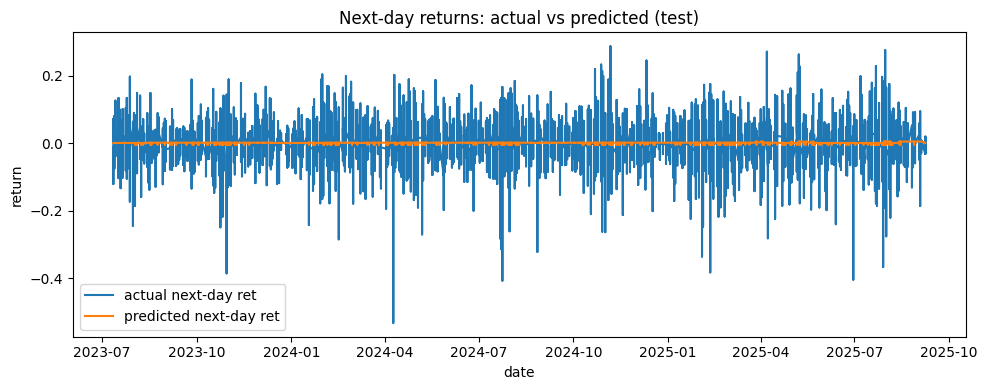

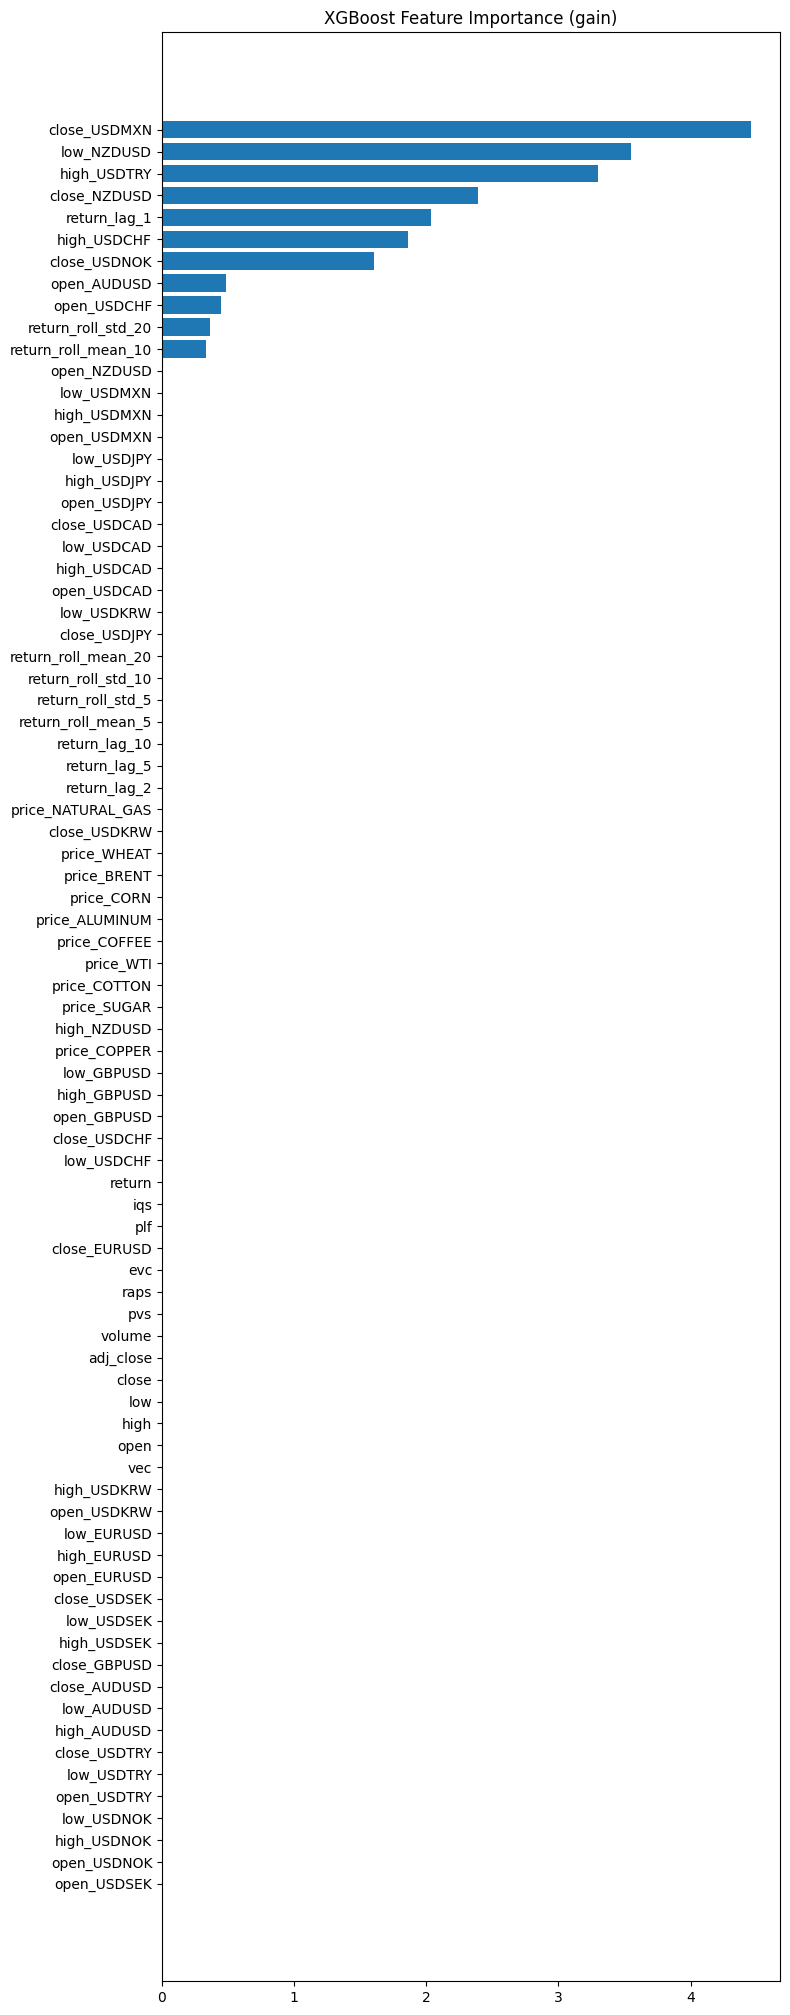

close_USDMXN 4.454431
low_NZDUSD 3.551076
high_USDTRY 3.302685
close_NZDUSD 2.394425
return_lag_1 2.037857
high_USDCHF 1.860419
close_USDNOK 1.601720
open_AUDUSD 0.486903
open_USDCHF 0.447431
return_roll_std_20 0.365012
return_roll_mean_10 0.334315
open_NZDUSD 0.000000
low_USDMXN 0.000000
high_USDMXN 0.000000
open_USDMXN 0.000000
low_USDJPY 0.000000
high_USDJPY 0.000000
open_USDJPY 0.000000
close_USDCAD 0.000000
low_USDCAD 0.000000
dtype: float64

In [31]:
import matplotlib.pyplot as plt

# Actual vs predicted (test)
plt.figure(figsize=(10, 4))
plt.plot(dates_test, y_test, label="actual next-day ret")
plt.plot(dates_test, y_te_pred, label="predicted next-day ret")
plt.title("Next-day returns: actual vs predicted (test)")
plt.xlabel("date")
plt.ylabel("return")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance
score_gain = bst.get_score(importance_type="gain")
fi_series = pd.Series({f: score_gain.get(f, 0.0) for f in feat_names}).sort_values(ascending=False)

plt.figure(figsize=(8, max(3, 0.25 * len(fi_series))))
plt.barh(fi_series.index, fi_series.values)
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance (gain)")
plt.tight_layout()
plt.show()

fi_series.head(20)

Top K Logic 

In [39]:
# ---- Top-K retrain (fixed indices) ----
import numpy as np
import xgboost as xgb
import pandas as pd

k = 3  # pick your K

# 1) Top-K features by gain from the first model
score_gain = bst.get_score(importance_type="gain")
feat_names = list(map(str, feature_cols))
gain = pd.Series({f: score_gain.get(f, 0.0) for f in feat_names}).sort_values(ascending=False)
topk_feats = gain.head(k).index.tolist()

# 2) Indices that mirror your original split
#    train_end and val_size come from your earlier cells
idx_train_core = np.arange(0, train_end - val_size)  # train w/o val
idx_val = np.arange(train_end - val_size, train_end)  # validation slice
idx_test = np.arange(train_end, len(data))  # test slice

# 3) Build X,y for each split using the SAME rows and the TOP-K columns
X_tr_k = data.iloc[idx_train_core][topk_feats].to_numpy(np.float32)
y_tr_k = data.iloc[idx_train_core]["y"].to_numpy(np.float32)
X_val_k = data.iloc[idx_val][topk_feats].to_numpy(np.float32)
y_val_k = data.iloc[idx_val]["y"].to_numpy(np.float32)
X_te_k = data.iloc[idx_test][topk_feats].to_numpy(np.float32)
y_te_k = data.iloc[idx_test]["y"].to_numpy(np.float32)

# 4) DMatrix with matching shapes + feature names
dtr_k = xgb.DMatrix(X_tr_k, label=y_tr_k, feature_names=topk_feats)
dval_k = xgb.DMatrix(X_val_k, label=y_val_k, feature_names=topk_feats)
dte_k = xgb.DMatrix(X_te_k, feature_names=topk_feats)

# 5) Retrain with your params + early stopping
bst_k = xgb.train(
    params=dict(params),
    dtrain=dtr_k,
    num_boost_round=300,
    evals=[(dtr_k, "train"), (dval_k, "eval")],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
)

# 6) Predict with best iteration (with version fallback)
best_it_k = getattr(bst_k, "best_iteration", None)
try:
    it_range = (0, best_it_k + 1) if best_it_k is not None else (0, 0)
    y_te_pred_k = bst_k.predict(dte_k, iteration_range=it_range)
except TypeError:
    ntree = (best_it_k + 1) if best_it_k is not None else None
    y_te_pred_k = bst_k.predict(dte_k, ntree_limit=ntree)

[0]	train-rmse:0.01988	eval-rmse:0.02023
[1]	train-rmse:0.01983	eval-rmse:0.02023
[2]	train-rmse:0.01979	eval-rmse:0.02022
[3]	train-rmse:0.01975	eval-rmse:0.02022
[4]	train-rmse:0.01972	eval-rmse:0.02023
[5]	train-rmse:0.01968	eval-rmse:0.02022
[6]	train-rmse:0.01965	eval-rmse:0.02022
[7]	train-rmse:0.01961	eval-rmse:0.02021
[8]	train-rmse:0.01958	eval-rmse:0.02022
[9]	train-rmse:0.01955	eval-rmse:0.02022
[10]	train-rmse:0.01952	eval-rmse:0.02022
[11]	train-rmse:0.01950	eval-rmse:0.02023
[12]	train-rmse:0.01947	eval-rmse:0.02023
[13]	train-rmse:0.01945	eval-rmse:0.02024
[14]	train-rmse:0.01943	eval-rmse:0.02024
[15]	train-rmse:0.01941	eval-rmse:0.02025
[16]	train-rmse:0.01939	eval-rmse:0.02026
[17]	train-rmse:0.01937	eval-rmse:0.02027
[18]	train-rmse:0.01935	eval-rmse:0.02027
[19]	train-rmse:0.01933	eval-rmse:0.02028
[20]	train-rmse:0.01932	eval-rmse:0.02028
[21]	train-rmse:0.01930	eval-rmse:0.02029
[22]	train-rmse:0.01929	eval-rmse:0.02029
[23]	train-rmse:0.01928	eval-rmse:0.02031
[2

In [40]:
# For the booster trained on top-k features: bst_k
best_it_k = getattr(bst_k, "best_iteration", None)  # 0-indexed
best_score_k = getattr(bst_k, "best_score", None)  # e.g., best RMSE on "eval"

print("Top-k | Best iteration:", best_it_k)
print("Top-k | Best score:", best_score_k)

Top-k | Best iteration: 7
Top-k | Best score: 0.02021483435519484


# final

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm import tqdm
import sys
import seaborn as sns
import gc
import itertools
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from types import SimpleNamespace
from typing import Optional, Sequence, Dict, Any, Tuple, List
import warnings

warnings.filterwarnings('ignore')

DM_STASH = SimpleNamespace()
pd.set_option('display.max_columns', None)

# AFEM
- global order 1, then local order 1. global order 2 local order 2
- order 1 is basically just using one feature, order 3 uses 2 featur interactions like ratio, difference, mean difference (?) etc
- The feature blocks are of couple of types
    - **Statistical**: global order 1 = max min sum mean var std. global order 2 is ratio mean difference (global is expanding)
    - **Time**: global order 1 = day of week, day of month, time to last, time since last. statistical local features = on time based neighbourhood, like last hour last week very common
    - **Social Network**: global = degree clustering coeff, community index. local = statistical on graph based neighbourhoods like in first circle, second circle, community etc
    - **Representation**: global features obtained from PCA SVD, AE of features
- The order applied is stat, time, social network, rep.


- Performance improvements threshold? (add features only if performance improves)
- Early stopping (stop engineering once the RMSE does not change or gets worse after some iterations)

# PNL
- All FX data used  snapped for one day later and all the signals are traded on the open of the next day
- Open price of the next day is also a feature which is used for this reason
- Backtester executes all trades based on signals at the open price

## XGBoost Training Helpers

In [3]:
def train_xgb_core_dicts(
        train: pd.DataFrame,
        cv: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        task: str = "regression",
        params: dict | None = None,
        fit_params: dict | None = None,
):
    """
    XGBoost model training and cross validation with early stopping
    """
    # initializations
    params = dict(params) if params else {}
    fit_params = dict(fit_params) if fit_params else {}
    categorical_cols = list(categorical_cols) if categorical_cols else []

    # categorical handling: convert to 'category' in train and cv
    print('converting category')
    for c in categorical_cols:
        train[c] = train[c].astype("category")
        cv[c] = cv[c].astype("category")

    # get feature names and split train and cv data into X and y
    feature_names = [c for c in train.columns if c != target_col]
    X_train, y_train = train[feature_names], train[target_col]
    X_cv, y_cv = cv[feature_names], cv[target_col]

    # Default eval_metric placement (core API expects in params)
    if "eval_metric" in fit_params and "eval_metric" not in params:
        params["eval_metric"] = fit_params.pop("eval_metric")

    # Map n_estimators -> num_boost_round; map verbose -> verbose_eval; ignore eval_set (not used in core API)
    num_boost_round = int(fit_params.pop("num_boost_round", params.pop("n_estimators", 1000)))
    verbose_eval = fit_params.pop("verbose_eval", fit_params.pop("verbose", False))
    fit_params.pop("eval_set", None)  # harmless if present

    # Task setup & label sanitation
    params.setdefault("objective", "reg:squarederror")

    # coerce y to numeric and drop non-finite
    y_train = pd.to_numeric(y_train, errors="coerce")
    y_cv = pd.to_numeric(y_cv, errors="coerce")

    # reset index to avoid any downstream alignment surprises
    X_train, y_train = X_train.reset_index(drop=True), y_train.reset_index(drop=True)
    X_cv, y_cv = X_cv.reset_index(drop=True), y_cv.reset_index(drop=True)

    # Defaults for metrics if user didn’t set one
    params.setdefault(
        "eval_metric",
        "rmse"
    )

    # Build DMatrices for train and cross validation
    print('creating dmatrix')
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    dcv = xgb.DMatrix(X_cv, label=y_cv, enable_categorical=True)

    # mapping tran and cross  valdiaation for the training process and early stopping
    evals = [(dtrain, "train"), (dcv, "validation")]
    eval_result = {}

    print('boosting time')
    booster = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        early_stopping_rounds=int(fit_params.pop("early_stopping_rounds", 0)) or None,
        evals_result=eval_result,
        verbose_eval=verbose_eval,
        **fit_params
    )

    return booster


def cv_rmse_from_booster(
        booster: xgb.Booster,
        cv_df: pd.DataFrame,
        target_col: str,
        categorical_cols: list[str] | None = None,
        index_col: str | None = "date",
) -> tuple[float, pd.Series]:
    """
    Compute RMSE on the CV set using a core-API XGBoost Booster.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster returned by xgboost.train(...).
    cv_df : pd.DataFrame
        CV dataframe containing features and the target column.
    target_col : str
        Name of the label column in cv_df.
    categorical_cols : list[str] | None
        Columns to treat as categoricals (will be cast to pandas 'category' and kept as-is).
    index_col : str | None
        Column to set as index for alignment in the returned predictions; pass None to leave as-is.

    Returns
    -------
    rmse : float
        Root mean squared error on the CV set.
    """
    if target_col not in cv_df.columns:
        raise KeyError(f"'{target_col}' not in cv_df")

    df = cv_df.copy()
    if index_col and index_col in df.columns:
        df = df.set_index(index_col)

    # Cast categoricals safely (same as training)
    categorical_cols = list(categorical_cols) if categorical_cols else []
    for c in categorical_cols:
        if c in df.columns:
            df[c] = df[c].astype("category")

    # Split features/labels
    feature_cols = [c for c in df.columns if c != target_col]
    y_true = pd.to_numeric(df[target_col], errors="coerce")
    X = df[feature_cols]

    # Drop rows where label is not finite (matches training-time sanitation)
    m = np.isfinite(y_true.to_numpy(dtype=float))
    X = X.loc[m]
    y_true = y_true.loc[m]

    dcv = xgb.DMatrix(X, label=y_true, enable_categorical=True)

    # Predict using best iteration if early stopping was used
    if hasattr(booster, "best_iteration") and booster.best_iteration is not None:
        # iteration_range is preferred in newer xgboost
        try:
            preds = booster.predict(dcv, iteration_range=(0, booster.best_iteration + 1))
        except TypeError:
            preds = booster.predict(dcv, ntree_limit=getattr(booster, "best_ntree_limit", 0) or 0)
    else:
        preds = booster.predict(dcv)

    preds = pd.Series(preds, index=y_true.index, name="prediction")
    rmse = float(np.sqrt(np.mean((preds.to_numpy() - y_true.to_numpy()) ** 2)))
    return rmse


def xgb_feature_importances(
        booster: xgb.Booster,
        feature_names: list[str] | None = None,
        importance_type: str = "gain",  # choices: 'weight', 'gain', 'cover', 'total_gain', 'total_cover'
        normalize: bool = True,
        top_k: int | None = None,
) -> pd.DataFrame:
    """
    Return feature importances from a core-API Booster as a tidy DataFrame.

    Parameters
    ----------
    booster : xgb.Booster
        Trained booster.
    feature_names : list[str] | None
        Feature names order. If None, tries booster.feature_names; if still None, uses keys from get_score().
    importance_type : str
        One of XGBoost's importance types.
    normalize : bool
        If True, scales the Importance column to sum to 1.0.
    top_k : int | None
        If set, return only the top_k features by importance.

    Returns
    -------
    pd.DataFrame with columns: ['feature', 'importance'] sorted descending.
    """
    # Pull raw importance dict: {'f0': val, 'f1': val, ...} OR with real names if available
    scores = booster.get_score(importance_type=importance_type)

    # Resolve feature names
    if feature_names is None:
        # xgboost often carries names through from DMatrix; use them if present
        feature_names = getattr(booster, "feature_names", None)

    # If we have explicit names, make sure all features appear (missing ones get 0)
    if feature_names:
        data = [(fname, float(scores.get(fname, 0.0))) for fname in feature_names]
    else:
        # Fallback to whatever keys we have
        data = [(k, float(v)) for k, v in scores.items()]

    imp_df = pd.DataFrame(data, columns=["feature", "importance"]).sort_values(
        "importance", ascending=False, ignore_index=True
    )

    if normalize and imp_df["importance"].sum() > 0:
        imp_df["importance"] = imp_df["importance"] / imp_df["importance"].sum()

    if top_k is not None:
        imp_df = imp_df.head(int(top_k)).reset_index(drop=True)

    return imp_df


def xgb_pipeline(train: pd.DataFrame, cv: pd.DataFrame, params: dict, fit_params: dict, *args, **kwargs):
    """
    Runs cross validation, evaluation rmse based on best cross validated model and then computes feature importances

    Parameters
    ----------
    train: pd.DataFrame
        training dataframe
    cv: pd.DataFrame
        cross validation dataframe
    params: dict
        hyperparameter dictionary for the xgboost model
    fit_params: dict
        early stopping verbosity and evaluation metrics dictionary

    Returns
    -------
    model object, rmse of the cross validation dataframe based on the best model, normalized feature importance dataframe
    """
    # cross validate with early stopping
    model = train_xgb_core_dicts(train.set_index("date"),
                                 cv.set_index("date"),
                                 target_col="return",
                                 categorical_cols=['symbol'],
                                 params=params,
                                 fit_params=fit_params
                                 )

    # computing rmse from the model on cv data based on best early stopped model
    rmse = cv_rmse_from_booster(
        booster=model,
        cv_df=cv,
        target_col="return",
        categorical_cols=['symbol'],
        index_col="date"
    )

    # get normalized feature importances dataframe
    feat_imp = xgb_feature_importances(
        booster=model,
        feature_names=None,
        importance_type="gain",
        normalize=True,
        top_k=None,
    )

    return model, rmse, feat_imp

## Data Merging Helpers

In [4]:
def commodities_merge(final_df: pd.DataFrame,
                      com_path: str = '/data/notebook_files/alphavantage_data/commodities') -> pd.DataFrame:
    """
    Function to merge all commodities data on the date axis with the entire OHLCV dataframes

    Parameters
    ----------
    final_df : pd.DataFrame
        existing ohlcv dataframe
    com_path : str
        directory of all commodities data

    Returns
    -------
    pd.DataFrame with all commodities data merged with final_df on column 'date'
    """
    folder = Path(com_path)
    commos = [f.stem for f in folder.iterdir() if f.is_file()]

    for commo in tqdm(commos, desc="merging commodities data"):
        df = pd.read_parquet(f"{com_path}/{commo}.parquet")
        df = df[['timestamp', 'price']]
        df["price"] = df["price"].replace(".", np.nan).astype(float)

        df = df.rename(columns={'timestamp': 'date'})
        df = df.rename(columns=lambda x: f"{x}_{commo}" if x != 'date' else x)

        final_df = pd.merge_asof(left=final_df,
                                 right=df,
                                 direction='backward',
                                 on='date'
                                 )

    return final_df


def fx_merge(final_df: pd.DataFrame,
             fx_path: str = '/data/notebook_files/alphavantage_data/fx') -> pd.DataFrame:
    """
    Function to merge all FX data on the date axis with the entire OHLCV data

    Parameters
    ----------
    final_df : pd.DataFrame
        existing ohlcv dataframe
    fx_path : str
        directory of all fx data

    Returns
    -------
    pd.DataFrame with all FX data merged with final_df on column 'date'
    """
    # Ensure 'date' is datetime and sorted for asof merge semantics
    # (merge_asof requires both sides sorted by the key)
    final_df = final_df.copy()
    final_df['date'] = pd.to_datetime(final_df['date'])
    final_df = final_df.sort_values('date').reset_index(drop=True)

    # importing name of currencies couple
    folder = Path(fx_path)
    currencies = [f.stem for f in folder.iterdir() if f.is_file()]

    # importing currencies dataframes and merging with main dataframe
    for currency in tqdm(currencies, desc="merging fx data"):
        
        # Load FX parquet and select OHLC columns + timestamp
        df = pd.read_parquet(f"{fx_path}/{currency}.parquet")
        df = df[['timestamp', 'open', 'high', 'low', 'close']]

        # Rename timestamp -> date
        df = df.rename(columns={'timestamp': 'date'})

        # --- Availability timing adjustment ---
        # FX data for date t is available to equities at t+1.
        # Shift the FX 'date' forward by +1 calendar day so that the row labeled t
        # now aligns to (at earliest) t+1 on the equity side.
        df['date'] = pd.to_datetime(df['date']) + pd.Timedelta(days=1)

        # Add currency suffix to OHLC columns (keep 'date' unchanged)
        df = df.rename(columns=lambda x: f"{x}_{currency}" if x != 'date' else x)

        # Sort FX dataframe by date for merge_asof
        df = df.sort_values('date').reset_index(drop=True)

        # --- As-of merge to the nearest NEXT trading date in final_df ---
        # We want each FX row (shifted to t+1) to appear on the first equity date >= that shifted date.
        # Using merge_asof with direction='backward' on (left=final_df, right=shifted FX) does:
        #   for each equity date d, take the latest FX date s <= d (where s has already been shifted to t+1),
        # effectively placing FX(t) on the first trading day d >= t+1 (including same-day if equal).
        #
        # Note: merge_asof preserves the left frame's rows (final_df) and adds the right's columns.
        final_df = pd.merge_asof(
            left=final_df,
            right=df,
            on='date',
            direction='backward'  # pick FX row with date <= equity date (after the +1 shift)
        )

    return final_df

## Data Prep and Split Helpers

In [5]:
def data_split_and_prep(data: pd.DataFrame,
                        training_start_date: str,
                        training_end_date: str,
                        cross_valid_start_date: str,
                        cross_valid_end_date: str,
                        n_day_returns: int = 1) -> pd.DataFrame:
    """
    Splits full data into training and cross validation data after merging with commodities and fx data as well
    """

    # merge commodities and FX data at this point
    data = fx_merge(data)
    data = commodities_merge(data)

    # moving the returns data to ensure no look ahead biases
    data = output_returns_calculation(data, n_day_returns=n_day_returns)

    # remove null values from the returns series
    data = data[~pd.isna(data['return'])].reset_index(drop=True)

    # split into one fold train and cross validation data
    train, cv = (data[(data['date'] >= training_start_date) &
                      (data['date'] < cross_valid_start_date)],
                 data[(data['date'] >= cross_valid_start_date) &
                      (data['date'] < cross_valid_end_date)])

    return train, cv


def output_returns_calculation(data: pd.DataFrame,
                               n_day_returns: int = 1) -> pd.DataFrame:
    """
    Construct the n-day *forward* return target per symbol/date, with no look-ahead.

    This function computes the aggregated forward return from t+1 .. t+n (assigned at time t)

    We compute the forward n-day return directly from prices: (P_{t+n} / P_t) - 1, using adjusted closes 
    (dividends/splits handled).

    Parameters
    ----------
    data : pd.DataFrame
        Must contain at least ['symbol', 'date'] and 'adj_close' (adjusted close prices).
    n_day_returns : int
        The forward horizon n ≥ 1. The target at time t aggregates r_{t+1}..r_{t+n}.

    Returns
    -------
    pd.DataFrame
        A copy of `data` with the 'return' column overwritten by the forward n-day target:
            y_t = Π_{k=1..n} (1 + r_{t+k}) - 1

    """

    # Work on a copy to avoid mutating caller's DataFrame in place
    out = data.copy()

    # Ensure deterministic ordering by symbol/date; avoid index surprises
    out = out.sort_values(['symbol', 'date']).reset_index(drop=True)

    # We compute this per symbol via shift(-n) to look ahead n days.
    out['return'] = (
        out.groupby('symbol', group_keys=False)['adj_close']          # per-symbol prices
            .apply(lambda p: p.shift(-n_day_returns) / p - 1)          # (P_{t+n}/P_t) - 1
    )

     # ---- Feature: next_day_open aligned to t (decision at open of t+1) ----
    out['next_day_open'] = (
        out.groupby('symbol', group_keys=False)['open']         # per-symbol open prices
           .apply(lambda s: s.shift(-1))                        # bring OPEN_{t+1} to row t
    )

    # Return the DataFrame with 'return' now holding the forward n-day targets
    return out

## Downcasting Helper

In [6]:
def numeric_downcast(
        df: pd.DataFrame,
        float_target: str = "float32",  # options: "float32" or "float16"
        downcast_ints: bool = True,  # also downcast int64 -> int32/16/8 where safe
        exclude: list[str] | None = None,
        in_place: bool = False,
        verbose: bool = True,
) -> pd.DataFrame:
    """
    Downcast numeric dtypes to reduce memory usage.

    - Floats: float64 -> float32 by default (safe); optionally to float16 where values fit.
    - Ints:   int64 -> smallest int dtype that can hold the data (if downcast_ints=True).
    - Exclude: list of columns to leave untouched.

    Returns a (possibly new) DataFrame; prints memory before/after if verbose.
    """
    if exclude is None:
        exclude = []

    df_out = df if in_place else df.copy()

    # memory before
    if verbose:
        mem_gb_before = df_out.memory_usage(deep=True).sum() / (1024 ** 3)
        print(f"[downcast] before: {mem_gb_before:.3f} GB")

    # ---- Downcast integers ----
    if downcast_ints:
        int_cols = df_out.select_dtypes(include=["int", "int64", "int32", "int16", "int8"]).columns
        int_cols = [c for c in int_cols if c not in exclude]
        if int_cols:
            df_out[int_cols] = df_out[int_cols].apply(pd.to_numeric, downcast="integer")

    # ---- Downcast floats ----
    float_cols = df_out.select_dtypes(include=["float"]).columns
    float_cols = [c for c in float_cols if c not in exclude]
    if float_cols:
        if float_target == "float32":
            # simple, safe: float64 -> float32
            for c in float_cols:
                df_out[c] = df_out[c].astype("float32")
        elif float_target == "float16":
            # aggressive: only cast to float16 if values fall within float16 range
            finfo = np.finfo(np.float16)
            for c in float_cols:
                s = df_out[c]
                # Check range ignoring NaNs
                s_min = np.nanmin(s.values)
                s_max = np.nanmax(s.values)
                if s_min >= finfo.min and s_max <= finfo.max:
                    df_out[c] = s.astype("float16")
                else:
                    # fallback to float32 if out of range
                    df_out[c] = s.astype("float32")
        else:
            raise ValueError("float_target must be 'float32' or 'float16'")

    # memory after
    if verbose:
        mem_gb_after = df_out.memory_usage(deep=True).sum() / (1024 ** 3)
        saved = mem_gb_before - mem_gb_after
        pct = (saved / mem_gb_before * 100) if mem_gb_before > 0 else 0.0
        print(f"[downcast]  after: {mem_gb_after:.3f} GB  | saved {saved:.3f} GB ({pct:.1f}%)")

    return df_out

## AFEM Helpers

In [7]:
def size_memory_log(df: pd.DataFrame):
    """
    Prints a log of the dimension as well as the memory consumed by a pandas dataframe
    """
    print(f'data size: {df.shape}')
    print(f'memory usage: {df.memory_usage().sum() / (1024 ** 3):.3f} GB')


def get_all_numeric_cols_sans_return(df: pd.DataFrame) -> List[str]:
    """
    Creates a list of all the numeric data type columns in a dataframe excluding "return"

    Parameters
    ----------
    df: pd.DataFrame
        input dataframe

    Return
    ------
    List of all the numeric columns
    """
    # get all numeric columns
    numeric_cols = df.select_dtypes(include='number').columns.tolist()

    # remove returns from this
    numeric_cols.remove('return')

    return numeric_cols


def signed_log1p(x: pd.Series, eps: float = 1e-12) -> pd.Series:
    """
    Returns the log(1 + x + epsilon) of a pandas series to ensure there are no null o undefined output values

    Parameters
    ----------
    x: pd.Series
        numerical series to compute log(1 + x) for

    Returns
    -------
    log(1 + x) of the input series
    """
    # works for negatives/zeros/positives
    return np.sign(x) * np.log1p(np.abs(x) + eps)


def add_pct_change_per_symbol(df: pd.DataFrame, cols, symbol_col="symbol", suffix="pct_chg") -> pd.DataFrame:
    """
    Add ((cur - prev) / prev) * 100 per symbol; first row per symbol is NaN; avoids look-ahead.
    """
    # iterate through columns list
    for col in cols:
        if f"{suffix}_{col}" not in df.columns:
            # group by symbol and shift for t - 1
            prev = df.groupby(symbol_col, observed=True)[col].shift(1)  # t-1

            # typecast as float
            cur = df[col].astype(float)

            # safety check for prev nan values
            den = prev.where(prev != 0, np.nan)  # avoid div-by-0 -> NaN

            # percentage return computation
            df[f"{suffix}_{col}"] = (cur - prev) / den * 100.0

    return df


def transform_global_order_1(train: pd.DataFrame, cv: pd.DataFrame, **kwargs) -> (pd.DataFrame, pd.DataFrame):
    """
    Creates global transformations for all numeric features such as 
        - log(x)
        - arcsinh(x)
        - x^2
        - x^3
        - pct_change(x) (without futures value peeking)

    Parameters
    ----------
    train: pd.DataFrame
        input training pandas dataframe
    cv: pd.DataFrame
        input cross validation pandas dataframe

    Return
    ------
    The train and cross validation dataframes  after all feature transformations are complete for the numerical columns
    """
    # get train and cv indexes
    train_idx = train.index
    cv_idx = cv.index

    # log data size before engineering
    data = pd.concat([train.set_index('date'), cv.set_index('date')])
    print('before global 1 transformations')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # get all numerical column names minus returns
    num_cols = get_all_numeric_cols_sans_return(data)

    # iterate over numerical columns
    new_cols = {}
    for col in tqdm(num_cols, desc='engineering global 1 features'):
        s = data[col].astype(float)

        # Only create if doesn't already exist
        if f"log_{col}" not in data.columns:
            new_cols[f"log_{col}"] = signed_log1p(s)

        if f"arcsinh_{col}" not in data.columns:
            new_cols[f"arcsinh_{col}"] = np.arcsinh(s)

        if f"square_{col}" not in data.columns:
            new_cols[f"square_{col}"] = s * s

        if f"cube_{col}" not in data.columns:
            new_cols[f"cube_{col}"] = s * s * s

    # percentage change in features
    data = pd.concat([data, pd.DataFrame(new_cols, index=data.index)], axis=1)  # <<< single join (defrag)
    data = add_pct_change_per_symbol(data, num_cols, symbol_col="symbol", suffix="pct_chg")

    print('after global 1 transformations')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # split back into train and cv and return after index reset to get date back into a column
    data = data.reset_index()
    train = data[data.index.isin(train_idx)]
    cv = data[data.index.isin(cv_idx)]

    # collect garbage
    gc.collect()

    return (train, cv)


def time_local_order_1(train: pd.DataFrame,
                       cv: pd.DataFrame,
                       window_size: List[int] = [5, 21],
                       **kwargs) -> (pd.DataFrame, pd.DataFrame):
    """
    Creates local transformations for all numeric features such as 
        - log(x)
        - arcsinh(x)
        - x^2
        - x^3
        - pct_change(x) (without futures value peeking)

    Parameters
    ----------
    train: pd.DataFrame
        input training pandas dataframe
    cv: pd.DataFrame
        input cross validation pandas dataframe

    Return
    ------
    The train and cross validation dataframes  after all feature transformations are complete for the numerical columns
    """
    # get train and cv indexes
    train_idx = train.index
    cv_idx = cv.index

    # log data size before engineering
    data = pd.concat([train.set_index('date'), cv.set_index('date')])
    print('before time local 1 transformations')
    size_memory_log(data)

    # downcasting data and rechecking size
    data = numeric_downcast(data)
    size_memory_log(data)

    # get all numerical column names minus returns
    num_cols = get_all_numeric_cols_sans_return(data)

    # iterate over numerical columns
    new_cols = {}  # collect new columns here to avoid fragmentation

    for col in tqdm(num_cols, desc='engineering time local 1 features'):
        g = data.groupby("symbol", observed=True)[col]
        s = data[col].astype(float)

        for w in window_size:
            # Check if features already exist before creating
            mean_name = f"{col}_roll{w}_mean"
            std_name = f"{col}_roll{w}_std"
            min_name = f"{col}_roll{w}_min"
            max_name = f"{col}_roll{w}_max"

            if mean_name not in data.columns and mean_name not in new_cols:
                new_cols[mean_name] = g.transform(lambda x: x.rolling(w).mean())

            if std_name not in data.columns and std_name not in new_cols:
                new_cols[std_name] = g.transform(lambda x: x.rolling(w).std())

            if min_name not in data.columns and min_name not in new_cols:
                new_cols[min_name] = g.transform(lambda x: x.rolling(w).min())

            if max_name not in data.columns and max_name not in new_cols:
                new_cols[max_name] = g.transform(lambda x: x.rolling(w).max())

    print(f'Created {len(new_cols)} new time local features')

    # single join to avoid fragmentation
    if new_cols:
        data = pd.concat([data, pd.DataFrame(new_cols, index=data.index)], axis=1)

    # sanitize infs produced by zero std
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    print('after time local 1 transformations')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # split back into train and cv and return after index reset to get date back into a column
    data = data.reset_index()
    train = data[data.index.isin(train_idx)]
    cv = data[data.index.isin(cv_idx)]

    # collect garbage
    gc.collect()

    return (train, cv)


def transform_global_order_2(train: pd.DataFrame,
                             cv: pd.DataFrame,
                             order_2_feature_limit: int = 30,
                             random_state: int = 42,
                             **kwargs) -> (pd.DataFrame, pd.DataFrame):
    # get train and cv indexes
    train_idx = train.index
    cv_idx = cv.index

    # log data size before engineering
    data = pd.concat([train.set_index('date'), cv.set_index('date')])
    print('before global order 2 transformations')
    size_memory_log(data)

    # downcasting data and rechecking size
    data = numeric_downcast(data)
    size_memory_log(data)

    # get all numerical column names minus returns
    num_cols = get_all_numeric_cols_sans_return(data)

    # limit to at most `order_2_feature_limit` numeric columns (seeded randomness)
    if len(num_cols) > order_2_feature_limit:
        rng = np.random.default_rng(random_state)
        num_cols = list(rng.choice(num_cols, size=order_2_feature_limit, replace=False))

    # creating tqdm object for progress
    n = len(num_cols)
    pair_iter = itertools.combinations(num_cols, 2)

    # iterate over numerical columns
    new_cols = {}  # collect new columns here to avoid fragmentation

    for a, b in tqdm(pair_iter,
                     total=(n * (n - 1)) // 2,
                     desc="engineering order-2 pairs",
                     mininterval=0.5,
                     leave=False):
        # Check if features already exist before creating
        minus_name = f'{a}_minus_{b}'
        ratio_name = f'{a}_ratio_{b}'

        if minus_name not in data.columns and minus_name not in new_cols:
            new_cols[minus_name] = data[a] - data[b]

        if ratio_name not in data.columns and ratio_name not in new_cols:
            denom_ab = data[b].replace(0, np.nan)
            new_cols[ratio_name] = data[a] / denom_ab

    print(f'Created {len(new_cols)} new order-2 features')

    # single join to avoid fragmentation
    if new_cols:
        data = pd.concat([data, pd.DataFrame(new_cols, index=data.index)], axis=1)

    # sanitize infs produced by zero std
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    print('after global order 2 transformations')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # split back into train and cv and return after index reset to get date back into a column
    data = data.reset_index()
    train = data[data.index.isin(train_idx)]
    cv = data[data.index.isin(cv_idx)]

    # collect garbage
    gc.collect()

    return (train, cv)


def cross_section_percentiles(train: pd.DataFrame,
                              cv: pd.DataFrame,
                              suffix: str = "_cs_pct",
                              **kwargs) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Create per-date cross-sectional percentile features for all numeric columns (excluding returns).

    This function computes, for each trading date independently, the cross-sectional percentile rank
    of each numeric feature across the cross-section (e.g., across all symbols on that date).
    The percentile method matches SciPy's `percentileofscore(..., kind='rank')`:
        PCT(x) = ( count(values < x) + 0.5 * count(values == x) ) / N
    which places ties at their mid-rank. Results lie in [0, 1].

    Design choices
    --------------
    • Concatenate train+cv once, compute, then split back (single wide join to avoid fragmentation).
    • Log memory, downcast numerics, and only create non-duplicate columns.
    • Uses helpers: size_memory_log, numeric_downcast, get_all_numeric_cols_sans_return.

    Parameters
    ----------
    train : pd.DataFrame
    cv    : pd.DataFrame
    suffix : str, default "_cs_pct"

    Returns
    -------
    (train_out, cv_out) : Tuple[pd.DataFrame, pd.DataFrame]
    """

    # --- Tag the split so we can split back exactly (avoids index overlap issues) ---
    train_tagged = train.copy()
    cv_tagged = cv.copy()
    train_tagged["_split"] = "train"
    cv_tagged["_split"] = "cv"

    # --- Combine on 'date' index for efficient groupby(level=0) ---
    data = pd.concat([train_tagged.set_index('date'),
                      cv_tagged.set_index('date')], axis=0)
    print("[CS-PCT] before cross-sectional percentile transforms")
    size_memory_log(data)

    # --- Downcast for memory ---
    data = numeric_downcast(data)
    size_memory_log(data)

    # --- Numeric columns excluding returns ---
    num_cols = get_all_numeric_cols_sans_return(data)
    print(f"[CS-PCT] numeric columns considered (ex-return): {len(num_cols)}")

    new_cols = {}

    # --- Fast NumPy percentile-of-score (rank method) ---
    def _percentile_rank_numpy(vec: np.ndarray) -> np.ndarray:
        out = np.full(vec.shape, np.nan, dtype=np.float64)
        mask = np.isfinite(vec)
        if not np.any(mask):
            return out
        finite = vec[mask].astype(np.float64, copy=False)
        n = finite.size
        uniq, counts = np.unique(finite, return_counts=True)
        cum_counts = np.cumsum(counts)
        less_counts = cum_counts - counts
        pct_map = (less_counts + 0.5 * counts) / n
        idxs = np.searchsorted(uniq, finite, side='left')
        out[mask] = pct_map[idxs]
        return out

    # --- Per-date cross-sectional percentiles for each numeric column ---
    for col in tqdm(num_cols, desc="cross-sectional percentiles", mininterval=0.5, leave=False):
        out_name = f"{col}{suffix}"
        if (out_name in data.columns) or (out_name in new_cols):
            print(f"[CS-PCT] skipping existing column: {out_name}")
            continue

        ranked = (
            data.groupby(level=0, group_keys=False, sort=False)[col]
                .apply(lambda s: pd.Series(
                    _percentile_rank_numpy(s.to_numpy()),
                    index=s.index
                ))
        )
        new_cols[out_name] = ranked

    print(f"[CS-PCT] created {len(new_cols)} new cross-sectional percentile features")

    # --- Single wide join (positionally) to avoid reindex on duplicate labels ---
    if new_cols:
        new_df = pd.DataFrame(
            {name: ser.to_numpy() for name, ser in new_cols.items()},
            index=data.index
        )
        data = pd.concat([data, new_df], axis=1)

    # --- Clean & log ---
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    print("[CS-PCT] after cross-sectional percentile transforms")
    size_memory_log(data)

    data = numeric_downcast(data)
    size_memory_log(data)

    # --- Restore 'date' and split by the tag (exact original row counts preserved) ---
    data = data.reset_index()  # 'date' back to a column
    train_out = (
        data.loc[data["_split"] == "train"]
            .drop(columns=["_split"])
            .reset_index(drop=True)
    )
    cv_out = (
        data.loc[data["_split"] == "cv"]
            .drop(columns=["_split"])
            .reset_index(drop=True)
    )

    # --- GC ---
    del new_cols
    gc.collect()

    print(f"[CS-PCT] output shapes -> train: {train_out.shape}, cv: {cv_out.shape}")
    return train_out, cv_out


def representation_global(train: pd.DataFrame,
                          cv: pd.DataFrame,
                          n: int,
                          index: int,
                          variance_threshold: float = 0.95,
                          random_state: int = 42,
                          **kwargs) -> (pd.DataFrame, pd.DataFrame):
    """
    Fit PCA on TRAIN ONLY (median-impute + standardize), choosing the smallest k
    such that explained variance >= variance_threshold. Adds
    iteration_{n}_index_{index}_pca_{i} (i=1..k) to both splits.
    Uses only index levels (no helper columns).
    """

    # original indexes
    train_idx = train.index
    cv_idx = cv.index

    # combine using MultiIndex
    data = pd.concat({'train': train, 'cv': cv}, names=['split'])
    data = data.set_index('date', append=True)

    print('before representation (PCA)')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # numeric features (sans returns)
    num_cols = get_all_numeric_cols_sans_return(data)

    # mask for train using only the index
    mask_train = (data.index.get_level_values('split') == 'train')

    X_all = data[num_cols].astype(float)
    X_train = X_all[mask_train]
    X_cv = X_all[~mask_train]

    # preprocess (fit on train only)
    imputer = SimpleImputer(strategy='median')
    scaler = StandardScaler(with_mean=True, with_std=True)

    X_train_imp = imputer.fit_transform(X_train)
    X_cv_imp = imputer.transform(X_cv)

    X_train_std = scaler.fit_transform(X_train_imp)
    X_cv_std = scaler.transform(X_cv_imp)

    # PCA with variance threshold 
    pca = PCA(n_components=variance_threshold, svd_solver='full', random_state=random_state)
    Z_tr = pca.fit_transform(X_train_std)
    Z_cv = pca.transform(X_cv_std)

    k = Z_tr.shape[1]
    # >>> renamed columns as requested:
    pca_cols = [f'iteration_{n}_index_{index}_pca_{i + 1}' for i in range(k)]

    # stitch back aligned to the same MultiIndex as `data`
    comps = np.empty((data.shape[0], k))
    comps[mask_train] = Z_tr
    comps[~mask_train] = Z_cv

    data = pd.concat(
        [data, pd.DataFrame(comps, index=data.index, columns=pca_cols)],
        axis=1
    )

    print(f'after PCA (k={k}, threshold={variance_threshold:.2f}, '
          f'cum_var={pca.explained_variance_ratio_.cumsum()[-1]:.4f})')
    size_memory_log(data)
    data = numeric_downcast(data)
    size_memory_log(data)

    # split back using only index levels; restore 'date' column; drop original row index
    train_out = (data.xs('train', level='split')
                 .reset_index(level='date')
                 .reset_index(drop=True))
    cv_out = (data.xs('cv', level='split')
              .reset_index(level='date')
              .reset_index(drop=True))

    gc.collect()
    return train_out, cv_out



def correlation_controller(df: pd.DataFrame) -> pd.DataFrame:
    return df





## Main Pipeline Helper Function

In [8]:
def main(train: pd.DataFrame,
         cv: pd.DataFrame,
         hold_out: pd.DataFrame,
         model_pipeline,
         model_hyperparams,
         n_iterations: int = 10,
         alpha=0.01,
         early_stopping_rounds: int = 10,
         correlation_control=False,
         top_k_feature_limit: int = 500,
         order_2_feature_limit: int = 30,
         full_train_percentage: float = 0.9,
         **kwargs):
    """
    Main AFEM framework. Creates feature families, adds those on iterations that improve performance. Runs the process n_iterations 
    times and terminates  once newly added features do not improve the performance for early_stopping_rounds iteration rounds. 

    Arguments
    ---------
    train: pd.DataFrame
        train dataframe
    cv: pd.DataFrame
        cross validation dataframe
    model_pipeline: model function
        function which trains and cross validates on data and returns model object, rmse on cv data and feature importance object
    model_hyperparams: dict
        hyperparameters of the model training model
    n_iterations: int
        number of afem pipeline iterations
    early_stopping_rounds: int
        when to stop the afem pipeline if the performance does not improve
    correlation_control: bool
        employing correlation controlling to avoid having very highly correlated features
    top_k_feature_limit: int
        limiting the number of features engineered at any point after selection
    order_2_feature_limit: int
        for order 2 we have 30C2 selection possibilities which comes to 435 as a limit for now
    **kwargs
        other key word arguments for the training function
    """

    # get date, symbol open and next_day_open for evaluation
    # train = train.sort_values(['date', 'symbol']).reset_index(drop=True)
    # cv = cv.sort_values(['date', 'symbol']).reset_index(drop=True)
    # hold_out = hold_out.sort_values(['date', 'symbol']).reset_index(drop=True)
    open_df = hold_out.loc[:, ['date', 'symbol', 'open']]

    # initial train and eval
    model, initial_rmse, _ = model_pipeline(train, cv, params, **kwargs)
    print(f'initial rmse: {initial_rmse:0.6f}')

    # evaluate baseline
    print('evaluating baseline performance')
    daily, metrics = backtest_topk_dropn(df=hold_out, model=model, features=model.feature_names)
    metrics = pd.DataFrame.from_dict([metrics])

    # create output folder and save results
    os.makedirs(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/pnl', exist_ok=True)
    os.makedirs(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/stats', exist_ok=True)
    os.makedirs(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/features', exist_ok=True)

    # writing as csv
    print('saving baseline results')
    daily.to_csv(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/pnl/init.csv', index=False)
    metrics.to_csv(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/stats/init.csv', index=False)

    # add correlation control filter here and see if it improves score

    # feature engineering pairs
    feateng_map = [
        ('global_order_1', transform_global_order_1),
        ('time_local_order_1', time_local_order_1),
        ('global_order_2', transform_global_order_2),
        ('time_local_order_1', time_local_order_1),
        ('cross_section_percentiles', cross_section_percentiles),
        ('time_local_order_1', time_local_order_1),
        ('representation_global', representation_global),
        ('time_local_order_1', time_local_order_1),
    ]
    
    # number of strikes counter to check for early stop
    strikes = 0
    rmse = initial_rmse

    # beging feauture engineering process
    for n in range(n_iterations):
        
        # iterate over all transformations
        for index, (transformation_key, transformation_function) in enumerate(feateng_map):
            
            # no performance improvement and local time order 1, skip
            if rmse > initial_rmse:
                if transformation_key == 'time_local_order_1':
                    print('no performance improvement from global, skipping local')
                    continue

            # add feature family
            print("=" * 69)
            print(f'running transformation: {transformation_key}')
            (temp_train, temp_cv) = transformation_function(train, cv, n=n, index=index)

            # check performance
            print(f'evaluating performance after {transformation_key} transformations')
            model, rmse, feat_imp = model_pipeline(temp_train, temp_cv, params, **kwargs)

            # top feature selection
            top_features = feat_imp[feat_imp['importance'] > alpha].head(top_k_feature_limit)['feature'].tolist()
            print(f'number of features above threshold: {len(top_features)}')

            # print if performance improved
            if rmse < initial_rmse:
                # log
                print(f'rmse improvement from: {initial_rmse:0.6f} to : {rmse:0.6f}')
                print(f'percentage improvement: {100 * ((initial_rmse - rmse) / initial_rmse):0.3f}%')
                print('changing feature set')

                # change the training and cross validation features for next iteration
                original_full = pd.concat([train, cv])
                train = temp_train.loc[:, ['date', 'symbol'] + top_features + ['return']]
                cv = temp_cv.loc[:, ['date', 'symbol'] + top_features + ['return']]
                initial_rmse = rmse

                # retraining on the entire data set (90% train + 10% cv)
                print('retraining on full dataset before evaluation')
                size = int(train.shape[0]) + int(cv.shape[0])
                print('size: ', size)
                full = pd.concat([train, cv])
                model, _, _ = model_pipeline(full.head(int(full_train_percentage * size)), 
                                             full.tail(int(size - int(full_train_percentage * size))),
                                             params, **kwargs)

                # replicating the features in the holdout and then evaluating
                print('replicating new feature set  on hold out')
                (_, hold_out) = transformation_function(full, hold_out, n=n, index=index)
                print('hold out dates min max: ', hold_out['date'].min(), hold_out['date'].max())
                hold_out = hold_out.loc[:, ['date', 'symbol'] + top_features + ['return']]

                # evaluate new hold_out
                print('evaluating new feature hold out results')
                # daily, metrics = backtest_topk_dropn(df=pd.merge(hold_out.drop(columns=['open'], errors='ignore'), 
                #                                                  open_df, how='left', on=['date', 'symbol']),
                #                                      model=model, 
                #                                      features=model.feature_names)
                daily, metrics = backtest_topk_dropn(df=pd.merge(hold_out.drop(columns=['open'], errors='ignore'), 
                                                                 open_df, how='left', on=['date', 'symbol']),
                                                     model=model, 
                                                     features=model.feature_names)
                
                metrics = pd.DataFrame.from_dict([metrics])
                
                # writing as csv
                print('saving new feature hold out results')
                daily.to_csv(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/pnl/iteration_{n}_{transformation_key}_index_{index}.csv', index=False)
                metrics.to_csv(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/stats/iteration_{n}_{transformation_key}_index_{index}.csv', index=False)
                
                # saving the top features list into a separate csv
                pd.DataFrame({'features': top_features}).to_csv(f'./alpha_{alpha}_learning_rate_{learning_rate}_n_estimator_{n_estimator}/features/iteration_{n}_{transformation_key}_index_{index}.csv', 
                                                                index=False)

                # In main function, after selecting top_features
                print(f'Top features: {len(top_features)} unique: {len(set(top_features))}')

                # reset the number of strikes
                strikes = 0
            
            else:

                print('no performance improvement, use old feature set, no changes')
                
                # incrementing number of strikes
                strikes += 1
                print(f'strike: {strikes}')

                # checking for early stopping threshold and terminating if met
                if strikes >= early_stopping_rounds:
                    
                    print(f"{early_stopping_rounds} strikes, you're out!. early stopping called")
                    return

            # log divider
            print("=" * 69)

    

## Hold Out Evaluation Helpers

In [9]:
def xgb_data_typecasting(model: Any,
                         df: pd.DataFrame,
                         output: str ='return') -> pd.DataFrame:
    """
    Ensures that all the datatypes of the hold out data to predict align with the features that the model
    has been trained on and are in aignment

    Parameters
    ----------
    model: Any
        model object which has been trained and used to predict
    df: pd.DataFrame
        data for which we are trying to make predictions for

    Return
    ------
    Dataframe which has all columns of the appropriate type before the model can be run
    """

    # tqdm bar length
    tqdm_len = len(model.feature_names)

    # iterating through feature names and types zipped loop
    for (col, typ) in tqdm(zip(model.feature_names, model.feature_types), desc='typecasting'):
        
        # typcasting categorical columns
        if typ == 'c':
            df[col] = df[col].astype('category')
    
    # return dataframe
    return xgb.DMatrix(df.loc[:, model.feature_names], enable_categorical=True)

def plot_pnl(daily: Dict) -> None:
    """
    Plots the cumulative PNL of the prediction model
    """
    # create canvas
    plt.figure(figsize=(12,6))

    # set  tiitle and labels for the axes
    plt.title('Strategy PNL')
    plt.xlabel('Date')
    plt.ylabel('Cumulative PNL ($)')

    # plot the data
    plt.plot(daily['date'], daily['pnl'].cumsum(), label='PNL')
    
    # set 0 level for break even mark
    plt.axhline(y=0, color='r', linestyle ='--')

    # plot legend and grid lines
    plt.legend()
    plt.grid()
    plt.show()
    
    return

def backtest_topk_dropn(
    df: pd.DataFrame,                               # input dataframe with at least ['symbol','date','open'] and either 'alpha' or model+features
    model: Optional[Any] = None,                    # model with .predict(X) if alpha not precomputed
    features: Optional[Sequence[str]] = None,       # list of feature column names if using model
    alpha_col: str = "alpha",                       # name of the alpha score column if already present
    k: int = 50,                                    # portfolio size target (top-k names to hold)
    n: int = 5,                                     # max number of stocks traded per day (turnover cap across opens+closes)
    start_date: str = "2024-01-01",                 # inclusive evaluation start date
    end_date: str = "2025-09-01",                   # exclusive evaluation end date
    capital: float = 1_000_000.0,                   # initial notional
    cost_bps: float = 0.0,                          # round-trip cost in basis points per *stock action* (applied as % of notional changed at open)
    prefer_higher_alpha: bool = True,               # True: larger alpha is better; False: smaller is better
    bootstrap_fill: bool = True,                    # ignore turnover cap on the very first trading day to install full top-k
    rng_seed: int = 42                              # for deterministic tie-breaking
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    """
    Simulate a top-k / drop-n long-only strategy with *open-to-open* accounting and turnover capping.

    Timeline & trading rule
    -----------------------
    • On each date t, we compute/rank alphas across symbols using data available *as of t*.
    • These ranks decide the *desired* portfolio for the next session's open at t+1.
    • At the open of t+1, we adjust the current holdings toward the desired top-k, but we may only
      trade at most 'n' stock actions that day (each open or close counts as one "action").
      - We prioritize closing the worst-ranked existing names not in top-k, then opening the best-ranked missing names.
      - If actions exceed 'n', we stop once we hit the cap (portfolio may lag the desired top-k).
    • Positions are held *through the session* (from open_t to open_{t+1}); daily return is open-to-open.

    Data requirements
    -----------------
    df must contain:
      - 'symbol' (str or categorical)
      - 'date' (datetime64[ns] or parseable to datetime)
      - 'open' (float)
    And:
      - a `model` with `.predict(X)` and a `features` list to compute alphas.

    Metrics reported
    ----------------
    • total_pnl, total_return, CAGR, ann_vol, sharpe, max_drawdown, calmar, win_rate,
      avg_trades_per_day, avg_turnover_pct (sum |Δweights| per day), days, start, end.

    Cost model
    ----------
    • At each open, we compute weight changes Δw and apply transaction cost:
        cost = (sum(abs(Δw)) * capital) * (cost_bps / 10_000)
      This is subtracted from daily PnL on that open.

    Parameters
    ----------
    prefer_higher_alpha : if False, we sort ascending (e.g., when smaller is "better").
    bootstrap_fill      : if True, the very first install into top-k ignores the 'n' cap.

    Returns
    -------
    daily : pd.DataFrame
        Columns: ['date','ret','pnl','equity','trades','turnover_abs_w','held_count']
        'ret' is daily portfolio open-to-open return; 'pnl' is dollar PnL after costs; 'equity' cumulative.
    metrics : Dict[str, float]
        Dictionary of summary performance metrics described above.

    Notes
    -----
    • This engine is deterministic (rng-seeded) for tie-breaking.
    • If you prefer *close-to-close* accounting or intraday open→close, adapt the return leg accordingly.
    """
    
    # -----------------------------
    # 0) Defensive copies & types
    # -----------------------------
    df = df.copy()  # do not mutate caller's data
    
    # -------------------------------------------
    # 1) Compute or validate alpha per (date,sym)
    # -------------------------------------------
    # Build X in the same row order; prediction must align 1:1 back into df
    X = xgb_data_typecasting(model=model, df=df)  # <- fix undefined `hold_out`
    # Model inference; assumes .predict exists and returns 1D array-like
    df[alpha_col] = model.predict(X)

    # 1a) RMSE against the provided 'return' column over the eval window
    if 'return' in df.columns:
        df_rmse = (
            df.loc[(df['date'] >= start_date) & (df['date'] < end_date), [alpha_col, 'return']]
            .dropna()
        )
        rmse = float(np.sqrt(np.mean((df_rmse[alpha_col] - df_rmse['return'])**2))) \
            if not df_rmse.empty else np.nan
    else:
        print('no return column present')
        rmse = np.nan


    # --------------------------------------------
    # 2) Precompute open-to-open returns per stock
    #    r_oo at date t: (open_{t+1} / open_t) - 1
    # --------------------------------------------
    df = df.sort_values(['symbol', 'date']).reset_index(drop=True)

    # ensure date is datetime to avoid mixed dtypes later
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['next_open'] = df.groupby('symbol', group_keys=False)['open'].shift(-1)
    df['ret_oo'] = (df['next_open'] / df['open']) - 1  # open-to-next-open

    # We only have a valid open-to-open return where next_open exists (non-null) and date is valid
    df_valid = df.dropna(subset=['next_open', 'date']).copy()

    # --------------------------------------------
    # 3) Restrict to backtest window and rank book
    # --------------------------------------------
    # Build a clean DatetimeIndex of unique dates (sorted) — avoids int/Timestamp comparisons
    unique_dates_idx = pd.DatetimeIndex(df_valid['date'].unique()).sort_values()

    start_dt = pd.to_datetime(start_date)
    end_dt   = pd.to_datetime(end_date)

    # Indices for iteration (left-inclusive)
    idx_start = unique_dates_idx.searchsorted(start_dt, side='left')
    idx_end   = unique_dates_idx.searchsorted(end_dt,   side='left')
    print('unique_dates_idx: ', unique_dates_idx)
    print('idx_start, idx_end: ', idx_start, idx_end)

    # if idx_start == len(unique_dates_idx):
    #     raise ValueError("start_date is beyond the available data range.")
    # if idx_end - idx_start < 2:
    #     raise ValueError("Backtest window too short after filtering (need at least 2 sessions).")

    # Include the planning day (idx_start-1) if available
    iter_start = max(0, idx_start - 1)
    iter_end   = idx_end  # exclusive

    # If you index later, use this array of datetimes (keeps rest of your code unchanged)
    unique_dates = unique_dates_idx.values

    # -------------------------------
    # 4) Prepare daily alpha rankings
    # -------------------------------
    # We'll create a mapping date -> ranked list of (symbol, rank_score)
    # Ties broken deterministically by symbol then by RNG seeded order.
    rng = np.random.default_rng(rng_seed)

    daily_rank = {}  # date -> list of symbols in desired order
    for d in unique_dates[iter_start:iter_end]:
        # Slice cross-section for this date
        cs = df_valid.loc[df_valid['date'] == d, ['symbol', alpha_col]].copy()
        # Break ties deterministically: add small jitter based on a seeded permutation
        jitter = pd.Series(rng.uniform(low=-1e-12, high=1e-12, size=len(cs)), index=cs.index)
        cs['_score'] = cs[alpha_col] + jitter.values
        # Sort by alpha direction
        cs = cs.sort_values('_score', ascending=not prefer_higher_alpha)
        # Keep final order of symbols
        daily_rank[d] = cs['symbol'].tolist()

    # ------------------------------------------
    # 5) Event loop: simulate open-to-open PnL
    # ------------------------------------------
    equity = capital                              # current equity/notional
    holdings = {}                                 # symbol -> weight at *open* of current day
    daily_records = []                             # to accumulate per-day performance
    prev_date = None                               # previous open date (for PnL labeling)

    for i in range(iter_start, iter_end - 1):
        # Date t and next date t+1 (we earn return from open_t -> open_{t+1})
        d_t = unique_dates[i]
        d_t1 = unique_dates[i + 1]

        # Cross-section rows for day t for returns
        cs_t = df_valid.loc[df_valid['date'] == d_t, ['symbol', 'ret_oo']].set_index('symbol')

        # ---------- Decide rebalancing at open of day t ----------
        # We install the *desired* portfolio for day t *based on rankings from day t-1*
        # except on the very first usable day (i == iter_start), where we can't look back.
        if i == iter_start:
            # First "install" day: use today's ranking (d_t) to initialize holdings that start
            # earning returns from open_t -> open_{t+1}. Optionally ignore turnover cap.
            desired_syms = daily_rank[d_t][:k] if d_t in daily_rank else []
            # Decide how many opens we may execute
            if bootstrap_fill:
                to_open = desired_syms  # ignore cap, open full book
            else:
                to_open = desired_syms[:min(n, len(desired_syms))]  # respect cap on day 1
            # Build new holdings equally weighted
            if to_open:
                w = 1.0 / len(to_open)
                holdings = {s: w for s in to_open}
            else:
                holdings = {}

            # Trading cost on initial install
            turnover_abs_w = sum(abs(w) for w in holdings.values())  # sum |Δw|; prior was 0
            trades_executed = len(to_open)  # each open is one action
            cost_today = turnover_abs_w * capital * (cost_bps / 10_000.0)

        else:
            # For day t, we already have holdings from prior step (at open_t).
            # Now compute PnL for open_t -> open_{t+1} BEFORE we plan for t+1.
            pass  # (we’ll compute PnL below, after we confirm today's holdings)

        # ---------- Compute PnL for day t (open->open) using holdings at open_t ----------
        # Daily return is sum_i w_i(t_open) * r_oo_i(t)
        if len(holdings) > 0:
            # Align available returns to held symbols (drop any missing)
            rets = cs_t['ret_oo'].reindex(pd.Index(list(holdings.keys()))).dropna()
            # If some held symbols are missing today's return, assume 0 (or drop their weight)
            if rets.index.size < len(holdings):
                # Proportionally rescale remaining weights to sum to 1 if any names missing
                total_w_kept = sum(holdings[s] for s in rets.index)
                if total_w_kept > 0:
                    scaled_weights = {s: holdings[s] / total_w_kept for s in rets.index}
                else:
                    scaled_weights = {s: 0.0 for s in rets.index}
            else:
                scaled_weights = holdings

            # Portfolio daily return (open-to-open)
            port_ret = float((pd.Series(scaled_weights).reindex(rets.index) * rets).sum())
        else:
            port_ret = 0.0

        # If this is the very first day we also had an initial install cost; otherwise cost is determined below
        if i == iter_start:
            pnl_before_cost = equity * port_ret
            pnl_after_cost = pnl_before_cost - cost_today
            equity = equity + pnl_after_cost
            daily_records.append({
                'date': d_t,  # label by the *start* of the open→open interval
                'ret': port_ret,
                'pnl': pnl_after_cost,
                'equity': equity,
                'trades': trades_executed,
                'turnover_abs_w': turnover_abs_w,
                'held_count': len(holdings)
            })
        else:
            # For regular days, trading cost will be computed after we decide new holdings at open of t+1,
            # but PnL for (t→t+1) is earned with pre-trade holdings (no cost yet).
            pnl_before_cost = equity * port_ret

        # ---------- Plan desired book for day t+1 using rankings at day t ----------
        desired_syms = daily_rank[d_t][:k] if d_t in daily_rank else []

        # Compute current and desired sets
        current_set = set(holdings.keys())
        desired_set = set(desired_syms)

        # Names to close (in current but not desired), sorted by *worst* rank first
        # Rank map for day t: lower index is better
        rank_order = {sym: r for r, sym in enumerate(daily_rank[d_t])}
        to_close_sorted = sorted(list(current_set - desired_set), key=lambda s: rank_order.get(s, 10**9), reverse=True)

        # Names to open (in desired but not current), sorted by *best* rank first
        to_open_sorted = sorted(list(desired_set - current_set), key=lambda s: rank_order.get(s, 10**9))

        # Select actions under daily cap n (each open/close = 1 action)
        # Close first (free capacity / reduce drift), then open
        actions = []
        for s in to_close_sorted:
            if len(actions) < n:
                actions.append(('close', s))
            else:
                break
        for s in to_open_sorted:
            if len(actions) < n:
                actions.append(('open', s))
            else:
                break

        # Apply actions at the OPEN of t+1 to form the new holdings for that next day
        new_holdings = holdings.copy()
        for (act, s) in actions:
            if act == 'close' and s in new_holdings:
                new_holdings.pop(s, None)
            elif act == 'open':
                new_holdings[s] = 0.0  # add with dummy weight; we’ll re-equalize next

        # Equal-weight across whatever we hold after actions; if empty, stay flat
        if len(new_holdings) > 0:
            ew = 1.0 / len(new_holdings)
            new_holdings = {s: ew for s in new_holdings.keys()}
        else:
            new_holdings = {}

        # Compute turnover in *weights* (sum |Δw|) and cost charged at open of t+1
        # Build aligned vectors over union of symbols
        all_syms = set(holdings.keys()) | set(new_holdings.keys())
        prev_w = pd.Series({s: holdings.get(s, 0.0) for s in all_syms})
        next_w = pd.Series({s: new_holdings.get(s, 0.0) for s in all_syms})
        turnover_abs_w = float((next_w - prev_w).abs().sum())
        trades_executed = len(actions)
        cost_today = turnover_abs_w * capital * (cost_bps / 10_000.0)

        # Now finalize today's PnL including *today’s* cost (charged at open of t+1)
        pnl_after_cost = pnl_before_cost - cost_today
        equity = equity + pnl_after_cost

        # Record today
        daily_records.append({
            'date': d_t,  # date labeling the open→open interval
            'ret': port_ret,
            'pnl': pnl_after_cost,
            'equity': equity,
            'trades': trades_executed,
            'turnover_abs_w': turnover_abs_w,
            'held_count': len(new_holdings)
        })

        # Advance holdings to next day
        holdings = new_holdings
        prev_date = d_t

    # -----------------------------
    # 6) Assemble daily DataFrame
    # -----------------------------
    daily = pd.DataFrame(daily_records).reset_index(drop=True)

    # Restrict to reporting window [start_date, end_date) (some records might start at the planning step)
    daily = daily[(daily['date'] >= start_dt) & (daily['date'] < end_dt)].reset_index(drop=True)

    # -----------------------------
    # 7) Compute summary metrics
    # -----------------------------
    # Basic counts
    days = len(daily)
    if days == 0:
        raise ValueError("No daily records in the requested date window (check inputs and dates).")

    # Total return and PnL
    total_pnl = float(daily['pnl'].sum())
    total_return = float((daily['equity'].iloc[-1] / capital) - 1.0)

    # Daily return stats
    mu = float(daily['ret'].mean())
    sigma = float(daily['ret'].std(ddof=1)) if days > 1 else 0.0

    # Annualization (252 trading days)
    ann_vol = float(sigma * np.sqrt(252)) if sigma is not None else 0.0
    sharpe = float((mu / sigma) * np.sqrt(252)) if sigma and sigma > 0 else np.nan

    # Equity curve & drawdowns
    equity_curve = daily['equity'].values
    running_max = np.maximum.accumulate(equity_curve)
    drawdowns = (equity_curve / running_max) - 1.0
    max_dd = float(drawdowns.min())  # negative number
    years = days / 252.0
    cagr = float((equity_curve[-1] / equity_curve[0])**(1.0 / years) - 1.0) if years > 0 else np.nan
    calmar = float(cagr / abs(max_dd)) if max_dd < 0 else np.nan

    # Win rate
    win_rate = float((daily['ret'] > 0).mean())

    # Trading activity
    avg_trades_per_day = float(daily['trades'].mean())
    avg_turnover_pct = float(daily['turnover_abs_w'].mean())  # in weight points (1.0 == 100%)

    # Package metrics
    metrics = {
        'start': pd.to_datetime(daily['date'].iloc[0]).strftime('%Y-%m-%d'),
        'end': pd.to_datetime(daily['date'].iloc[-1]).strftime('%Y-%m-%d'),
        'rmse': rmse,
        'days': days,
        'total_pnl': total_pnl,
        'total_return': total_return,
        'CAGR': cagr,
        'ann_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,       # negative value
        'calmar': calmar,
        'win_rate': win_rate,
        'avg_trades_per_day': avg_trades_per_day,
        'avg_turnover_pct': avg_turnover_pct
    }

    return daily, metrics

In [10]:
# training and testing dates
training_start_date = "2000-01-01"
training_end_date = "2024-01-01"

# hold out testing dates
hold_out_start_date = "2024-01-01"
hold_out_end_date = "2026-01-01"

# cross validation dates
cross_valid_start_date = "2022-01-01"
cross_valid_end_date = "2024-01-01"

# returns lag feature int
n_day_returns = 1

In [12]:
# read training data
data = pd.read_parquet('/data/notebook_files/training_data.parquet')

# split into one fold train and cross validation data
train, cv = data_split_and_prep(data,
                                training_start_date=training_start_date,
                                training_end_date=training_end_date,
                                cross_valid_start_date=cross_valid_start_date,
                                cross_valid_end_date=cross_valid_end_date,
                                n_day_returns=n_day_returns)

# creating final hold out data
hold_out, _ = data_split_and_prep(data,
                                training_start_date=hold_out_start_date,
                                training_end_date=hold_out_end_date,
                                cross_valid_start_date=hold_out_end_date,
                                cross_valid_end_date=hold_out_end_date,
                                n_day_returns=n_day_returns)

# training hyperparameters
params = {
    "learning_rate": 0.05,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "n_estimators": 2000,
}

# fitting hyperparameters
fit_params = {
    "eval_metric": "rmse",
    "early_stopping_rounds": 50,
    "eval_set": None,
    "verbose": True,
}


merging commodities data: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


In [15]:
alphas = [0.01, 0.02]
learning_rates = [0.01, 0.03, 0.05]
n_estimators = [1000, 2000, 3000]

for alpha in alphas:
    for learning_rate in learning_rates:
        for n_estimator in n_estimators:
            try:
                print("=="*69)
                print(f'alpha: {alpha} learning_rate: {learning_rate} n_estimator: {n_estimator}')
                print("=="*69)
                params = {
                            "learning_rate": learning_rate,
                            "max_depth": 8,
                            "subsample": 0.8,
                            "colsample_bytree": 0.8,
                            "tree_method": "hist",
                            "n_estimators": n_estimator,
                        }

                main(train, cv, hold_out, xgb_pipeline, params, fit_params=fit_params, alpha=alpha)
            except Exception as e:
                print(f'ERROR: {e}')
                continue

[750]	train-rmse:0.01549	validation-rmse:0.01965
[751]	train-rmse:0.01548	validation-rmse:0.01965
[752]	train-rmse:0.01548	validation-rmse:0.01965
[753]	train-rmse:0.01548	validation-rmse:0.01965
[754]	train-rmse:0.01548	validation-rmse:0.01965
[755]	train-rmse:0.01547	validation-rmse:0.01965
[756]	train-rmse:0.01547	validation-rmse:0.01965
[757]	train-rmse:0.01547	validation-rmse:0.01965
[758]	train-rmse:0.01546	validation-rmse:0.01965
[759]	train-rmse:0.01546	validation-rmse:0.01965
[760]	train-rmse:0.01546	validation-rmse:0.01965
[761]	train-rmse:0.01546	validation-rmse:0.01965
[762]	train-rmse:0.01545	validation-rmse:0.01965
[763]	train-rmse:0.01545	validation-rmse:0.01965
[764]	train-rmse:0.01545	validation-rmse:0.01965
[765]	train-rmse:0.01545	validation-rmse:0.01965
[766]	train-rmse:0.01544	validation-rmse:0.01964
[767]	train-rmse:0.01544	validation-rmse:0.01964
[768]	train-rmse:0.01543	validation-rmse:0.01964
[769]	train-rmse:0.01543	validation-rmse:0.01964
[770]	train-rmse:0.0

typecasting: 72it [00:00, 6711.04it/s]
engineering global 1 features: 100%|██████████| 80/80 [00:05<00:00, 13.72it/s]
typecasting: 11it [00:00, 1131.01it/s]
engineering time local 1 features: 100%|██████████| 45/45 [01:59<00:00,  2.66s/it]
typecasting: 43it [00:00, 4690.76it/s]
engineering global 1 features: 100%|██████████| 42/42 [00:01<00:00, 21.56it/s]
typecasting: 72it [00:00, 6877.63it/s]
engineering global 1 features: 100%|██████████| 78/78 [00:05<00:00, 13.65it/s]
typecasting: 9it [00:00, 919.96it/s]
engineering time local 1 features: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it]
typecasting: 72it [00:00, 6765.16it/s]
engineering global 1 features: 100%|██████████| 80/80 [00:05<00:00, 14.22it/s]
typecasting: 11it [00:00, 1157.05it/s]
engineering global 1 features: 100%|██████████| 10/10 [00:00<00:00, 20.59it/s]
typecasting: 72it [00:00, 6800.04it/s]
engineering global 1 features: 100%|██████████| 84/84 [00:05<00:00, 14.26it/s]
typecasting: 15it [00:00, 1534.09it/s]
engineering g

In [35]:
ho = DM_STASH.df.sort_values(['date', 'symbol']).reset_index(drop=True)
odf = DM_STASH.open_df.sort_values(['date', 'symbol']).reset_index(drop=True)

## Correlation Heatmap

<Axes: >

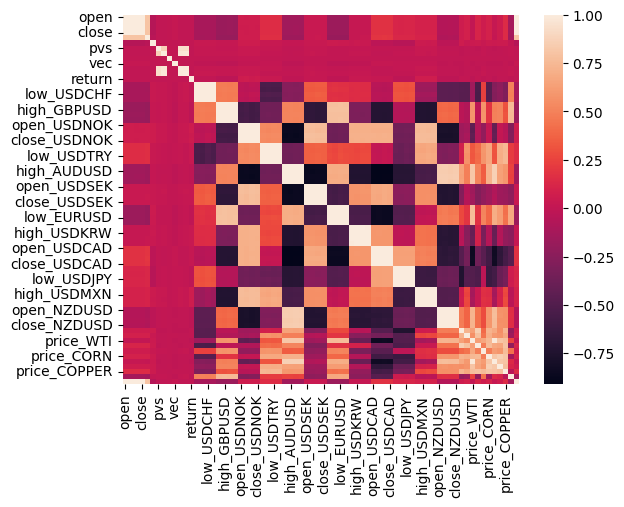

In [35]:
# creating seaborn correlation heatmap
sns.heatmap(train.drop(columns=['date', 'symbol']).corr())